<a href="https://colab.research.google.com/github/Aelnabawy/CausalFeatureTransformation/blob/main/Causal_epigentics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import & Load

In [ ]:
! pip install scikeras[tensorflow]
! pip install econml
! pip install dowhy
! pip install sklearn-contrib-lightning
! pip install numpy==1.25
! pip install pandas==2.2.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 379.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.3/147.3 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.8
    Uninstalling slicer-0.0.8:
      Successfully uninstalled slicer-0.0.8
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: shap
    Found existing

ERROR: Operation cancelled by user
^C


In [ ]:
! pip install econml
! pip install numpy
! pip install dowhy
! pip install sklearn-contrib-lightning
! pip install econml[dowhy]
#! pip install FLAML
#! pip install causaltune

  Using cached sklearn-contrib-lightning-0.6.2.post0.tar.gz (70 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: dowhy
    Found existing installation: dowhy 0.12
    Uninstalling dowhy-0.12:
      Successfully uninstalled dowhy-0.12


In [ ]:
from econml.dml import DML
from econml.sklearn_extensions.linear_model import StatsModelsLinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import pandas as pd
import numpy as np
import scipy
import os
from google.colab import drive
import sys
import statsmodels
import scipy.stats as stats
from sklearn.metrics import precision_recall_curve

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/MyDrive/Epigentics-Genomics Study")

In [ ]:
CancerType="Kidney"
# Head-Neck Kidney LSCC LUAD Pancreas
Epigentetics_File= "Methylation_Meta_Value"

GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
RNASEQ = pd.read_csv(CancerType+" "+ "RNASeq_Matrix_Pre-processed.csv", index_col=0)
#RNASEQ=RNASEQ.drop(index="C3N-00545-06")
Proteins = pd.read_csv(CancerType+"_"+ "Proteomics_Imputed.csv", index_col=0).transpose()
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")


###Dual multi-outcome transformation

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from econml.inference import LinearModelFinalInference
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy
import pandas
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout
from keras.layers import Input
from keras.layers import Conv1D, MaxPooling1D, Flatten, UpSampling1D
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np
import tensorflow as tf
from keras.optimizers import RMSprop
import random as python_random

def reset_seeds():
   np.random.seed(987654321)
   python_random.seed(987654321)
   tf.random.set_seed(987654321)
   keras.utils.set_random_seed(987654321)

reset_seeds()

n_epochs=10
results_train_loss=[0]*n_epochs
results_train_val_loss=[0]*n_epochs

CancerType="Kidney"
# Head-Neck Kidney LSCC LUAD Pancreas
Epigentetics_File= "Methylation_Meta_Value" #Methylation_Meta_Value #miRNA_Matrix_Pre-processed.csv
GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['State']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['State']
RNASEQ = pd.read_csv(CancerType+" "+ "RNASeq_Matrix_Pre-processed.csv", index_col=0)
Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")
Proteins = pd.read_csv(CancerType+"_"+ "Proteomics_Imputed.csv", index_col=0).transpose()
#Proteins = pd.read_csv(CancerType+" "+ "Proteomics.csv", index_col=0).transpose()

TotalTargetGenes=[]
TotalTargetProteins=[]
result_CI_DML_df2 = pd.DataFrame({'Feature': []})
for col in range (0,(len(GE_Profile_WGS.columns))):

      TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetProteins=Proteins[Proteins.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      Intersected_genes_proteins=TargetGenes.columns.intersection(TargetProteins.columns)
      Intersected_genes_proteins_all=Intersected_genes_proteins
      for tg in Intersected_genes_proteins:
        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        Target_Gene=pd.DataFrame(TargetGenes[tg])
        Target_Gene['Label']=Treatment_State
        exported_analysis_RNA = pd.read_csv(CancerType+"_Statistics_of_RNA.csv",)
        if(exported_analysis_RNA.loc[exported_analysis_RNA['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue_rna = ttest_result[1]
        else:
            summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
            GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
            pvalue_rna = result

        Target_Gene=pd.DataFrame(TargetProteins[tg])
        Target_Gene['Label']=Treatment_State
        exported_analysis_Proteins = pd.read_csv(CancerType+"_Statistics_of_Proteins.csv",)
        if(exported_analysis_Proteins.loc[exported_analysis_Proteins['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue_Proteins = ttest_result[1]
        else:
            summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
            GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
            pvalue_Proteins = result

        if(pvalue_rna>0.05 or pvalue_Proteins>0.05): #Check if the gene has signifcance
          Intersected_genes_proteins_all=Intersected_genes_proteins_all.drop(tg)

      FinalRNA=TargetGenes[Intersected_genes_proteins_all]
      FinalProteins=TargetProteins[Intersected_genes_proteins_all]
      FinalProteins['State']=Treatment_State
      FinalProteins=FinalProteins.dropna()
      FinalProteins=FinalProteins.drop('State',axis=1)
      DualMultioutcomeRNAProteinsMatrix=np.dstack((FinalRNA,FinalProteins))

      model = Sequential()
      inp=Input(shape=(DualMultioutcomeRNAProteinsMatrix.shape[1:3]))
      model=Dense(32, activation='relu')(inp)
      #model=Dense(64, activation='relu')(model)
      #model=Dense(32, activation='relu')(model)
      model=Dense(16, activation='relu')(model)
      model=Dense(8, activation='relu')(model)
      model=Dense(8, activation='relu')(model)
      model=Dense(16, activation='relu')(model)
      model=Dense(32, activation='relu')(model)
      #model=Dense(64, activation='relu')(model)
      #model=Dense(128, activation='relu')(model)
      out=Dense(2, activation='linear')(model)
      model = Model(inp, out)
      model.compile(loss='mse', optimizer='adam')
      results=model.fit( DualMultioutcomeRNAProteinsMatrix, DualMultioutcomeRNAProteinsMatrix,epochs=n_epochs,validation_split=0.2)
      results_train_loss=np.add(results_train_loss,results.history['loss'])
      results_train_val_loss=np.add(results_train_val_loss,results.history['val_loss'])

      #result_CI_DML_df2 = result_CI_DML_df2._append({'Feature': GE_Profile_WGS.columns.to_list()[col],'Intersected Gene-Proteins':",".join(Intersected_genes_proteins),'Len Significant Intersected Gene-Proteins':str(len(Intersected_genes_proteins_all)),'Significant Intersected Gene-Proteins':",".join(Intersected_genes_proteins_all),'Integrated Genes':str(len(TargetGenes.columns)),'Integrated Proteins':str(len(TargetProteins.columns))}, ignore_index=True)


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 61.0834 - val_loss: 58.7681
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 59.9343 - val_loss: 57.7086
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 58.7970 - val_loss: 56.3313
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 57.3065 - val_loss: 54.5255
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 55.3284 - val_loss: 52.0597
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 52.6394 - val_loss: 48.7734
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 49.0917 - val_loss: 44.6182
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 44.6330 - val_loss: 39.4628
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 39.1266 - val_loss: 33.2175
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 32.5119 - val_loss: 25.9865
Epoch 1/10



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 42.9092 - val_loss: 38.7060
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 37.6015 - val_loss: 33.1183
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 31.8721 - val_loss: 27.2179
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 25.8648 - val_loss: 21.2044
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 19.7911 - val_loss: 15.1500
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 13.7500 - val_loss: 9.4594
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.2428 - val_loss: 4.7292
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8299 - val_loss: 1.5139
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0631 - val_loss: 0.1600
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1383 - val_loss: 0.2110
Epoch 1/10



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 50.6094 - val_loss: 48.4195
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 48.6853 - val_loss: 46.4218
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 46.6900 - val_loss: 43.8261
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 43.6629 - val_loss: 39.8553
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 39.4780 - val_loss: 34.7791
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 34.0295 - val_loss: 28.4281
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 27.5218 - val_loss: 21.8384
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 20.7564 - val_loss: 14.8017
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 13.4887 - val_loss: 7.6664
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.4957 - val_loss: 2.1608
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 42.5969 - val_loss: 38.4394
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 38.3422 - val_loss: 33.7087
Epo


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 59.4031 - val_loss: 56.2183
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 57.2648 - val_loss: 53.8639
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 54.7417 - val_loss: 50.9862
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 51.6877 - val_loss: 47.5180
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 47.9971 - val_loss: 43.3312
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 43.3929 - val_loss: 37.5558
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 37.1402 - val_loss: 30.0097
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 29.0241 - val_loss: 20.9637
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 19.6202 - val_loss: 11.7457
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.3838 - val_loss: 4.2261


In [ ]:
results.history['loss']

[59.20560073852539, 57.059226989746094, 54.477088928222656, 51.363162994384766, 47.59727478027344, ↪

↪  42.823116302490234, 36.3856201171875, 28.07124137878418, 18.606590270996094, 9.501688003540039]

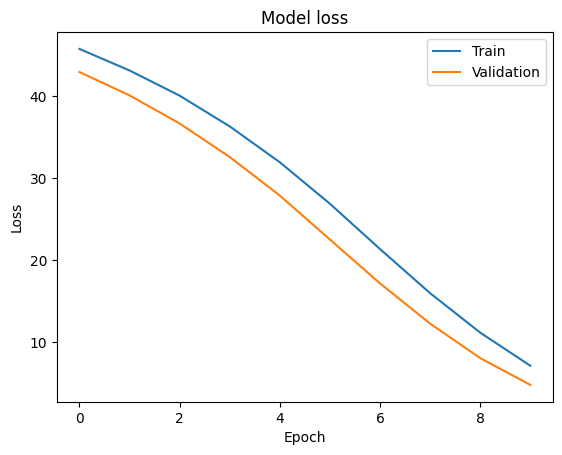

27.952513780551293
24.480625074676105


In [ ]:
import matplotlib.pyplot as plt

avg_train_loss=np.divide(results_train_loss,len(GE_Profile_WGS.columns)-300)
avg_train_val_loss=np.divide(results_train_val_loss,len(GE_Profile_WGS.columns)-300)
plt.plot(avg_train_loss)
plt.plot(avg_train_val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

print(np.average(avg_train_loss))
print(np.average(avg_train_val_loss))

In [ ]:
FinalRNA

RAPGEF4      WIPF1       ATF2       OLA1  \
C3L-00004-01               10.585259  12.009101  11.555851  11.000169   
C3L-00004-06                9.837918  10.102125  11.383688  10.939663   
C3L-00010-01               11.834555  11.772883  11.902942  11.424068   
C3L-00010-06                9.867837  10.416675  11.849286  11.084363   
C3L-00011-01                9.877673  10.959537  12.335053  12.108576   
...                              ...        ...        ...        ...   
C3N-01649-10                9.640226  10.126035  11.437979  10.804045   
C3N-01651-01               10.684795  11.055052  12.061115  11.240361   
C3N-01651-10                9.856275  10.336971  10.822210  10.385908   
C3N-01808-02;C3N-01808-03  10.709789  11.011129  11.851661  11.205081   
C3N-01808-06               10.149395  10.636734  11.420717  10.862167   

                                CIR1        SP3  
C3L-00004-01                9.960479  12.462321  
C3L-00004-06                9.683022  12.002336  
C3L-00010-01               10.409389  12.754598  
C3L-00010-06               10.224367  12.425042  
C3L-00011-01               10.250800  13.216052  
...                              ...        ...  
C3N-01649-10                9.843078  11.963368  
C3N-01651-01               10.049900  13.127466  
C3N-01651-10                9.156643  11.562198  
C3N-01808-02;C3N-01808-03   9.530847  12.574964  
C3N-01808-06                9.598275  11.982983  

[164 rows x 6 columns]

In [ ]:
FinalProteins

RAPGEF4  WIPF1  ATF2  OLA1  CIR1   SP3
C3L-00004-01                 -0.45   0.71  0.25  0.03 -0.08  0.25
C3L-00004-06                  0.02  -0.57 -0.26 -0.10 -0.11 -0.23
C3L-00010-01                  0.61   0.16  0.05  0.05  0.20  0.04
C3L-00010-06                 -0.15  -0.64 -0.22 -0.11 -0.08 -0.03
C3L-00011-01                 -0.05  -0.05  0.30  0.49  0.19  0.31
...                            ...    ...   ...   ...   ...   ...
C3N-01649-10                 -0.16  -0.52 -0.24 -0.12  0.04 -0.01
C3N-01651-01                 -0.21   0.05  0.66  0.17  0.54  0.47
C3N-01651-10                  0.39  -0.36 -0.17 -0.13 -0.08 -0.15
C3N-01808-02;C3N-01808-03    -0.01   0.21  0.47  0.50  0.35 -0.11
C3N-01808-06                  0.05  -0.47 -0.26 -0.01 -0.20  0.00

[164 rows x 6 columns]

In [ ]:
result_CI_DML_df2

Feature                   Intersected Gene-Proteins  \
0        cg07176692  RSBN1,CAPZA1,WNT2B,CTTNBP2NL,MOV10,SLC16A1   
1        cg08305942                                CMIP,MAF,GAN   
2        cg11171825                   CUL7,TBCC,MEA1,CNPY3,KLC4   
3     ch.15.934240F                    RAB8B,PPIB,RBPMS2,ZNF609   
4        cg02849507                                 BFAR,RSL1D1   
..              ...                                         ...   
301      cg06457408                            ARHGDIA,HGS,P4HB   
302      cg04688368                                      KCNMA1   
303      cg04005677                   WDR24,CHTF18,RHOT2,RAB40C   
304  ch.19.1271107R            SIRT2,MAP4K1,ACTN4,LGALS4,FBXO17   
305           State                                               

    Len Significant Intersected Gene-Proteins  \
0                                           5   
1                                           1   
2                                           5   
3                                           3   
4                                           2   
..                                        ...   
301                                         2   
302                                         1   
303                                         4   
304                                         4   
305                                         0   

    Significant Intersected Gene-Proteins Integrated Genes Integrated Proteins  
0    RSBN1,CAPZA1,WNT2B,CTTNBP2NL,SLC16A1                9                   6  
1                                     GAN                6                   3  
2               CUL7,TBCC,MEA1,CNPY3,KLC4                5                   5  
3                       RAB8B,PPIB,RBPMS2                7                   4  
4                             BFAR,RSL1D1                6                   2  
..                                    ...              ...                 ...  
301                              HGS,P4HB                5                   3  
302                                KCNMA1                1                   1  
303             WDR24,CHTF18,RHOT2,RAB40C               10                   4  
304             SIRT2,MAP4K1,ACTN4,FBXO17                6                   5  
305                                                      0                   0  

[306 rows x 6 columns]

In [ ]:
result_CI_DML_df

Feature                          Intersected Gene-Proteins  \
0   cg08223924  PTBP1,WDR18,RNF126,MISP,ARID3A,AZU1,MED16,TMEM...   
1   cg11864327                            HNRNPH1,ZNF354A,HNRNPAB   
2   cg11886405                                  APLP2,ST14,NCAPD3   
3   cg13897627  DNAJA2,LONP2,N4BP1,ITFG1,HEATR3,BRD7,SIAH1,CNE...   
4   cg24576995                                  UBE3C,NOM1,NCAPG2   
5   cg11582484                                     UBE3A,GOLGA6L2   
6   cg03421657                  POGK,UCK2,TMCO1,POU2F1,TADA1,PBX1   
7   cg16971991                                                      
8   cg08337166                            SART3,CORO1C,RIC8B,PWP1   
9   cg06566239                         GLRX3,STK32C,PPP2R2D,BNIP3   
10  cg11820931     CCAR1,HNRNPH3,DDX50,VPS26A,SUPV3L1,HKDC1,DDX21   
11  cg26202762                                     UBE3A,GOLGA6L2   
12  cg17157798                     SFSWAP,SCARB1,RAN,DHX37,BRI3BP   
13  cg20979737  SDCCAG8,DESI2,HNRNPU,AHCTF1,TFB2M,CNST,SMYD3,C...   
14  cg16151261                                       CTDP1,TXNL4A   
15  cg01807825                               HNRNPD,HNRNPDL,MRPL1   
16  cg04094178                 TP73,WRAP73,LRRC47,TPRG1L,C1orf174   
17  cg00629625                                      SLC35C2,PCIF1   
18  cg01970336  OSBPL9,TXNDC12,RNF11,BTF3L4,CC2D1B,ZFYVE9,RAB3...   
19  cg27203983                                         MEFV,THOC6   
20  cg24069602                    PSMC5,FTSJ3,SMARCD2,POLG2,CEP95   
21  cg00576086        BRD9,CLPTM1L,TRIP13,NDUFS6,LPCAT1,IRX2,TPPP   
22  cg03267139                                        CCNT2,MGAT5   
23  cg05081953                  GPD2,ACVR1,ARL6IP6,WDSUB1,PRPF40A   
24  cg10648542                            HNRNPH1,ZNF354A,HNRNPAB   
25  cg13555050                      GAR1,AP1AR,CASP6,CAMK2D,LARP7   
26  cg09853702                   RPAP3,SLC38A1,VDR,SLC38A2,COL2A1   
27  cg01573635  CLEC16A,PMM2,CARHSP1,RMI2,C16orf72,ABAT,TMEM18...   
28  cg27537125                                        RUNX3,SRRM1   
29  cg09873544                   GLRX3,MKI67,STK32C,PPP2R2D,BNIP3   
30  cg05579652                                                      
31  cg09596131                   PUM2,SDC1,HS1BP3,SMC6,VSNL1,GEN1   
32  cg27219221       TPX2,PDRG1,TM9SF4,POFUT1,KIF3B,PLAGL2,BCL2L1   
33  cg10020892                                             GPR89A   
34  cg05068848                                 PI4K2B,DHX15,MED28   
35  cg19319037  CD58,CD2,TTF2,WARS2,PTGFRN,CD101,IGSF3,ATP1A1,...   
36  cg02301740                                                      
37  cg27583655                                        ERCC8,GPBP1   
38  cg07691684              CD38,NCAPG,MED28,FGFBP1,FGFBP2,DCAF16   
39  cg05516390  GLG1,DHODH,PSMD7,PMFBP1,DHX38,TXNL4B,ZFHX3,IST...   
40  cg07163845      HSP90AA1,AKT1,PACS2,MTA1,NUDT14,BRF1,CDC42BPB   
41  cg18025409                                         VAMP3,ENO1   
42  cg23156348                                   STT3A,EI24,CHEK1   
43  cg22641201                                    TFAM,ZWINT,CDK1   
44       State                                                      

   Integrated Genes Integrated Proteins  
0                11                   9  
1                 3                   3  
2                 4                   3  
3                10                   8  
4                 4                   3  
5                 7                   2  
6                 7                   6  
7                 0                   0  
8                 7                   4  
9                 5                   4  
10               10                   7  
11                6                   2  
12                7                   5  
13                9                   9  
14                4                   2  
15                5                   3  
16                9                   5  
17                4                   2  
18                8               

In [ ]:
GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['State']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['State']
#GE_Profile_WGS=GE_Profile_WGS.drop('Label',axis=1)

NameError: name 'CancerType' is not defined

In [ ]:
Treatment_State.value_counts()

State
0    96
1    84
Name: count, dtype: int64

#DoWhy

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier


temp_cols=GE_Profile_WGS.columns.tolist()
index=GE_Profile_WGS.columns.get_loc("State")
new_cols=temp_cols[index:index+1] + temp_cols[0:index] + temp_cols[index+1:]
GE_Profile_WGS=GE_Profile_WGS[new_cols]
GE_Profile_WGS['State']=GE_Profile_WGS['State'].astype('bool')
GE_Profile_WGS['TargetGene']=""
temp_cols=GE_Profile_WGS.columns.tolist()
index=GE_Profile_WGS.columns.get_loc('TargetGene')
new_cols=temp_cols[index:index+1] + temp_cols[0:index] + temp_cols[index+1:]
GE_Profile_WGS=GE_Profile_WGS[new_cols]

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})


for col in range (2,len(GE_Profile_WGS.columns)):

      TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]

      ci_per_feature=[]
      for tg in TargetGenes.columns:

        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        print("The feature:",GE_Profile_WGS.columns.to_list()[col],"The targeted gene:",tg)

        model= CausalModel(
              data = GE_Profile_WGS,
              treatment='State',
              outcome='TargetGene',
              common_causes=[GE_Profile_WGS.columns.to_list()[col]]
              )
        #model.view_model(layout="dot")
        #from IPython.display import Image, display
        #display(Image(filename="causal_model.png"))

        identified_estimand = model.identify_effect(proceed_when_unidentifiable=True, method_name="maximal-adjustment")
        print(identified_estimand)

        #print("ATE", np.mean(data_1["State"])- np.mean(data_0["State"]))

        dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                method_params={"init_params":{
                                    'discrete_treatment':True,
                                    'model_y':KNeighborsRegressor(n_neighbors=5), #KNeighborsRegressor(n_neighbors=5),
                                    'model_t':KNeighborsClassifier(n_neighbors=5), #KNeighborsRegressor(n_neighbors=5),
                                    'model_final':StatsModelsLinearRegression(fit_intercept=False), #KNeighborsRegressor(n_neighbors=5),
                                    'random_state':987654321
                                               },
                                    "fit_params":{}})
        print(dml_estimate)
        print("Double ML Causal Estimate is " + str(dml_estimate.value))
        ci_per_feature.append(dml_estimate.value)
        result_CI_Per_Gene_dml_df = result_CI_Per_Gene_dml_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col],'Target_Gene':tg, 'Estimate_DML': str(round(dml_estimate.value,4))}, ignore_index=True)

      if(len(ci_per_feature)>0):
        result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_DML': str(round(sum(ci_per_feature)/len(ci_per_feature),4))}, ignore_index=True)
      else:
        result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_DML': str(0)}, ignore_index=True)


The feature: cg08223924 The targeted gene: PTBP1
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.17687789458752068
Effect estimates: [0.17687789 0.17687789 0.17687789 0.17687789 0.17687789 0.17687789
 0.17687789 0.17687789 0.17687789 0.17687789 0.17687789 0.17687789
 0.17687789 0.17687789 0.17687789 0.17687789 0.17687789 0.17687789
 0.17687789 0.17687789 0.17687789 0.17687789 0.17687789 0.17687789
 0.17687789 0.17687789 0.17687789 0.17687789 0.17687789 0.17687789
 0.17687789 0.17687789 0.17687789 0.17687789 0.17687789 0.17687789
 0.17687789 0.17687789 0.17687789 0.17687789 0.17687789 0.17687

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: -0.07542615638866812
Effect estimates: [-0.07542616 -0.07542616 -0.07542616 -0.07542616 -0.07542616 -0.07542616
 -0.07542616 -0.07542616 -0.07542616 -0.07542616 -0.07542616 -0.07542616
 -0.07542616 -0.07542616 -0.07542616 -0.07542616 -0.07542616 -0.07542616
 -0.07542616 -0.07542616 -0.07542616 -0.07542616 -0.07542616 -0.07542616
 -0.07542616 -0.07542616 -0.07542616 -0.07542616 -0.07542616 -0.07542616
 -0.07542616 -0.07542616 -0.07542616 -0.07542616 -0.07542616 -0.07542616
 -0.07542616 -0.07542616 -0.07542616 -0.07542616 -0.07542616 -0.07542616
 -

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: -0.3601486014057672
Effect estimates: [-0.3601486 -0.3601486 -0.3601486 -0.3601486 -0.3601486 -0.3601486
 -0.3601486 -0.3601486 -0.3601486 -0.3601486 -0.3601486 -0.3601486
 -0.3601486 -0.3601486 -0.3601486 -0.3601486 -0.3601486 -0.3601486
 -0.3601486 -0.3601486 -0.3601486 -0.3601486 -0.3601486 -0.3601486
 -0.3601486 -0.3601486 -0.3601486 -0.3601486 -0.3601486 -0.3601486
 -0.3601486 -0.3601486 -0.3601486 -0.3601486 -0.3601486 -0.3601486
 -0.3601486 -0.3601486 -0.3601486 -0.3601486 -0.3601486 -0.3601486
 -0.3601486 -0.3601486 -0.3601486 -0.3601486 

The feature: cg11864327 The targeted gene: HNRNPH1
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.26975818583968897
Effect estimates: [0.26975819 0.26975819 0.26975819 0.26975819 0.26975819 0.26975819
 0.26975819 0.26975819 0.26975819 0.26975819 0.26975819 0.26975819
 0.26975819 0.26975819 0.26975819 0.26975819 0.26975819 0.26975819
 0.26975819 0.26975819 0.26975819 0.26975819 0.26975819 0.26975819
 0.26975819 0.26975819 0.26975819 0.26975819 0.26975819 0.26975819
 0.26975819 0.26975819 0.26975819 0.26975819 0.26975819 0.26975819
 0.26975819 0.26975819 0.26975819 0.26975819 0.26975819 0.269

The feature: cg11886405 The targeted gene: APLP2
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.22079520609887113
Effect estimates: [0.22079521 0.22079521 0.22079521 0.22079521 0.22079521 0.22079521
 0.22079521 0.22079521 0.22079521 0.22079521 0.22079521 0.22079521
 0.22079521 0.22079521 0.22079521 0.22079521 0.22079521 0.22079521
 0.22079521 0.22079521 0.22079521 0.22079521 0.22079521 0.22079521
 0.22079521 0.22079521 0.22079521 0.22079521 0.22079521 0.22079521
 0.22079521 0.22079521 0.22079521 0.22079521 0.22079521 0.22079521
 0.22079521 0.22079521 0.22079521 0.22079521 0.22079521 0.22079

The feature: cg13897627 The targeted gene: DNAJA2
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: -0.11269879043345794
Effect estimates: [-0.11269879 -0.11269879 -0.11269879 -0.11269879 -0.11269879 -0.11269879
 -0.11269879 -0.11269879 -0.11269879 -0.11269879 -0.11269879 -0.11269879
 -0.11269879 -0.11269879 -0.11269879 -0.11269879 -0.11269879 -0.11269879
 -0.11269879 -0.11269879 -0.11269879 -0.11269879 -0.11269879 -0.11269879
 -0.11269879 -0.11269879 -0.11269879 -0.11269879 -0.11269879 -0.11269879
 -0.11269879 -0.11269879 -0.11269879 -0.11269879 -0.11269879 -0.11269879
 -0.11269879 -0.11269879 

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.6482985825852359
Effect estimates: [0.64829858 0.64829858 0.64829858 0.64829858 0.64829858 0.64829858
 0.64829858 0.64829858 0.64829858 0.64829858 0.64829858 0.64829858
 0.64829858 0.64829858 0.64829858 0.64829858 0.64829858 0.64829858
 0.64829858 0.64829858 0.64829858 0.64829858 0.64829858 0.64829858
 0.64829858 0.64829858 0.64829858 0.64829858 0.64829858 0.64829858
 0.64829858 0.64829858 0.64829858 0.64829858 0.64829858 0.64829858
 0.64829858 0.64829858 0.64829858 0.64829858 0.64829858 0.64829858
 0.64829858 0.64829858 0.64829858 0.64829858 0

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 1.2050223692681823
Effect estimates: [1.20502237 1.20502237 1.20502237 1.20502237 1.20502237 1.20502237
 1.20502237 1.20502237 1.20502237 1.20502237 1.20502237 1.20502237
 1.20502237 1.20502237 1.20502237 1.20502237 1.20502237 1.20502237
 1.20502237 1.20502237 1.20502237 1.20502237 1.20502237 1.20502237
 1.20502237 1.20502237 1.20502237 1.20502237 1.20502237 1.20502237
 1.20502237 1.20502237 1.20502237 1.20502237 1.20502237 1.20502237
 1.20502237 1.20502237 1.20502237 1.20502237 1.20502237 1.20502237
 1.20502237 1.20502237 1.20502237 1.20502237 1

The feature: cg24576995 The targeted gene: UBE3C
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.21287028530403843
Effect estimates: [0.21287029 0.21287029 0.21287029 0.21287029 0.21287029 0.21287029
 0.21287029 0.21287029 0.21287029 0.21287029 0.21287029 0.21287029
 0.21287029 0.21287029 0.21287029 0.21287029 0.21287029 0.21287029
 0.21287029 0.21287029 0.21287029 0.21287029 0.21287029 0.21287029
 0.21287029 0.21287029 0.21287029 0.21287029 0.21287029 0.21287029
 0.21287029 0.21287029 0.21287029 0.21287029 0.21287029 0.21287029
 0.21287029 0.21287029 0.21287029 0.21287029 0.21287029 0.21287

The feature: cg11582484 The targeted gene: UBE3A
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.09125351841601126
Effect estimates: [0.09125352 0.09125352 0.09125352 0.09125352 0.09125352 0.09125352
 0.09125352 0.09125352 0.09125352 0.09125352 0.09125352 0.09125352
 0.09125352 0.09125352 0.09125352 0.09125352 0.09125352 0.09125352
 0.09125352 0.09125352 0.09125352 0.09125352 0.09125352 0.09125352
 0.09125352 0.09125352 0.09125352 0.09125352 0.09125352 0.09125352
 0.09125352 0.09125352 0.09125352 0.09125352 0.09125352 0.09125352
 0.09125352 0.09125352 0.09125352 0.09125352 0.09125352 0.09125

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: -0.02526852677283648
Effect estimates: [-0.02526853 -0.02526853 -0.02526853 -0.02526853 -0.02526853 -0.02526853
 -0.02526853 -0.02526853 -0.02526853 -0.02526853 -0.02526853 -0.02526853
 -0.02526853 -0.02526853 -0.02526853 -0.02526853 -0.02526853 -0.02526853
 -0.02526853 -0.02526853 -0.02526853 -0.02526853 -0.02526853 -0.02526853
 -0.02526853 -0.02526853 -0.02526853 -0.02526853 -0.02526853 -0.02526853
 -0.02526853 -0.02526853 -0.02526853 -0.02526853 -0.02526853 -0.02526853
 -0.02526853 -0.02526853 -0.02526853 -0.02526853 -0.02526853 -0.02526853
 -

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.12442425176988799
Effect estimates: [0.12442425 0.12442425 0.12442425 0.12442425 0.12442425 0.12442425
 0.12442425 0.12442425 0.12442425 0.12442425 0.12442425 0.12442425
 0.12442425 0.12442425 0.12442425 0.12442425 0.12442425 0.12442425
 0.12442425 0.12442425 0.12442425 0.12442425 0.12442425 0.12442425
 0.12442425 0.12442425 0.12442425 0.12442425 0.12442425 0.12442425
 0.12442425 0.12442425 0.12442425 0.12442425 0.12442425 0.12442425
 0.12442425 0.12442425 0.12442425 0.12442425 0.12442425 0.12442425
 0.12442425 0.12442425 0.12442425 0.12442425 

 cg03421657 The targeted gene: PBX1
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: -1.0854119469927332
Effect estimates: [-1.08541195 -1.08541195 -1.08541195 -1.08541195 -1.08541195 -1.08541195
 -1.08541195 -1.08541195 -1.08541195 -1.08541195 -1.08541195 -1.08541195
 -1.08541195 -1.08541195 -1.08541195 -1.08541195 -1.08541195 -1.08541195
 -1.08541195 -1.08541195 -1.08541195 -1.08541195 -1.08541195 -1.08541195
 -1.08541195 -1.08541195 -1.08541195 -1.08541195 -1.08541195 -1.08541195
 -1.08541195 -1.08541195 -1.08541195 -1.08541195 -1.08541195 -1.08541195
 -1.08541195 -1.08541195 -1.08541195 -1.

The feature: cg08337166 The targeted gene: WSCD2
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: -0.7473497079803944
Effect estimates: [-0.74734971 -0.74734971 -0.74734971 -0.74734971 -0.74734971 -0.74734971
 -0.74734971 -0.74734971 -0.74734971 -0.74734971 -0.74734971 -0.74734971
 -0.74734971 -0.74734971 -0.74734971 -0.74734971 -0.74734971 -0.74734971
 -0.74734971 -0.74734971 -0.74734971 -0.74734971 -0.74734971 -0.74734971
 -0.74734971 -0.74734971 -0.74734971 -0.74734971 -0.74734971 -0.74734971
 -0.74734971 -0.74734971 -0.74734971 -0.74734971 -0.74734971 -0.74734971
 -0.74734971 -0.74734971 -0

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.22095101921974483
Effect estimates: [0.22095102 0.22095102 0.22095102 0.22095102 0.22095102 0.22095102
 0.22095102 0.22095102 0.22095102 0.22095102 0.22095102 0.22095102
 0.22095102 0.22095102 0.22095102 0.22095102 0.22095102 0.22095102
 0.22095102 0.22095102 0.22095102 0.22095102 0.22095102 0.22095102
 0.22095102 0.22095102 0.22095102 0.22095102 0.22095102 0.22095102
 0.22095102 0.22095102 0.22095102 0.22095102 0.22095102 0.22095102
 0.22095102 0.22095102 0.22095102 0.22095102 0.22095102 0.22095102
 0.22095102 0.22095102 0.22095102 0.22095102 

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.32940679151904334
Effect estimates: [0.32940679 0.32940679 0.32940679 0.32940679 0.32940679 0.32940679
 0.32940679 0.32940679 0.32940679 0.32940679 0.32940679 0.32940679
 0.32940679 0.32940679 0.32940679 0.32940679 0.32940679 0.32940679
 0.32940679 0.32940679 0.32940679 0.32940679 0.32940679 0.32940679
 0.32940679 0.32940679 0.32940679 0.32940679 0.32940679 0.32940679
 0.32940679 0.32940679 0.32940679 0.32940679 0.32940679 0.32940679
 0.32940679 0.32940679 0.32940679 0.32940679 0.32940679 0.32940679
 0.32940679 0.32940679 0.32940679 0.32940679 

The feature: cg11820931 The targeted gene: CCAR1
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.34150226322608856
Effect estimates: [0.34150226 0.34150226 0.34150226 0.34150226 0.34150226 0.34150226
 0.34150226 0.34150226 0.34150226 0.34150226 0.34150226 0.34150226
 0.34150226 0.34150226 0.34150226 0.34150226 0.34150226 0.34150226
 0.34150226 0.34150226 0.34150226 0.34150226 0.34150226 0.34150226
 0.34150226 0.34150226 0.34150226 0.34150226 0.34150226 0.34150226
 0.34150226 0.34150226 0.34150226 0.34150226 0.34150226 0.34150226
 0.34150226 0.34150226 0.34150226 0.34150226 0.34150226 0.34150

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.7751275124045414
Effect estimates: [0.77512751 0.77512751 0.77512751 0.77512751 0.77512751 0.77512751
 0.77512751 0.77512751 0.77512751 0.77512751 0.77512751 0.77512751
 0.77512751 0.77512751 0.77512751 0.77512751 0.77512751 0.77512751
 0.77512751 0.77512751 0.77512751 0.77512751 0.77512751 0.77512751
 0.77512751 0.77512751 0.77512751 0.77512751 0.77512751 0.77512751
 0.77512751 0.77512751 0.77512751 0.77512751 0.77512751 0.77512751
 0.77512751 0.77512751 0.77512751 0.77512751 0.77512751 0.77512751
 0.77512751 0.77512751 0.77512751 0.77512751 0

The feature: cg26202762 The targeted gene: UBE3A
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.09125351841601126
Effect estimates: [0.09125352 0.09125352 0.09125352 0.09125352 0.09125352 0.09125352
 0.09125352 0.09125352 0.09125352 0.09125352 0.09125352 0.09125352
 0.09125352 0.09125352 0.09125352 0.09125352 0.09125352 0.09125352
 0.09125352 0.09125352 0.09125352 0.09125352 0.09125352 0.09125352
 0.09125352 0.09125352 0.09125352 0.09125352 0.09125352 0.09125352
 0.09125352 0.09125352 0.09125352 0.09125352 0.09125352 0.09125352
 0.09125352 0.09125352 0.09125352 0.09125352 0.09125352 0.09125

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: -0.30948471838474084
Effect estimates: [-0.30948472 -0.30948472 -0.30948472 -0.30948472 -0.30948472 -0.30948472
 -0.30948472 -0.30948472 -0.30948472 -0.30948472 -0.30948472 -0.30948472
 -0.30948472 -0.30948472 -0.30948472 -0.30948472 -0.30948472 -0.30948472
 -0.30948472 -0.30948472 -0.30948472 -0.30948472 -0.30948472 -0.30948472
 -0.30948472 -0.30948472 -0.30948472 -0.30948472 -0.30948472 -0.30948472
 -0.30948472 -0.30948472 -0.30948472 -0.30948472 -0.30948472 -0.30948472
 -0.30948472 -0.30948472 -0.30948472 -0.30948472 -0.30948472 -0.30948472
 -

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.5712728254370305
Effect estimates: [0.57127283 0.57127283 0.57127283 0.57127283 0.57127283 0.57127283
 0.57127283 0.57127283 0.57127283 0.57127283 0.57127283 0.57127283
 0.57127283 0.57127283 0.57127283 0.57127283 0.57127283 0.57127283
 0.57127283 0.57127283 0.57127283 0.57127283 0.57127283 0.57127283
 0.57127283 0.57127283 0.57127283 0.57127283 0.57127283 0.57127283
 0.57127283 0.57127283 0.57127283 0.57127283 0.57127283 0.57127283
 0.57127283 0.57127283 0.57127283 0.57127283 0.57127283 0.57127283
 0.57127283 0.57127283 0.57127283 0.57127283 0

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.32109174831843174
Effect estimates: [0.32109175 0.32109175 0.32109175 0.32109175 0.32109175 0.32109175
 0.32109175 0.32109175 0.32109175 0.32109175 0.32109175 0.32109175
 0.32109175 0.32109175 0.32109175 0.32109175 0.32109175 0.32109175
 0.32109175 0.32109175 0.32109175 0.32109175 0.32109175 0.32109175
 0.32109175 0.32109175 0.32109175 0.32109175 0.32109175 0.32109175
 0.32109175 0.32109175 0.32109175 0.32109175 0.32109175 0.32109175
 0.32109175 0.32109175 0.32109175 0.32109175 0.32109175 0.32109175
 0.32109175 0.32109175 0.32109175 0.32109175 

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.28798782241871634
Effect estimates: [0.28798782 0.28798782 0.28798782 0.28798782 0.28798782 0.28798782
 0.28798782 0.28798782 0.28798782 0.28798782 0.28798782 0.28798782
 0.28798782 0.28798782 0.28798782 0.28798782 0.28798782 0.28798782
 0.28798782 0.28798782 0.28798782 0.28798782 0.28798782 0.28798782
 0.28798782 0.28798782 0.28798782 0.28798782 0.28798782 0.28798782
 0.28798782 0.28798782 0.28798782 0.28798782 0.28798782 0.28798782
 0.28798782 0.28798782 0.28798782 0.28798782 0.28798782 0.28798782
 0.28798782 0.28798782 0.28798782 0.28798782 

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: -0.35219553154155026
Effect estimates: [-0.35219553 -0.35219553 -0.35219553 -0.35219553 -0.35219553 -0.35219553
 -0.35219553 -0.35219553 -0.35219553 -0.35219553 -0.35219553 -0.35219553
 -0.35219553 -0.35219553 -0.35219553 -0.35219553 -0.35219553 -0.35219553
 -0.35219553 -0.35219553 -0.35219553 -0.35219553 -0.35219553 -0.35219553
 -0.35219553 -0.35219553 -0.35219553 -0.35219553 -0.35219553 -0.35219553
 -0.35219553 -0.35219553 -0.35219553 -0.35219553 -0.35219553 -0.35219553
 -0.35219553 -0.35219553 -0.35219553 -0.35219553 -0.35219553 -0.35219553
 -

The feature: cg16151261 The targeted gene: CTDP1
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.05335434491756525
Effect estimates: [0.05335434 0.05335434 0.05335434 0.05335434 0.05335434 0.05335434
 0.05335434 0.05335434 0.05335434 0.05335434 0.05335434 0.05335434
 0.05335434 0.05335434 0.05335434 0.05335434 0.05335434 0.05335434
 0.05335434 0.05335434 0.05335434 0.05335434 0.05335434 0.05335434
 0.05335434 0.05335434 0.05335434 0.05335434 0.05335434 0.05335434
 0.05335434 0.05335434 0.05335434 0.05335434 0.05335434 0.05335434
 0.05335434 0.05335434 0.05335434 0.05335434 0.05335434 0.05335

The feature: cg01807825 The targeted gene: HNRNPD
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.2641449530805357
Effect estimates: [0.26414495 0.26414495 0.26414495 0.26414495 0.26414495 0.26414495
 0.26414495 0.26414495 0.26414495 0.26414495 0.26414495 0.26414495
 0.26414495 0.26414495 0.26414495 0.26414495 0.26414495 0.26414495
 0.26414495 0.26414495 0.26414495 0.26414495 0.26414495 0.26414495
 0.26414495 0.26414495 0.26414495 0.26414495 0.26414495 0.26414495
 0.26414495 0.26414495 0.26414495 0.26414495 0.26414495 0.26414495
 0.26414495 0.26414495 0.26414495 0.26414495 0.26414495 0.26414

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.17785973630908264
Effect estimates: [0.17785974 0.17785974 0.17785974 0.17785974 0.17785974 0.17785974
 0.17785974 0.17785974 0.17785974 0.17785974 0.17785974 0.17785974
 0.17785974 0.17785974 0.17785974 0.17785974 0.17785974 0.17785974
 0.17785974 0.17785974 0.17785974 0.17785974 0.17785974 0.17785974
 0.17785974 0.17785974 0.17785974 0.17785974 0.17785974 0.17785974
 0.17785974 0.17785974 0.17785974 0.17785974 0.17785974 0.17785974
 0.17785974 0.17785974 0.17785974 0.17785974 0.17785974 0.17785974
 0.17785974 0.17785974 0.17785974 0.17785974 

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.21984802417025714
Effect estimates: [0.21984802 0.21984802 0.21984802 0.21984802 0.21984802 0.21984802
 0.21984802 0.21984802 0.21984802 0.21984802 0.21984802 0.21984802
 0.21984802 0.21984802 0.21984802 0.21984802 0.21984802 0.21984802
 0.21984802 0.21984802 0.21984802 0.21984802 0.21984802 0.21984802
 0.21984802 0.21984802 0.21984802 0.21984802 0.21984802 0.21984802
 0.21984802 0.21984802 0.21984802 0.21984802 0.21984802 0.21984802
 0.21984802 0.21984802 0.21984802 0.21984802 0.21984802 0.21984802
 0.21984802 0.21984802 0.21984802 0.21984802 

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.06148617917281885
Effect estimates: [0.06148618 0.06148618 0.06148618 0.06148618 0.06148618 0.06148618
 0.06148618 0.06148618 0.06148618 0.06148618 0.06148618 0.06148618
 0.06148618 0.06148618 0.06148618 0.06148618 0.06148618 0.06148618
 0.06148618 0.06148618 0.06148618 0.06148618 0.06148618 0.06148618
 0.06148618 0.06148618 0.06148618 0.06148618 0.06148618 0.06148618
 0.06148618 0.06148618 0.06148618 0.06148618 0.06148618 0.06148618
 0.06148618 0.06148618 0.06148618 0.06148618 0.06148618 0.06148618
 0.06148618 0.06148618 0.06148618 0.06148618 

The feature: cg00629625 The targeted gene: SLC35C2
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.17833147513707176
Effect estimates: [0.17833148 0.17833148 0.17833148 0.17833148 0.17833148 0.17833148
 0.17833148 0.17833148 0.17833148 0.17833148 0.17833148 0.17833148
 0.17833148 0.17833148 0.17833148 0.17833148 0.17833148 0.17833148
 0.17833148 0.17833148 0.17833148 0.17833148 0.17833148 0.17833148
 0.17833148 0.17833148 0.17833148 0.17833148 0.17833148 0.17833148
 0.17833148 0.17833148 0.17833148 0.17833148 0.17833148 0.17833148
 0.17833148 0.17833148 0.17833148 0.17833148 0.17833148 0.178

The feature: cg01970336 The targeted gene: OSBPL9
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.11968939223627185
Effect estimates: [0.11968939 0.11968939 0.11968939 0.11968939 0.11968939 0.11968939
 0.11968939 0.11968939 0.11968939 0.11968939 0.11968939 0.11968939
 0.11968939 0.11968939 0.11968939 0.11968939 0.11968939 0.11968939
 0.11968939 0.11968939 0.11968939 0.11968939 0.11968939 0.11968939
 0.11968939 0.11968939 0.11968939 0.11968939 0.11968939 0.11968939
 0.11968939 0.11968939 0.11968939 0.11968939 0.11968939 0.11968939
 0.11968939 0.11968939 0.11968939 0.11968939 0.11968939 0.1196

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.1267473196623594
Effect estimates: [0.12674732 0.12674732 0.12674732 0.12674732 0.12674732 0.12674732
 0.12674732 0.12674732 0.12674732 0.12674732 0.12674732 0.12674732
 0.12674732 0.12674732 0.12674732 0.12674732 0.12674732 0.12674732
 0.12674732 0.12674732 0.12674732 0.12674732 0.12674732 0.12674732
 0.12674732 0.12674732 0.12674732 0.12674732 0.12674732 0.12674732
 0.12674732 0.12674732 0.12674732 0.12674732 0.12674732 0.12674732
 0.12674732 0.12674732 0.12674732 0.12674732 0.12674732 0.12674732
 0.12674732 0.12674732 0.12674732 0.12674732 0

The feature: cg27203983 The targeted gene: ZNF200
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.3898618550853389
Effect estimates: [0.38986186 0.38986186 0.38986186 0.38986186 0.38986186 0.38986186
 0.38986186 0.38986186 0.38986186 0.38986186 0.38986186 0.38986186
 0.38986186 0.38986186 0.38986186 0.38986186 0.38986186 0.38986186
 0.38986186 0.38986186 0.38986186 0.38986186 0.38986186 0.38986186
 0.38986186 0.38986186 0.38986186 0.38986186 0.38986186 0.38986186
 0.38986186 0.38986186 0.38986186 0.38986186 0.38986186 0.38986186
 0.38986186 0.38986186 0.38986186 0.38986186 0.38986186 0.38986

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.7008296403083883
Effect estimates: [0.70082964 0.70082964 0.70082964 0.70082964 0.70082964 0.70082964
 0.70082964 0.70082964 0.70082964 0.70082964 0.70082964 0.70082964
 0.70082964 0.70082964 0.70082964 0.70082964 0.70082964 0.70082964
 0.70082964 0.70082964 0.70082964 0.70082964 0.70082964 0.70082964
 0.70082964 0.70082964 0.70082964 0.70082964 0.70082964 0.70082964
 0.70082964 0.70082964 0.70082964 0.70082964 0.70082964 0.70082964
 0.70082964 0.70082964 0.70082964 0.70082964 0.70082964 0.70082964
 0.70082964 0.70082964 0.70082964 0.70082964 0

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.11624237951335485
Effect estimates: [0.11624238 0.11624238 0.11624238 0.11624238 0.11624238 0.11624238
 0.11624238 0.11624238 0.11624238 0.11624238 0.11624238 0.11624238
 0.11624238 0.11624238 0.11624238 0.11624238 0.11624238 0.11624238
 0.11624238 0.11624238 0.11624238 0.11624238 0.11624238 0.11624238
 0.11624238 0.11624238 0.11624238 0.11624238 0.11624238 0.11624238
 0.11624238 0.11624238 0.11624238 0.11624238 0.11624238 0.11624238
 0.11624238 0.11624238 0.11624238 0.11624238 0.11624238 0.11624238
 0.11624238 0.11624238 0.11624238 0.11624238 

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: -0.0917320789107856
Effect estimates: [-0.09173208 -0.09173208 -0.09173208 -0.09173208 -0.09173208 -0.09173208
 -0.09173208 -0.09173208 -0.09173208 -0.09173208 -0.09173208 -0.09173208
 -0.09173208 -0.09173208 -0.09173208 -0.09173208 -0.09173208 -0.09173208
 -0.09173208 -0.09173208 -0.09173208 -0.09173208 -0.09173208 -0.09173208
 -0.09173208 -0.09173208 -0.09173208 -0.09173208 -0.09173208 -0.09173208
 -0.09173208 -0.09173208 -0.09173208 -0.09173208 -0.09173208 -0.09173208
 -0.09173208 -0.09173208 -0.09173208 -0.09173208 -0.09173208 -0.09173208
 -0

 cg00576086 The targeted gene: IRX2
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: -0.047360671480837675
Effect estimates: [-0.04736067 -0.04736067 -0.04736067 -0.04736067 -0.04736067 -0.04736067
 -0.04736067 -0.04736067 -0.04736067 -0.04736067 -0.04736067 -0.04736067
 -0.04736067 -0.04736067 -0.04736067 -0.04736067 -0.04736067 -0.04736067
 -0.04736067 -0.04736067 -0.04736067 -0.04736067 -0.04736067 -0.04736067
 -0.04736067 -0.04736067 -0.04736067 -0.04736067 -0.04736067 -0.04736067
 -0.04736067 -0.04736067 -0.04736067 -0.04736067 -0.04736067 -0.04736067
 -0.04736067 -0.04736067 -0.04736067 -

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: -0.02496602342011794
Effect estimates: [-0.02496602 -0.02496602 -0.02496602 -0.02496602 -0.02496602 -0.02496602
 -0.02496602 -0.02496602 -0.02496602 -0.02496602 -0.02496602 -0.02496602
 -0.02496602 -0.02496602 -0.02496602 -0.02496602 -0.02496602 -0.02496602
 -0.02496602 -0.02496602 -0.02496602 -0.02496602 -0.02496602 -0.02496602
 -0.02496602 -0.02496602 -0.02496602 -0.02496602 -0.02496602 -0.02496602
 -0.02496602 -0.02496602 -0.02496602 -0.02496602 -0.02496602 -0.02496602
 -0.02496602 -0.02496602 -0.02496602 -0.02496602 -0.02496602 -0.02496602
 -

The feature: cg03267139 The targeted gene: CCNT2
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.2317766159387751
Effect estimates: [0.23177662 0.23177662 0.23177662 0.23177662 0.23177662 0.23177662
 0.23177662 0.23177662 0.23177662 0.23177662 0.23177662 0.23177662
 0.23177662 0.23177662 0.23177662 0.23177662 0.23177662 0.23177662
 0.23177662 0.23177662 0.23177662 0.23177662 0.23177662 0.23177662
 0.23177662 0.23177662 0.23177662 0.23177662 0.23177662 0.23177662
 0.23177662 0.23177662 0.23177662 0.23177662 0.23177662 0.23177662
 0.23177662 0.23177662 0.23177662 0.23177662 0.23177662 0.231776

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: -0.33724861366631165
Effect estimates: [-0.33724861 -0.33724861 -0.33724861 -0.33724861 -0.33724861 -0.33724861
 -0.33724861 -0.33724861 -0.33724861 -0.33724861 -0.33724861 -0.33724861
 -0.33724861 -0.33724861 -0.33724861 -0.33724861 -0.33724861 -0.33724861
 -0.33724861 -0.33724861 -0.33724861 -0.33724861 -0.33724861 -0.33724861
 -0.33724861 -0.33724861 -0.33724861 -0.33724861 -0.33724861 -0.33724861
 -0.33724861 -0.33724861 -0.33724861 -0.33724861 -0.33724861 -0.33724861
 -0.33724861 -0.33724861 -0.33724861 -0.33724861 -0.33724861 -0.33724861
 -

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.17905176793715552
Effect estimates: [0.17905177 0.17905177 0.17905177 0.17905177 0.17905177 0.17905177
 0.17905177 0.17905177 0.17905177 0.17905177 0.17905177 0.17905177
 0.17905177 0.17905177 0.17905177 0.17905177 0.17905177 0.17905177
 0.17905177 0.17905177 0.17905177 0.17905177 0.17905177 0.17905177
 0.17905177 0.17905177 0.17905177 0.17905177 0.17905177 0.17905177
 0.17905177 0.17905177 0.17905177 0.17905177 0.17905177 0.17905177
 0.17905177 0.17905177 0.17905177 0.17905177 0.17905177 0.17905177
 0.17905177 0.17905177 0.17905177 0.17905177 

The feature: cg10648542 The targeted gene: HNRNPH1
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.26975818583968897
Effect estimates: [0.26975819 0.26975819 0.26975819 0.26975819 0.26975819 0.26975819
 0.26975819 0.26975819 0.26975819 0.26975819 0.26975819 0.26975819
 0.26975819 0.26975819 0.26975819 0.26975819 0.26975819 0.26975819
 0.26975819 0.26975819 0.26975819 0.26975819 0.26975819 0.26975819
 0.26975819 0.26975819 0.26975819 0.26975819 0.26975819 0.26975819
 0.26975819 0.26975819 0.26975819 0.26975819 0.26975819 0.26975819
 0.26975819 0.26975819 0.26975819 0.26975819 0.26975819 0.269

The feature: cg13555050 The targeted gene: GAR1
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.4112153967830557
Effect estimates: [0.4112154 0.4112154 0.4112154 0.4112154 0.4112154 0.4112154 0.4112154
 0.4112154 0.4112154 0.4112154 0.4112154 0.4112154 0.4112154 0.4112154
 0.4112154 0.4112154 0.4112154 0.4112154 0.4112154 0.4112154 0.4112154
 0.4112154 0.4112154 0.4112154 0.4112154 0.4112154 0.4112154 0.4112154
 0.4112154 0.4112154 0.4112154 0.4112154 0.4112154 0.4112154 0.4112154
 0.4112154 0.4112154 0.4112154 0.4112154 0.4112154 0.4112154 0.4112154
 0.4112154 0.4112154 0.4112154 0.4112154 

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: -0.3700057850286714
Effect estimates: [-0.37000579 -0.37000579 -0.37000579 -0.37000579 -0.37000579 -0.37000579
 -0.37000579 -0.37000579 -0.37000579 -0.37000579 -0.37000579 -0.37000579
 -0.37000579 -0.37000579 -0.37000579 -0.37000579 -0.37000579 -0.37000579
 -0.37000579 -0.37000579 -0.37000579 -0.37000579 -0.37000579 -0.37000579
 -0.37000579 -0.37000579 -0.37000579 -0.37000579 -0.37000579 -0.37000579
 -0.37000579 -0.37000579 -0.37000579 -0.37000579 -0.37000579 -0.37000579
 -0.37000579 -0.37000579 -0.37000579 -0.37000579 -0.37000579 -0.37000579
 -0

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.2827977316121291
Effect estimates: [0.28279773 0.28279773 0.28279773 0.28279773 0.28279773 0.28279773
 0.28279773 0.28279773 0.28279773 0.28279773 0.28279773 0.28279773
 0.28279773 0.28279773 0.28279773 0.28279773 0.28279773 0.28279773
 0.28279773 0.28279773 0.28279773 0.28279773 0.28279773 0.28279773
 0.28279773 0.28279773 0.28279773 0.28279773 0.28279773 0.28279773
 0.28279773 0.28279773 0.28279773 0.28279773 0.28279773 0.28279773
 0.28279773 0.28279773 0.28279773 0.28279773 0.28279773 0.28279773
 0.28279773 0.28279773 0.28279773 0.28279773 0

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.8619360871568519
Effect estimates: [0.86193609 0.86193609 0.86193609 0.86193609 0.86193609 0.86193609
 0.86193609 0.86193609 0.86193609 0.86193609 0.86193609 0.86193609
 0.86193609 0.86193609 0.86193609 0.86193609 0.86193609 0.86193609
 0.86193609 0.86193609 0.86193609 0.86193609 0.86193609 0.86193609
 0.86193609 0.86193609 0.86193609 0.86193609 0.86193609 0.86193609
 0.86193609 0.86193609 0.86193609 0.86193609 0.86193609 0.86193609
 0.86193609 0.86193609 0.86193609 0.86193609 0.86193609 0.86193609
 0.86193609 0.86193609 0.86193609 0.86193609 0

The feature: cg01573635 The targeted gene: CLEC16A
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.05340059312766076
Effect estimates: [0.05340059 0.05340059 0.05340059 0.05340059 0.05340059 0.05340059
 0.05340059 0.05340059 0.05340059 0.05340059 0.05340059 0.05340059
 0.05340059 0.05340059 0.05340059 0.05340059 0.05340059 0.05340059
 0.05340059 0.05340059 0.05340059 0.05340059 0.05340059 0.05340059
 0.05340059 0.05340059 0.05340059 0.05340059 0.05340059 0.05340059
 0.05340059 0.05340059 0.05340059 0.05340059 0.05340059 0.05340059
 0.05340059 0.05340059 0.05340059 0.05340059 0.05340059 0.053

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.19097262310333193
Effect estimates: [0.19097262 0.19097262 0.19097262 0.19097262 0.19097262 0.19097262
 0.19097262 0.19097262 0.19097262 0.19097262 0.19097262 0.19097262
 0.19097262 0.19097262 0.19097262 0.19097262 0.19097262 0.19097262
 0.19097262 0.19097262 0.19097262 0.19097262 0.19097262 0.19097262
 0.19097262 0.19097262 0.19097262 0.19097262 0.19097262 0.19097262
 0.19097262 0.19097262 0.19097262 0.19097262 0.19097262 0.19097262
 0.19097262 0.19097262 0.19097262 0.19097262 0.19097262 0.19097262
 0.19097262 0.19097262 0.19097262 0.19097262 

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.08877339682201181
Effect estimates: [0.0887734 0.0887734 0.0887734 0.0887734 0.0887734 0.0887734 0.0887734
 0.0887734 0.0887734 0.0887734 0.0887734 0.0887734 0.0887734 0.0887734
 0.0887734 0.0887734 0.0887734 0.0887734 0.0887734 0.0887734 0.0887734
 0.0887734 0.0887734 0.0887734 0.0887734 0.0887734 0.0887734 0.0887734
 0.0887734 0.0887734 0.0887734 0.0887734 0.0887734 0.0887734 0.0887734
 0.0887734 0.0887734 0.0887734 0.0887734 0.0887734 0.0887734 0.0887734
 0.0887734 0.0887734 0.0887734 0.0887734 0.0887734 0.0887734 0.0887734
 0.0887734 0.0887

The feature: cg09873544 The targeted gene: GLRX3
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.32940679151904334
Effect estimates: [0.32940679 0.32940679 0.32940679 0.32940679 0.32940679 0.32940679
 0.32940679 0.32940679 0.32940679 0.32940679 0.32940679 0.32940679
 0.32940679 0.32940679 0.32940679 0.32940679 0.32940679 0.32940679
 0.32940679 0.32940679 0.32940679 0.32940679 0.32940679 0.32940679
 0.32940679 0.32940679 0.32940679 0.32940679 0.32940679 0.32940679
 0.32940679 0.32940679 0.32940679 0.32940679 0.32940679 0.32940679
 0.32940679 0.32940679 0.32940679 0.32940679 0.32940679 0.32940

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.12775000478136264
Effect estimates: [0.12775 0.12775 0.12775 0.12775 0.12775 0.12775 0.12775 0.12775 0.12775
 0.12775 0.12775 0.12775 0.12775 0.12775 0.12775 0.12775 0.12775 0.12775
 0.12775 0.12775 0.12775 0.12775 0.12775 0.12775 0.12775 0.12775 0.12775
 0.12775 0.12775 0.12775 0.12775 0.12775 0.12775 0.12775 0.12775 0.12775
 0.12775 0.12775 0.12775 0.12775 0.12775 0.12775 0.12775 0.12775 0.12775
 0.12775 0.12775 0.12775 0.12775 0.12775 0.12775 0.12775 0.12775 0.12775
 0.12775 0.12775 0.12775 0.12775 0.12775 0.12775 0.12775 0.12775 0.12775
 0.

The feature: cg09596131 The targeted gene: PUM2
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.2512510426072776
Effect estimates: [0.25125104 0.25125104 0.25125104 0.25125104 0.25125104 0.25125104
 0.25125104 0.25125104 0.25125104 0.25125104 0.25125104 0.25125104
 0.25125104 0.25125104 0.25125104 0.25125104 0.25125104 0.25125104
 0.25125104 0.25125104 0.25125104 0.25125104 0.25125104 0.25125104
 0.25125104 0.25125104 0.25125104 0.25125104 0.25125104 0.25125104
 0.25125104 0.25125104 0.25125104 0.25125104 0.25125104 0.25125104
 0.25125104 0.25125104 0.25125104 0.25125104 0.25125104 0.2512510

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.4303699219944743
Effect estimates: [0.43036992 0.43036992 0.43036992 0.43036992 0.43036992 0.43036992
 0.43036992 0.43036992 0.43036992 0.43036992 0.43036992 0.43036992
 0.43036992 0.43036992 0.43036992 0.43036992 0.43036992 0.43036992
 0.43036992 0.43036992 0.43036992 0.43036992 0.43036992 0.43036992
 0.43036992 0.43036992 0.43036992 0.43036992 0.43036992 0.43036992
 0.43036992 0.43036992 0.43036992 0.43036992 0.43036992 0.43036992
 0.43036992 0.43036992 0.43036992 0.43036992 0.43036992 0.43036992
 0.43036992 0.43036992 0.43036992 0.43036992 0

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.21903164772150222
Effect estimates: [0.21903165 0.21903165 0.21903165 0.21903165 0.21903165 0.21903165
 0.21903165 0.21903165 0.21903165 0.21903165 0.21903165 0.21903165
 0.21903165 0.21903165 0.21903165 0.21903165 0.21903165 0.21903165
 0.21903165 0.21903165 0.21903165 0.21903165 0.21903165 0.21903165
 0.21903165 0.21903165 0.21903165 0.21903165 0.21903165 0.21903165
 0.21903165 0.21903165 0.21903165 0.21903165 0.21903165 0.21903165
 0.21903165 0.21903165 0.21903165 0.21903165 0.21903165 0.21903165
 0.21903165 0.21903165 0.21903165 0.21903165 

The feature: cg27219221 The targeted gene: TPX2
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.820492680241676
Effect estimates: [0.82049268 0.82049268 0.82049268 0.82049268 0.82049268 0.82049268
 0.82049268 0.82049268 0.82049268 0.82049268 0.82049268 0.82049268
 0.82049268 0.82049268 0.82049268 0.82049268 0.82049268 0.82049268
 0.82049268 0.82049268 0.82049268 0.82049268 0.82049268 0.82049268
 0.82049268 0.82049268 0.82049268 0.82049268 0.82049268 0.82049268
 0.82049268 0.82049268 0.82049268 0.82049268 0.82049268 0.82049268
 0.82049268 0.82049268 0.82049268 0.82049268 0.82049268 0.82049268

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.2979217005805791
Effect estimates: [0.2979217 0.2979217 0.2979217 0.2979217 0.2979217 0.2979217 0.2979217
 0.2979217 0.2979217 0.2979217 0.2979217 0.2979217 0.2979217 0.2979217
 0.2979217 0.2979217 0.2979217 0.2979217 0.2979217 0.2979217 0.2979217
 0.2979217 0.2979217 0.2979217 0.2979217 0.2979217 0.2979217 0.2979217
 0.2979217 0.2979217 0.2979217 0.2979217 0.2979217 0.2979217 0.2979217
 0.2979217 0.2979217 0.2979217 0.2979217 0.2979217 0.2979217 0.2979217
 0.2979217 0.2979217 0.2979217 0.2979217 0.2979217 0.2979217 0.2979217
 0.2979217 0.29792

The feature: cg10020892 The targeted gene: GPR89A
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.21889993673197075
Effect estimates: [0.21889994 0.21889994 0.21889994 0.21889994 0.21889994 0.21889994
 0.21889994 0.21889994 0.21889994 0.21889994 0.21889994 0.21889994
 0.21889994 0.21889994 0.21889994 0.21889994 0.21889994 0.21889994
 0.21889994 0.21889994 0.21889994 0.21889994 0.21889994 0.21889994
 0.21889994 0.21889994 0.21889994 0.21889994 0.21889994 0.21889994
 0.21889994 0.21889994 0.21889994 0.21889994 0.21889994 0.21889994
 0.21889994 0.21889994 0.21889994 0.21889994 0.21889994 0.2188

The feature: cg05068848 The targeted gene: PI4K2B
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.5013685785366204
Effect estimates: [0.50136858 0.50136858 0.50136858 0.50136858 0.50136858 0.50136858
 0.50136858 0.50136858 0.50136858 0.50136858 0.50136858 0.50136858
 0.50136858 0.50136858 0.50136858 0.50136858 0.50136858 0.50136858
 0.50136858 0.50136858 0.50136858 0.50136858 0.50136858 0.50136858
 0.50136858 0.50136858 0.50136858 0.50136858 0.50136858 0.50136858
 0.50136858 0.50136858 0.50136858 0.50136858 0.50136858 0.50136858
 0.50136858 0.50136858 0.50136858 0.50136858 0.50136858 0.50136

The feature: cg19319037 The targeted gene: CD58
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.3550842512899743
Effect estimates: [0.35508425 0.35508425 0.35508425 0.35508425 0.35508425 0.35508425
 0.35508425 0.35508425 0.35508425 0.35508425 0.35508425 0.35508425
 0.35508425 0.35508425 0.35508425 0.35508425 0.35508425 0.35508425
 0.35508425 0.35508425 0.35508425 0.35508425 0.35508425 0.35508425
 0.35508425 0.35508425 0.35508425 0.35508425 0.35508425 0.35508425
 0.35508425 0.35508425 0.35508425 0.35508425 0.35508425 0.35508425
 0.35508425 0.35508425 0.35508425 0.35508425 0.35508425 0.3550842

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.46548271089477905
Effect estimates: [0.46548271 0.46548271 0.46548271 0.46548271 0.46548271 0.46548271
 0.46548271 0.46548271 0.46548271 0.46548271 0.46548271 0.46548271
 0.46548271 0.46548271 0.46548271 0.46548271 0.46548271 0.46548271
 0.46548271 0.46548271 0.46548271 0.46548271 0.46548271 0.46548271
 0.46548271 0.46548271 0.46548271 0.46548271 0.46548271 0.46548271
 0.46548271 0.46548271 0.46548271 0.46548271 0.46548271 0.46548271
 0.46548271 0.46548271 0.46548271 0.46548271 0.46548271 0.46548271
 0.46548271 0.46548271 0.46548271 0.46548271 

The feature: cg02301740 The targeted gene: ZNF558
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.2718541163856014
Effect estimates: [0.27185412 0.27185412 0.27185412 0.27185412 0.27185412 0.27185412
 0.27185412 0.27185412 0.27185412 0.27185412 0.27185412 0.27185412
 0.27185412 0.27185412 0.27185412 0.27185412 0.27185412 0.27185412
 0.27185412 0.27185412 0.27185412 0.27185412 0.27185412 0.27185412
 0.27185412 0.27185412 0.27185412 0.27185412 0.27185412 0.27185412
 0.27185412 0.27185412 0.27185412 0.27185412 0.27185412 0.27185412
 0.27185412 0.27185412 0.27185412 0.27185412 0.27185412 0.27185

The feature: cg27583655 The targeted gene: DEPDC1B
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.8990857719480961
Effect estimates: [0.89908577 0.89908577 0.89908577 0.89908577 0.89908577 0.89908577
 0.89908577 0.89908577 0.89908577 0.89908577 0.89908577 0.89908577
 0.89908577 0.89908577 0.89908577 0.89908577 0.89908577 0.89908577
 0.89908577 0.89908577 0.89908577 0.89908577 0.89908577 0.89908577
 0.89908577 0.89908577 0.89908577 0.89908577 0.89908577 0.89908577
 0.89908577 0.89908577 0.89908577 0.89908577 0.89908577 0.89908577
 0.89908577 0.89908577 0.89908577 0.89908577 0.89908577 0.8990

The feature: cg07691684 The targeted gene: CD38
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 1.0925834951898854
Effect estimates: [1.0925835 1.0925835 1.0925835 1.0925835 1.0925835 1.0925835 1.0925835
 1.0925835 1.0925835 1.0925835 1.0925835 1.0925835 1.0925835 1.0925835
 1.0925835 1.0925835 1.0925835 1.0925835 1.0925835 1.0925835 1.0925835
 1.0925835 1.0925835 1.0925835 1.0925835 1.0925835 1.0925835 1.0925835
 1.0925835 1.0925835 1.0925835 1.0925835 1.0925835 1.0925835 1.0925835
 1.0925835 1.0925835 1.0925835 1.0925835 1.0925835 1.0925835 1.0925835
 1.0925835 1.0925835 1.0925835 1.0925835 

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: -0.7732229749324749
Effect estimates: [-0.77322297 -0.77322297 -0.77322297 -0.77322297 -0.77322297 -0.77322297
 -0.77322297 -0.77322297 -0.77322297 -0.77322297 -0.77322297 -0.77322297
 -0.77322297 -0.77322297 -0.77322297 -0.77322297 -0.77322297 -0.77322297
 -0.77322297 -0.77322297 -0.77322297 -0.77322297 -0.77322297 -0.77322297
 -0.77322297 -0.77322297 -0.77322297 -0.77322297 -0.77322297 -0.77322297
 -0.77322297 -0.77322297 -0.77322297 -0.77322297 -0.77322297 -0.77322297
 -0.77322297 -0.77322297 -0.77322297 -0.77322297 -0.77322297 -0.77322297
 -0

The feature: cg05516390 The targeted gene: GLG1
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.10900057572817733
Effect estimates: [0.10900058 0.10900058 0.10900058 0.10900058 0.10900058 0.10900058
 0.10900058 0.10900058 0.10900058 0.10900058 0.10900058 0.10900058
 0.10900058 0.10900058 0.10900058 0.10900058 0.10900058 0.10900058
 0.10900058 0.10900058 0.10900058 0.10900058 0.10900058 0.10900058
 0.10900058 0.10900058 0.10900058 0.10900058 0.10900058 0.10900058
 0.10900058 0.10900058 0.10900058 0.10900058 0.10900058 0.10900058
 0.10900058 0.10900058 0.10900058 0.10900058 0.10900058 0.109000

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: -1.9174383111099533
Effect estimates: [-1.91743831 -1.91743831 -1.91743831 -1.91743831 -1.91743831 -1.91743831
 -1.91743831 -1.91743831 -1.91743831 -1.91743831 -1.91743831 -1.91743831
 -1.91743831 -1.91743831 -1.91743831 -1.91743831 -1.91743831 -1.91743831
 -1.91743831 -1.91743831 -1.91743831 -1.91743831 -1.91743831 -1.91743831
 -1.91743831 -1.91743831 -1.91743831 -1.91743831 -1.91743831 -1.91743831
 -1.91743831 -1.91743831 -1.91743831 -1.91743831 -1.91743831 -1.91743831
 -1.91743831 -1.91743831 -1.91743831 -1.91743831 -1.91743831 -1.91743831
 -1

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.4147268635648545
Effect estimates: [0.41472686 0.41472686 0.41472686 0.41472686 0.41472686 0.41472686
 0.41472686 0.41472686 0.41472686 0.41472686 0.41472686 0.41472686
 0.41472686 0.41472686 0.41472686 0.41472686 0.41472686 0.41472686
 0.41472686 0.41472686 0.41472686 0.41472686 0.41472686 0.41472686
 0.41472686 0.41472686 0.41472686 0.41472686 0.41472686 0.41472686
 0.41472686 0.41472686 0.41472686 0.41472686 0.41472686 0.41472686
 0.41472686 0.41472686 0.41472686 0.41472686 0.41472686 0.41472686
 0.41472686 0.41472686 0.41472686 0.41472686 0

The feature: cg07163845 The targeted gene: HSP90AA1
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.4636068434869402
Effect estimates: [0.46360684 0.46360684 0.46360684 0.46360684 0.46360684 0.46360684
 0.46360684 0.46360684 0.46360684 0.46360684 0.46360684 0.46360684
 0.46360684 0.46360684 0.46360684 0.46360684 0.46360684 0.46360684
 0.46360684 0.46360684 0.46360684 0.46360684 0.46360684 0.46360684
 0.46360684 0.46360684 0.46360684 0.46360684 0.46360684 0.46360684
 0.46360684 0.46360684 0.46360684 0.46360684 0.46360684 0.46360684
 0.46360684 0.46360684 0.46360684 0.46360684 0.46360684 0.463

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.005994369974705579
Effect estimates: [0.00599437 0.00599437 0.00599437 0.00599437 0.00599437 0.00599437
 0.00599437 0.00599437 0.00599437 0.00599437 0.00599437 0.00599437
 0.00599437 0.00599437 0.00599437 0.00599437 0.00599437 0.00599437
 0.00599437 0.00599437 0.00599437 0.00599437 0.00599437 0.00599437
 0.00599437 0.00599437 0.00599437 0.00599437 0.00599437 0.00599437
 0.00599437 0.00599437 0.00599437 0.00599437 0.00599437 0.00599437
 0.00599437 0.00599437 0.00599437 0.00599437 0.00599437 0.00599437
 0.00599437 0.00599437 0.00599437 0.00599437

The feature: cg18025409 The targeted gene: VAMP3
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.1438250026911269
Effect estimates: [0.143825 0.143825 0.143825 0.143825 0.143825 0.143825 0.143825 0.143825
 0.143825 0.143825 0.143825 0.143825 0.143825 0.143825 0.143825 0.143825
 0.143825 0.143825 0.143825 0.143825 0.143825 0.143825 0.143825 0.143825
 0.143825 0.143825 0.143825 0.143825 0.143825 0.143825 0.143825 0.143825
 0.143825 0.143825 0.143825 0.143825 0.143825 0.143825 0.143825 0.143825
 0.143825 0.143825 0.143825 0.143825 0.143825 0.143825 0.143825 0.143825
 0.143825 0.143825 0.143825 

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.10370285400565192
Effect estimates: [0.10370285 0.10370285 0.10370285 0.10370285 0.10370285 0.10370285
 0.10370285 0.10370285 0.10370285 0.10370285 0.10370285 0.10370285
 0.10370285 0.10370285 0.10370285 0.10370285 0.10370285 0.10370285
 0.10370285 0.10370285 0.10370285 0.10370285 0.10370285 0.10370285
 0.10370285 0.10370285 0.10370285 0.10370285 0.10370285 0.10370285
 0.10370285 0.10370285 0.10370285 0.10370285 0.10370285 0.10370285
 0.10370285 0.10370285 0.10370285 0.10370285 0.10370285 0.10370285
 0.10370285 0.10370285 0.10370285 0.10370285 

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.2322060213974845
Effect estimates: [0.23220602 0.23220602 0.23220602 0.23220602 0.23220602 0.23220602
 0.23220602 0.23220602 0.23220602 0.23220602 0.23220602 0.23220602
 0.23220602 0.23220602 0.23220602 0.23220602 0.23220602 0.23220602
 0.23220602 0.23220602 0.23220602 0.23220602 0.23220602 0.23220602
 0.23220602 0.23220602 0.23220602 0.23220602 0.23220602 0.23220602
 0.23220602 0.23220602 0.23220602 0.23220602 0.23220602 0.23220602
 0.23220602 0.23220602 0.23220602 0.23220602 0.23220602 0.23220602
 0.23220602 0.23220602 0.23220602 0.23220602 0

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.6331559020300197
Effect estimates: [0.6331559 0.6331559 0.6331559 0.6331559 0.6331559 0.6331559 0.6331559
 0.6331559 0.6331559 0.6331559 0.6331559 0.6331559 0.6331559 0.6331559
 0.6331559 0.6331559 0.6331559 0.6331559 0.6331559 0.6331559 0.6331559
 0.6331559 0.6331559 0.6331559 0.6331559 0.6331559 0.6331559 0.6331559
 0.6331559 0.6331559 0.6331559 0.6331559 0.6331559 0.6331559 0.6331559
 0.6331559 0.6331559 0.6331559 0.6331559 0.6331559 0.6331559 0.6331559
 0.6331559 0.6331559 0.6331559 0.6331559 0.6331559 0.6331559 0.6331559
 0.6331559 0.63315

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CDK1|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CDK1 then P(CDK1|Label,cg22641201,U) = P(CDK1|Label,cg22641201)

## Realized estimand
b: CDK1~Label+cg22641201 | 
Target units: ate

## Estimate
Mean value: 0.4614779752704239
Effect estimates: [0.46147798 0.46147798 0.46147798 0.46147798 0.46147798 0.46147798
 0.46147798 0.46147798 0.46147798 0.46147798 0.46147798 0.46147798
 0.46147798 0.46147798 0.46147798 0.46147798 0.46147798 0.46147798
 0.46147798 0.46147798 0.46147798 0.46147798 0.46147798 0.46147798
 0.46147798 0.46147798 0.46147798 0.46147798 0.46147798 0.46147798
 0.46147798 0.46147798 0.46147798 0.46147798 0.46147798 0.46147798
 0.46147798 0.46147798 0.46147798 0.46147798 0.46147798 0.46147798
 0.46147798 0.46147798 0.46147798 0.46147798 0

In [ ]:
result_CI_Per_Gene_dml_df

Feature Target_Gene Estimate_DML
0    cg08223924       PTBP1       0.1056
1    cg08223924       WDR18       0.3059
2    cg08223924      RNF126      -0.2995
3    cg08223924        MISP      -0.6726
4    cg08223924      KISS1R      -0.1818
..          ...         ...          ...
279  cg23156348        FEZ1        0.945
280  cg23156348     TMEM218      -0.0522
281  cg22641201        TFAM       0.4615
282  cg22641201       ZWINT        0.734
283  cg22641201        CDK1       0.8768

[284 rows x 3 columns]

#CausalTune

In [ ]:
from causaltune import CausalTune
from causaltune.data_utils import CausalityDataset

# training configs

# set evaluation metric
metric = "energy_distance"

# it's best to specify either time_budget or components_time_budget,
# and let the other one be inferred; time in seconds
time_budget = None
components_time_budget = 10

# specify training set size
train_size = 0.7

#ct = CausalTune(
#    estimator_list='cheap_inference',
#    metric=metric,
#    verbose=0,
#    components_verbose=0,
#    time_budget=time_budget,
#    components_time_budget=components_time_budget,
#    train_size=train_size
#)

ct = CausalTune(components_time_budget=50000,time_budget=50000,estimator_list=['backdoor.econml.dml.LinearDML'])

GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})

count=0
for col in range (0,len(GE_Profile_WGS.columns)):

      TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]

      ci_per_feature=[]
      for tg in TargetGenes.columns:

        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        print("The feature:",GE_Profile_WGS.columns.to_list()[col],"The targeted gene:",tg)
        cpg=pd.DataFrame(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]])
        cpg['treatment']=Treatment_State
        temp_cols=cpg.columns.tolist()
        index=cpg.columns.get_loc('treatment')
        new_cols=temp_cols[index:index+1] + temp_cols[0:index] + temp_cols[index+1:]
        cpg=cpg[new_cols]

        cpg['TargetGene']=GE_Profile_WGS['TargetGene']
        temp_cols=cpg.columns.tolist()
        index=cpg.columns.get_loc('TargetGene')
        new_cols=temp_cols[index:index+1] + temp_cols[0:index] + temp_cols[index+1:]
        cpg=cpg[new_cols]
        # run causaltune
        cd = CausalityDataset(data=cpg, treatment='treatment', outcomes=['TargetGene'])

        ct.fit(data=cd, outcome='TargetGene')
        ct.causal_model.view_model()
        #print(est.summary())

        ct.effect_inference(np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1))[0].summary_frame(alpha=0.1, value=0, decimals=3).head()

        print('---------------------')
        # return best estimator
        print(f"Best estimator: {ct.best_estimator}")
        # config of best estimator:
        print(f"Best config: {ct.best_config}")
        # best score:
        print(f"Best score: {ct.best_score}")

In [ ]:
from causaltune.datasets import synth_ihdp
cd = synth_ihdp()
cd.preprocess_dataset()

In [ ]:
display(cd.data.head())
ct.fit(data=cd, outcome=cd.outcomes[0])

In [ ]:
cpg


treatment  cg08223924
C3L-00977-02          1    0.619444
C3L-00994-04          1    0.450862
C3L-00994-07          0    1.466095
C3L-00995-02          1    0.640666
C3L-00995-06          0    1.147058
...                 ...         ...
C3N-04278-01          1   -0.518190
C3N-04278-05          0    1.756254
C3N-04279-01          1   -0.647191
C3N-04280-03          1   -0.294401
C3N-04611-01          1    0.433341

[112 rows x 2 columns]

#DoWhy+Econml

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from econml.inference import LinearModelFinalInference

GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['Label']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['Label']
GE_Profile_WGS=GE_Profile_WGS.drop('Label',axis=1)

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})

count=0
for col in range (0,len(GE_Profile_WGS.columns)):

      TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]

      ci_per_feature=[]
      for tg in TargetGenes.columns:

        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        print("The feature:",GE_Profile_WGS.columns.to_list()[col],"The targeted gene:",tg)

        count=count+1
        #print(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]])
        #print(TargetGenes.columns.to_list())
        est = DML(
                   model_y=KNeighborsRegressor(n_neighbors=5), #KNeighborsRegressor(n_neighbors=5),
                   model_t=KNeighborsClassifier(n_neighbors=5), #KNeighborsRegressor(n_neighbors=5),
                   model_final=StatsModelsLinearRegression(fit_intercept=False), #KNeighborsRegressor(n_neighbors=5),StatsModelsLinearRegression
                   discrete_treatment=True,
                   random_state=987654321)
        est_dw=est.dowhy.fit(TargetGenes[tg], Treatment_State, X=GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]], inference="auto")
        identified_estimand = est_dw.identified_estimand_
        #print(identified_estimand)
        #print("Double ML Causal Estimate is " + str(identified_estimand))
        lineardml_estimate = est_dw.estimate_
        print("Double ML Causal Estimate is " + str(lineardml_estimate))
        print("Double ML Causal Estimate is " + str(lineardml_estimate.value))
        result_CI_Per_Gene_dml_df = result_CI_Per_Gene_dml_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col],'Target_Gene':tg, 'Estimate_DML': lineardml_estimate.value}, ignore_index=True)

        if(len(ci_per_feature)>0):
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_DML': np.average(ci_per_feature)}, ignore_index=True)
        else:
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_DML': str(0)}, ignore_index=True)
      #GE_Profile_WGS=GE_Profile_WGS.drop([TargetGenes.columns.to_list()], axis=1)

The feature: cg08223924 The targeted gene: PTBP1
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[PTBP1|cg08223924])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→PTBP1 then P(PTBP1|Label,cg08223924,U) = P(PTBP1|Label,cg08223924)

## Realized estimand
b: PTBP1~Label+cg08223924 | cg08223924
Target units: ate

## Estimate
Mean value: -0.7720386277077608
Effect estimates: [-0.1549671  -0.59956409  2.07787467 -0.09899965  1.2364885  -1.0532224
  0.90037129 -0.43407034  1.07163838 -1.43377165  0.25097806 -1.73738075
  2.20520854 -2.3497611  -0.30096936  2.65551226 -0.78888124 -2.11762027
 -0.69091401 -2.49330749 -2.45582617 -1.98785488 -0.74907698 -1.59996688
  0.17383428 -2.55012596 -2.11424925  0.46642707 -1.40083907 -1.14083345
 -1.29740772 -4.65614238  2.1427767  -2.34897005 -4.415

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[MISP|cg08223924])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→MISP then P(MISP|Label,cg08223924,U) = P(MISP|Label,cg08223924)

## Realized estimand
b: MISP~Label+cg08223924 | cg08223924
Target units: ate

## Estimate
Mean value: -7.573252232318654
Effect estimates: [-2.72120691e+00 -6.21708163e+00  1.48356711e+01 -2.28113374e+00
  8.21983543e+00 -9.78420571e+00  5.57693928e+00 -4.91580106e+00
  6.92361570e+00 -1.27764718e+01  4.70747745e-01 -1.51637560e+01
  1.58368998e+01 -1.99789146e+01 -3.86922550e+00  1.93776467e+01
 -7.70568598e+00 -1.81535867e+01 -6.93536777e+00 -2.11076226e+01
 -2.08129063e+01 -1.71332390e+01 -7.39270434e+00 -1.40832681e+01
 -1.35835294e-01 -2.15543873e+01 -1.81270803e+01  2.16482750e+00
 -1.25175222e+01 -1.0

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
────────(E[GRIN3B|cg08223924])
d[Label]                      
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→GRIN3B then P(GRIN3B|Label,cg08223924,U) = P(GRIN3B|Label,cg08223924)

## Realized estimand
b: GRIN3B~Label+cg08223924 | cg08223924
Target units: ate

## Estimate
Mean value: -0.34863118157873313
Effect estimates: [-4.85552688e-04 -2.51322761e-01  1.25926161e+00  3.10907290e-02
  7.84559890e-01 -5.07272278e-01  5.94925894e-01 -1.57952829e-01
  6.91553085e-01 -7.21974385e-01  2.28544678e-01 -8.93267625e-01
  1.33110212e+00 -1.23876654e+00 -8.28585784e-02  1.58515901e+00
 -3.58133614e-01 -1.10779499e+00 -3.02861476e-01 -1.31975399e+00
 -1.29860740e+00 -1.03458265e+00 -3.35676447e-01 -8.15740083e-01
  1.85020923e-01 -1.35181041e+00 -1.10589309e+00  3.50098873e-01
 -7.0

The feature: cg08223924 The targeted gene: R3HDM4
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
────────(E[R3HDM4|cg08223924])
d[Label]                      
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→R3HDM4 then P(R3HDM4|Label,cg08223924,U) = P(R3HDM4|Label,cg08223924)

## Realized estimand
b: R3HDM4~Label+cg08223924 | cg08223924
Target units: ate

## Estimate
Mean value: -1.703954923567808
Effect estimates: [-0.98529339 -1.50308548  1.61514664 -0.92011188  0.63524099 -2.03143068
  0.24378797 -1.31034608  0.44325118 -2.47463069 -0.51251648 -2.8282237
  1.76344379 -3.54142175 -1.15533236  2.28788213 -1.72357037 -3.27106299
 -1.60947456 -3.70860053 -3.66494857 -3.11993401 -1.67721304 -2.66818705
 -0.60236063 -3.77477316 -3.26713699 -0.26159756 -2.43627633 -2.13346534
 -2.31581682 -6.22750826  1.69073364 -3.54050046

The feature: cg11864327 The targeted gene: HNRNPH1
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                           
────────(E[HNRNPH1|cg11864327])
d[Label]                       
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→HNRNPH1 then P(HNRNPH1|Label,cg11864327,U) = P(HNRNPH1|Label,cg11864327)

## Realized estimand
b: HNRNPH1~Label+cg11864327 | cg11864327
Target units: ate

## Estimate
Mean value: -0.25071359918353536
Effect estimates: [-1.15408007 -0.15844063  2.12244495 -0.5365184   1.1895204  -0.51125054
  1.38670902 -0.26740332  1.23587245 -0.89518223 -0.02544183  0.42296183
  1.61938858 -0.55507515 -1.27987345  1.67476139 -0.54606171  0.1354582
 -0.66695834 -1.51369207 -1.21027698 -0.3308525  -1.01241853 -0.37408349
 -0.23083238 -1.08260559 -1.37516839 -0.45392813 -1.1740055  -0.77340861
 -0.45506546 -2.39182134  1.89763228 -

The feature: cg11886405 The targeted gene: APLP2
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[APLP2|cg11886405])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→APLP2 then P(APLP2|Label,cg11886405,U) = P(APLP2|Label,cg11886405)

## Realized estimand
b: APLP2~Label+cg11886405 | cg11886405
Target units: ate

## Estimate
Mean value: -0.003032230158198017
Effect estimates: [ 0.02513119 -0.01930584 -0.24241973  0.00939314 -0.17333228 -0.0103193
 -0.26576758 -0.06595023 -0.21585007  0.12448468 -0.03395609  0.04351782
 -0.21401167  0.08445706  0.06822361 -0.18185807  0.04408017  0.03761401
 -0.00994528  0.16999851  0.11007426  0.0982022   0.04699689 -0.06146338
 -0.00354218  0.11312644  0.16370758 -0.00092716  0.08144684  0.02777631
  0.05383043  0.19946997 -0.26974647  0.02071773  0.2

The feature: cg13897627 The targeted gene: DNAJA2
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
────────(E[DNAJA2|cg13897627])
d[Label]                      
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→DNAJA2 then P(DNAJA2|Label,cg13897627,U) = P(DNAJA2|Label,cg13897627)

## Realized estimand
b: DNAJA2~Label+cg13897627 | cg13897627
Target units: ate

## Estimate
Mean value: 0.468572910896464
Effect estimates: [ 0.5548355   0.28210956 -0.46702958  0.32405898 -0.42206218  0.90408483
 -0.77209188  0.29166386 -0.49002908  0.95194772 -0.14746307  1.02144113
 -0.71436279  1.08549296  0.79193257 -0.45365759  0.28286556  0.87104805
  0.64203807  1.39219043  1.03578539  0.73346062  0.67489763  0.56833122
 -0.01718057  1.34821372  1.04600188  0.48389448  0.74113152  0.70137368
  0.56309335  1.77832701 -0.46136623  0.81584028

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[N4BP1|cg13897627])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→N4BP1 then P(N4BP1|Label,cg13897627,U) = P(N4BP1|Label,cg13897627)

## Realized estimand
b: N4BP1~Label+cg13897627 | cg13897627
Target units: ate

## Estimate
Mean value: 0.16512297141991975
Effect estimates: [ 1.81650383e-01  1.29397674e-01 -1.41330505e-02  1.37434939e-01
 -5.51755615e-03  2.48564533e-01 -7.25812198e-02  1.31228222e-01
 -1.85396208e-02  2.57734787e-01  4.70940440e-02  2.71049322e-01
 -6.15206620e-02  2.83321282e-01  2.27076810e-01 -1.15710545e-02
  1.29542518e-01  2.42234879e-01  1.98357892e-01  3.42082741e-01
  2.73797598e-01  2.15873923e-01  2.04653594e-01  1.84236087e-01
  7.20554171e-02  3.33657058e-01  2.75755019e-01  1.68058496e-01
  2.17343622e

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
────────(E[HEATR3|cg13897627])
d[Label]                      
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→HEATR3 then P(HEATR3|Label,cg13897627,U) = P(HEATR3|Label,cg13897627)

## Realized estimand
b: HEATR3~Label+cg13897627 | cg13897627
Target units: ate

## Estimate
Mean value: 0.1965188490400999
Effect estimates: [ 2.12236773e-01  1.62543323e-01  2.60425195e-02  1.70186935e-01
  3.42360398e-02  2.75873568e-01 -2.95429457e-02  1.64284214e-01
  2.18517765e-02  2.84594676e-01  8.42708023e-02  2.97257085e-01
 -1.90241175e-02  3.08927983e-01  2.55438281e-01  2.84790328e-02
  1.62681073e-01  2.69853930e-01  2.28125973e-01  3.64811394e-01
  2.99870755e-01  2.44784095e-01  2.34113320e-01  2.14695832e-01
  1.08009605e-01  3.56798387e-01  3.01732304e-01  1.99310596e-01
  2.461

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[SIAH1|cg13897627])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→SIAH1 then P(SIAH1|Label,cg13897627,U) = P(SIAH1|Label,cg13897627)

## Realized estimand
b: SIAH1~Label+cg13897627 | cg13897627
Target units: ate

## Estimate
Mean value: 0.9800928287797083
Effect estimates: [ 1.06876485  0.78842131  0.01835767  0.83154243  0.06458108  1.42776919
 -0.29522543  0.79824247 -0.00528423  1.47696896  0.34685012  1.54840342
 -0.23588389  1.61424431  1.31248437  0.03210316  0.78919842  1.39380965
  1.15840311  1.92950825  1.56314833  1.25237922  1.19218048  1.08263753
  0.48077159  1.88430321  1.57365018  0.99584235  1.26026437  1.21939604
  1.07725336  2.32643016  0.02417921  1.33705986  2.23732335 -0.03425898
  1.49970882  1.43964123  1.227

The feature: cg24576995 The targeted gene: UBE3C
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[UBE3C|cg24576995])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→UBE3C then P(UBE3C|Label,cg24576995,U) = P(UBE3C|Label,cg24576995)

## Realized estimand
b: UBE3C~Label+cg24576995 | cg24576995
Target units: ate

## Estimate
Mean value: -0.13301720423007765
Effect estimates: [-0.12831592  0.02410343  1.49303908  0.04315557  0.31713618 -0.6732168
  0.76902622  0.11964724  0.9116428  -0.43164785  0.11260232 -0.42631635
  1.69430898 -1.48409497 -0.81426464  0.9584899  -0.40508797 -0.16526905
 -0.3265044  -0.84523577 -0.65642107 -0.60712398 -0.21086444  0.02636009
 -0.19217037 -0.15680294 -1.26280816 -0.45293172  0.25358404 -0.95146607
 -0.61423937 -2.11886107  0.89251659 -1.13957517 -1.08

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[NOM1|cg24576995])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→NOM1 then P(NOM1|Label,cg24576995,U) = P(NOM1|Label,cg24576995)

## Realized estimand
b: NOM1~Label+cg24576995 | cg24576995
Target units: ate

## Estimate
Mean value: -0.2193576903181682
Effect estimates: [-0.21628931 -0.1168102   0.84191597 -0.10437549  0.07444267 -0.57192827
  0.36937649 -0.05445189  0.46245766 -0.41426413 -0.05904988 -0.41078443
  0.97327824 -1.10116188 -0.66398557  0.49303323 -0.39692936 -0.24040741
 -0.34564044 -0.68419941 -0.56096625 -0.52879165 -0.27016603 -0.11533735
 -0.25796502 -0.23488186 -0.95673523 -0.42815541  0.03296427 -0.75353244
 -0.53343563 -1.51545291  0.44997462 -0.8763051  -0.84234288  0.55919239
 -0.46867563 -0.31986861 -0.74454828 

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[UBE3A|cg11582484])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→UBE3A then P(UBE3A|Label,cg11582484,U) = P(UBE3A|Label,cg11582484)

## Realized estimand
b: UBE3A~Label+cg11582484 | cg11582484
Target units: ate

## Estimate
Mean value: -0.17235285058005959
Effect estimates: [-0.21105442 -0.11819185 -0.03661592 -0.12692392 -0.04998686 -0.21361147
  0.05820904 -0.16078067 -0.0501794  -0.26678227 -0.12625023 -0.19202594
 -0.0175468  -0.25597809 -0.23160552 -0.00838597 -0.2065262  -0.21971879
 -0.25288402 -0.27565558 -0.24980252 -0.24437768 -0.17908345 -0.16899853
 -0.18806159 -0.19357769 -0.24339842 -0.16090358 -0.18096898 -0.15621826
 -0.15813467 -0.33089037 -0.0358936  -0.25794211 -0.37768223 -0.06819912
 -0.23132574 -0.21870134 -0.2

The feature: cg11582484 The targeted gene: GOLGA8G
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                           
────────(E[GOLGA8G|cg11582484])
d[Label]                       
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→GOLGA8G then P(GOLGA8G|Label,cg11582484,U) = P(GOLGA8G|Label,cg11582484)

## Realized estimand
b: GOLGA8G~Label+cg11582484 | cg11582484
Target units: ate

## Estimate
Mean value: 1.4853951077543286
Effect estimates: [ 2.80853702 -0.3662788  -3.15522306 -0.06774376 -2.6980931   2.89595816
 -6.39712962  1.08976166 -2.69151054  4.7137788  -0.09077626  2.15798492
 -3.80716432  4.34440205  3.51114457 -4.12035777  2.65372475  3.10475721
  4.23862071  5.01714242  4.13326947  3.94780338  1.71550289  1.37071655
  2.02245072  2.21103687  3.91432418  1.09396376  1.77996612  0.93378063
  0.99929933  6.9055271  -3.17991803  4

The feature: cg03421657 The targeted gene: POGK
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[POGK|cg03421657])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→POGK then P(POGK|Label,cg03421657,U) = P(POGK|Label,cg03421657)

## Realized estimand
b: POGK~Label+cg03421657 | cg03421657
Target units: ate

## Estimate
Mean value: 0.0027006521255058635
Effect estimates: [ 0.35546112 -0.32158221 -1.48412462 -0.1572042  -1.17214098  0.03201595
 -1.11249211 -0.09900796 -1.37297981  0.63453087 -0.25591744  0.46960253
 -1.65945918  0.95365331  1.1876924  -1.45003799  0.01737108  0.44608368
  0.2717086   0.90777232  0.58654178 -0.05836702  0.19004709 -0.03047706
  0.02360055  0.7666787   0.56012971 -0.03678048  0.41197634  0.016044
 -0.08836383  1.45435262 -1.42663351  0.79199069  1.01718668 -

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[MAEL|cg03421657])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→MAEL then P(MAEL|Label,cg03421657,U) = P(MAEL|Label,cg03421657)

## Realized estimand
b: MAEL~Label+cg03421657 | cg03421657
Target units: ate

## Estimate
Mean value: 1.644525624816968
Effect estimates: [ 3.0723977   0.33192267 -4.37371183  0.99727717 -3.11089256  1.76318545
 -2.86945123  1.23283865 -3.92382988  4.20199111  0.59771461  3.534409
 -5.0834153   5.49370616  6.44102852 -4.23573905  1.70390726  3.43921153
  2.73339179  5.30799322  4.00774519  1.39734141  2.40284968  1.51023187
  1.72912236  4.73688719  3.9008368   1.48471743  3.3011549   1.69853562
  1.275923    7.52039177 -4.14100452  4.83934278  5.75087084 -0.90054633
  3.37320082  1.81028136  2.68569346  5.3

The feature: cg08337166 The targeted gene: WSCD2
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[WSCD2|cg08337166])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→WSCD2 then P(WSCD2|Label,cg08337166,U) = P(WSCD2|Label,cg08337166)

## Realized estimand
b: WSCD2~Label+cg08337166 | cg08337166
Target units: ate

## Estimate
Mean value: 1.1962788786148641
Effect estimates: [ 1.19683330e+00  8.75013371e-01 -6.04593399e+00  1.44998784e+00
 -3.70041332e+00  2.60597260e+00 -3.32416084e+00  9.73240050e-01
 -2.99214700e+00  3.70739393e+00  4.38805611e-01 -1.52574254e+00
 -5.43395278e+00  5.35503214e+00  3.95646847e+00 -4.38182785e+00
  2.41652310e+00  3.11977296e+00  1.58235644e+00  5.27214281e+00
  3.46665295e+00  2.95302691e+00  2.36661586e+00  2.06141578e+00
  1.16135651e+00  4.40142570e+

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[RIC8B|cg08337166])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→RIC8B then P(RIC8B|Label,cg08337166,U) = P(RIC8B|Label,cg08337166)

## Realized estimand
b: RIC8B~Label+cg08337166 | cg08337166
Target units: ate

## Estimate
Mean value: 0.6039918195472331
Effect estimates: [ 0.60407828  0.55389403 -0.52535096  0.64355492 -0.15959302  0.82381792
 -0.10092062  0.56921139 -0.04914675  0.99557236  0.48587226  0.17952277
 -0.42991928  1.25250327  1.03441278 -0.26585206  0.79427537  0.90393939
  0.66419633  1.2395776   0.95803148  0.87793719  0.78649289  0.73890033
  0.59854606  1.10379892  1.15902107  0.59521211  1.03478386  0.66242896
  0.6394156   1.24617913 -0.1999411   0.87041973  0.72702465  0.11873514
  0.91935374  0.94762505  0.881

The feature: cg06566239 The targeted gene: GLRX3
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[GLRX3|cg06566239])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→GLRX3 then P(GLRX3|Label,cg06566239,U) = P(GLRX3|Label,cg06566239)

## Realized estimand
b: GLRX3~Label+cg06566239 | cg06566239
Target units: ate

## Estimate
Mean value: 0.34588362339240614
Effect estimates: [ 0.47768588  0.48264235 -0.19237094  0.41072776 -0.08878236  0.50532453
 -0.12503067  0.40255727 -0.02169735  0.74627323  0.29735931  0.26283969
 -0.36178563  0.50694113  0.81679962 -0.11624422  0.38636295  0.73841389
  0.24296981  0.90483452  0.51363476  0.11606828  0.45205901  0.48906986
  0.22961091  0.65387968  0.61708486  0.47506268  0.48011556  0.21498578
  0.46449702  0.99045833 -0.04491744  0.57402579  0.75

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                           
────────(E[JAKMIP3|cg06566239])
d[Label]                       
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→JAKMIP3 then P(JAKMIP3|Label,cg06566239,U) = P(JAKMIP3|Label,cg06566239)

## Realized estimand
b: JAKMIP3~Label+cg06566239 | cg06566239
Target units: ate

## Estimate
Mean value: -0.3652485204859069
Effect estimates: [-0.59780881 -0.60655432  0.5844821  -0.47966364  0.40170381 -0.64657621
  0.46566263 -0.46524711  0.28333474 -1.07172143 -0.27962913 -0.21872052
  0.88340815 -0.64942864 -1.19616268  0.45015925 -0.43667281 -1.05785391
 -0.18366083 -1.35149707 -0.66123931  0.0402523  -0.55259113 -0.61789543
 -0.16008954 -0.90869636 -0.84377325 -0.59318027 -0.6020959  -0.13428404
 -0.57453754 -1.50257715  0.32430576 -0.76779709 -1.0796867   0.40524013
 -0.47867979 -0.

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                           
────────(E[HNRNPH3|cg11820931])
d[Label]                       
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→HNRNPH3 then P(HNRNPH3|Label,cg11820931,U) = P(HNRNPH3|Label,cg11820931)

## Realized estimand
b: HNRNPH3~Label+cg11820931 | cg11820931
Target units: ate

## Estimate
Mean value: 0.515660486401708
Effect estimates: [0.59653788 0.42080481 0.24906981 0.48131967 0.31380611 0.5890606
 0.25450411 0.43687811 0.30600635 0.71783823 0.50914219 0.47512543
 0.21002773 0.59529325 0.70611898 0.18841023 0.57346829 0.61261712
 0.67583313 0.7750389  0.50914929 0.57275523 0.55169993 0.51170217
 0.48601058 0.58595158 0.64099801 0.5652002  0.57940183 0.44311404
 0.47078779 0.80094822 0.20500417 0.71423047 0.66818428 0.2649935
 0.59137503 0.60855873 0.58145116 0.57405297 0.73132425 

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                           
────────(E[SUPV3L1|cg11820931])
d[Label]                       
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→SUPV3L1 then P(SUPV3L1|Label,cg11820931,U) = P(SUPV3L1|Label,cg11820931)

## Realized estimand
b: SUPV3L1~Label+cg11820931 | cg11820931
Target units: ate

## Estimate
Mean value: 0.4359728802516389
Effect estimates: [ 0.84649859 -0.04550525 -0.91721521  0.26166228 -0.58862015  0.80854466
 -0.88963126  0.03608125 -0.62821095  1.46220727  0.40288665  0.23022093
 -1.11538901  0.84018097  1.40272153 -1.2251173   0.72939962  0.92811526
  1.24899348  1.75255224  0.40292266  0.72578021  0.61890554  0.41588085
  0.28547287  0.79276359  1.07217386  0.68743161  0.75951769  0.06773426
  0.20820348  1.88406541 -1.14088813  1.44389465  1.21016869 -0.83638813
  0.82029245  0.9

The feature: cg26202762 The targeted gene: UBE3A
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[UBE3A|cg26202762])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→UBE3A then P(UBE3A|Label,cg26202762,U) = P(UBE3A|Label,cg26202762)

## Realized estimand
b: UBE3A~Label+cg26202762 | cg26202762
Target units: ate

## Estimate
Mean value: 0.09312128290585811
Effect estimates: [ 0.0147215  -0.09758844 -0.34210798  0.13144235 -0.24021281  0.27489735
 -0.32997834  0.1028211  -0.29124981  0.40920696  0.01464346  0.18998752
 -0.45987647  0.43849857  0.42727426 -0.30260585  0.13577514  0.13140884
  0.3438747   0.40419051  0.33535527  0.36562343  0.180557    0.01098673
 -0.13256228  0.46161615  0.37096202  0.08385083  0.15335167  0.20041251
  0.224217    0.67022104 -0.39264906  0.30924718  0.71

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
────────(E[GABRG3|cg26202762])
d[Label]                      
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→GABRG3 then P(GABRG3|Label,cg26202762,U) = P(GABRG3|Label,cg26202762)

## Realized estimand
b: GABRG3~Label+cg26202762 | cg26202762
Target units: ate

## Estimate
Mean value: -2.070592188052725
Effect estimates: [ -0.97791081   0.58738653   3.99532899  -2.60468449   2.57518532
  -4.60405993   3.82627447  -2.20578149   3.28650331  -6.4759733
  -0.97682322  -3.4206461    5.63670384  -6.88421928  -6.72778273
   3.44477591  -2.66507182  -2.6042174   -5.56541805  -6.40605759
  -5.44668013  -5.86853656  -3.28921008  -0.92585821   1.07482756
  -7.206416    -5.94294211  -1.94138712  -2.91004115  -3.56594225
  -3.89771257 -10.11380504   4.69973524  -5.08280389 -10.77664078
 

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
────────(E[RIMBP2|cg17157798])
d[Label]                      
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→RIMBP2 then P(RIMBP2|Label,cg17157798,U) = P(RIMBP2|Label,cg17157798)

## Realized estimand
b: RIMBP2~Label+cg17157798 | cg17157798
Target units: ate

## Estimate
Mean value: 0.40456220729482556
Effect estimates: [ 0.8964554   0.50223937 -1.26612529  0.61351792 -1.16023741  1.19085147
 -1.75581662  0.22038535 -1.64160831  1.87934583 -0.72221499  0.35806113
 -1.66155871  2.53436791  1.84090992 -1.06001195  0.73497617  1.34269942
  0.2198718   2.95232951  1.16412819  1.02793568  0.69931405  0.81573326
  0.16953152  1.66345815  2.08836051  0.35750554  0.9045696   1.36573966
  0.20083469  3.5709042  -1.38029971  2.31213559  3.43443226 -2.52613346
  1.01863491  0.3626655

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                       
────────(E[RAN|cg17157798])
d[Label]                   
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→RAN then P(RAN|Label,cg17157798,U) = P(RAN|Label,cg17157798)

## Realized estimand
b: RAN~Label+cg17157798 | cg17157798
Target units: ate

## Estimate
Mean value: 0.7396918271984695
Effect estimates: [0.84575323 0.76075286 0.37946024 0.7847466  0.40229166 0.90923055
 0.2738736  0.69997984 0.29849905 1.05768286 0.49673751 0.72966532
 0.29419737 1.19891792 1.04939536 0.42390215 0.81093528 0.94197182
 0.69986911 1.28903828 0.90346851 0.87410285 0.80324586 0.82834802
 0.6890148  1.01113342 1.10275035 0.72954553 0.84750281 0.94693973
 0.69576435 1.4224146  0.35484209 1.15100046 1.39298868 0.10777883
 0.87209743 0.73065812 0.861693   1.11465055 0.98870335 0.43207325
 0.96822546 0.

The feature: cg20979737 The targeted gene: SDCCAG8
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                           
────────(E[SDCCAG8|cg20979737])
d[Label]                       
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→SDCCAG8 then P(SDCCAG8|Label,cg20979737,U) = P(SDCCAG8|Label,cg20979737)

## Realized estimand
b: SDCCAG8~Label+cg20979737 | cg20979737
Target units: ate

## Estimate
Mean value: -0.2648585652969499
Effect estimates: [-0.15717715 -0.38009938  1.1303228  -0.41276738  0.75724788 -0.91624062
  1.20842447 -0.34942419  0.58323078 -1.1288576  -0.14714982 -0.295195
  1.74387681 -0.03853123  0.71628048  1.95764819 -0.53629197 -0.81898079
 -0.49009404 -1.10469367 -0.72164603 -1.53658516 -1.05171007 -0.5884498
 -0.59638938 -1.60251465 -1.68590828 -0.67078657 -0.46167388 -0.46328334
 -0.83882068 -1.39816652  1.81585975 -1.4

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[TFB2M|cg20979737])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→TFB2M then P(TFB2M|Label,cg20979737,U) = P(TFB2M|Label,cg20979737)

## Realized estimand
b: TFB2M~Label+cg20979737 | cg20979737
Target units: ate

## Estimate
Mean value: -0.4591444555517882
Effect estimates: [-0.25479094 -0.67784389  2.18857535 -0.73983993  1.48056857 -1.69531145
  2.33679359 -0.61962973  1.15032583 -2.09880751 -0.23576148 -0.51671574
  3.35295378 -0.02962942  1.40282226  3.75864062 -0.97425999 -1.51073562
 -0.88658739 -2.05295018 -1.32601757 -2.87257669 -1.9524     -1.07324306
 -1.08831047 -2.99769507 -3.15595619 -1.2294985  -0.83265275 -0.83570711
 -1.54838697 -2.60989129  3.48956016 -2.62134771 -3.02042466  3.63211292
 -1.18817691 -0.88770027 -1.17

The feature: cg16151261 The targeted gene: CTDP1
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[CTDP1|cg16151261])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CTDP1 then P(CTDP1|Label,cg16151261,U) = P(CTDP1|Label,cg16151261)

## Realized estimand
b: CTDP1~Label+cg16151261 | cg16151261
Target units: ate

## Estimate
Mean value: 0.07756405513333897
Effect estimates: [ 0.16221629  0.03397874 -1.52797683 -0.07531894 -1.58483496  0.26327571
 -1.56981571  0.30851455 -0.97105822  0.69656837 -0.1012571   0.51196015
 -1.58012214  0.80338479  0.80851621 -1.56324432  0.39901168  0.30736334
  0.23937885  0.45360457  1.05037604  0.39468398  0.20880123 -0.31276878
 -0.27055693  0.60111723  0.77381433 -0.14635508  0.37763421 -0.02305336
  0.17130442  1.13999391 -1.11192761  0.68927877  1.71

The feature: cg01807825 The targeted gene: HNRNPD
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
────────(E[HNRNPD|cg01807825])
d[Label]                      
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→HNRNPD then P(HNRNPD|Label,cg01807825,U) = P(HNRNPD|Label,cg01807825)

## Realized estimand
b: HNRNPD~Label+cg01807825 | cg01807825
Target units: ate

## Estimate
Mean value: 0.3189202997552379
Effect estimates: [ 0.19039307  0.30262975  1.36676776  0.17068003  1.02134966  0.31025209
  1.00046263  0.24519499  0.90368971  0.20936789  0.39829387  0.02232662
  1.30157896 -0.02026495  0.40388085  1.16084778  0.15226302  0.13986445
 -0.26584256 -0.11179556 -0.09441859 -0.0163308   0.16043596  0.28155863
  0.24461307  0.42282912 -0.34038279  0.23341186 -0.25426815  0.15785459
  0.80825836 -0.77936789  1.16840496  0.1675147

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[MRPL1|cg01807825])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→MRPL1 then P(MRPL1|Label,cg01807825,U) = P(MRPL1|Label,cg01807825)

## Realized estimand
b: MRPL1~Label+cg01807825 | cg01807825
Target units: ate

## Estimate
Mean value: -0.28594194948208695
Effect estimates: [-0.40550747 -0.30109662  0.68884309 -0.42384599  0.36750968 -0.29400576
  0.34807903 -0.35452668  0.25805372 -0.38785569 -0.2121028  -0.56185528
  0.62819966 -0.6014771  -0.20690537  0.49728113 -0.44097886 -0.45251291
 -0.82993152 -0.68662563 -0.67046029 -0.59781726 -0.43337577 -0.32069853
 -0.35506802 -0.18927829 -0.89927435 -0.36548821 -0.81916415 -0.43577716
  0.16927643 -1.30765069  0.50431138 -0.42679056 -0.23040649  0.15675057
 -0.72726929 -0.53541967 -0.4

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[TP73|cg04094178])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→TP73 then P(TP73|Label,cg04094178,U) = P(TP73|Label,cg04094178)

## Realized estimand
b: TP73~Label+cg04094178 | cg04094178
Target units: ate

## Estimate
Mean value: 0.11944471196084137
Effect estimates: [-3.51383828e-01 -1.22831683e-01  1.89513438e+00  6.79792263e-02
  1.62059102e+00  4.37272593e-01  1.60063524e+00 -1.54584089e-01
  1.08194883e+00 -4.99967785e-01  2.52051667e-01  3.72125760e-02
  2.04830202e+00  4.05202793e-02 -7.28144976e-01  1.61722119e+00
 -1.78503012e-01  2.83589998e-01 -8.42453462e-01 -1.02317467e+00
 -8.32877211e-01 -3.61820249e-01 -2.00382085e-03 -1.21351082e-01
  1.20949919e-01 -2.37779563e-01 -8.65074010e-01 -5.19441189e-01
 -4.71008305e-01 -2.

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
────────(E[LRRC47|cg04094178])
d[Label]                      
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→LRRC47 then P(LRRC47|Label,cg04094178,U) = P(LRRC47|Label,cg04094178)

## Realized estimand
b: LRRC47~Label+cg04094178 | cg04094178
Target units: ate

## Estimate
Mean value: 0.6015001274851717
Effect estimates: [ 0.76338075  0.68479978 -0.00901883  0.61919503  0.08537488  0.49222431
  0.09223609  0.69571692  0.27057124  0.814467    0.5559071   0.62977324
 -0.06168104  0.62863599  0.89291905  0.08653349  0.70394074  0.54506357
  0.93222068  0.99435638  0.92892817  0.76696901  0.64325665  0.68429072
  0.60098261  0.72432125  0.93999809  0.82116236  0.80451013  0.7314105
  0.56834817  1.03707369 -0.05327774  0.81678322  0.96004832  0.07129709
  0.83727232  0.60621747 

The feature: cg00629625 The targeted gene: SLC35C2
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                           
────────(E[SLC35C2|cg00629625])
d[Label]                       
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→SLC35C2 then P(SLC35C2|Label,cg00629625,U) = P(SLC35C2|Label,cg00629625)

## Realized estimand
b: SLC35C2~Label+cg00629625 | cg00629625
Target units: ate

## Estimate
Mean value: -0.18018215560975626
Effect estimates: [-0.25914407 -0.30156611  0.48259043 -0.16047749  0.19658439 -0.38877454
  0.38805571 -0.16828018  0.44629786 -0.38935933  0.00531306 -0.23836151
  0.4025061  -0.6083396  -0.42248368  0.2679074  -0.20737341 -0.38972405
 -0.30091891 -0.66051125 -0.583759   -0.29645807 -0.32332353 -0.01577892
 -0.16346204 -0.64802292 -0.63492164 -0.311687   -0.41713455 -0.44151867
 -0.26065515 -0.77901168  0.46453964 

The feature: cg01970336 The targeted gene: OSBPL9
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
────────(E[OSBPL9|cg01970336])
d[Label]                      
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→OSBPL9 then P(OSBPL9|Label,cg01970336,U) = P(OSBPL9|Label,cg01970336)

## Realized estimand
b: OSBPL9~Label+cg01970336 | cg01970336
Target units: ate

## Estimate
Mean value: 0.5388361020945249
Effect estimates: [ 1.08438875  0.70213976 -0.99850649  1.16788587 -0.1347859   0.47113669
 -0.50712519  0.71161092 -0.57222393  0.69850412  0.28893422  1.08831681
 -0.83159694  0.77750025 -0.29453318 -0.65986135  0.18452916  1.11144856
  0.89293365  1.59717088  1.07266109  1.14427089  0.91168953  1.00087636
  0.27911458  0.84236489  1.14660804  0.79137576  0.90237115  1.15507402
  0.7237691   1.95137112 -0.78557888  1.1538818

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
────────(E[CC2D1B|cg01970336])
d[Label]                      
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CC2D1B then P(CC2D1B|Label,cg01970336,U) = P(CC2D1B|Label,cg01970336)

## Realized estimand
b: CC2D1B~Label+cg01970336 | cg01970336
Target units: ate

## Estimate
Mean value: 0.10759857040164546
Effect estimates: [-0.07117592  0.05408489  0.61137695 -0.09853744  0.32834065  0.12978328
  0.45035411  0.05098125  0.47168659  0.05527627  0.18948999 -0.07246312
  0.55668165  0.02938969  0.38068892  0.50040487  0.22370293 -0.08004326
 -0.00843717 -0.23921169 -0.06733283 -0.09079895 -0.01458337 -0.04380938
  0.19270783  0.00813392 -0.09156482  0.02484277 -0.01152979 -0.09433907
  0.04699708 -0.35528108  0.54160179 -0.09394841 -0.00942916  0.40623922
  0.05432927 -0.0662752

The feature: cg27203983 The targeted gene: ZNF200
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
────────(E[ZNF200|cg27203983])
d[Label]                      
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→ZNF200 then P(ZNF200|Label,cg27203983,U) = P(ZNF200|Label,cg27203983)

## Realized estimand
b: ZNF200~Label+cg27203983 | cg27203983
Target units: ate

## Estimate
Mean value: 0.1630129115410006
Effect estimates: [ 0.21342512  0.1789998  -0.36460607  0.24517708 -0.24927856  0.17763361
 -0.2779943   0.15043735 -0.20162123  0.30077545  0.20071941  0.29891362
 -0.22818635  0.38563311  0.21940288 -0.54081615  0.3233772   0.31239529
  0.32142077  0.72478351  0.53625112  0.31973322  0.27837512  0.18878319
  0.22177974  0.32231994  0.29991623  0.23141214  0.24014277  0.30609358
  0.20643496  0.36498996 -0.33867801  0.3632467

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[OR1F1|cg27203983])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→OR1F1 then P(OR1F1|Label,cg27203983,U) = P(OR1F1|Label,cg27203983)

## Realized estimand
b: OR1F1~Label+cg27203983 | cg27203983
Target units: ate

## Estimate
Mean value: 0.4300581595468234
Effect estimates: [ 0.89729162  0.57822875 -4.46005157  1.19157702 -3.39116622  0.5655666
 -3.65731115  0.3135046  -2.94946574  1.70687717  0.77953173  1.68962125
 -3.19567813  2.49335995  0.95269504 -6.09321228  1.91635598  1.81457285
  1.89822333  5.6366939   3.88932679  1.8825827   1.49926507  0.66890383
  0.9747244   1.90655703  1.69891368  1.06399996  1.14491772  1.75616694
  0.83250501  2.30203385 -4.21974355  2.28587731  4.34606414 -4.72801325
  3.02138049  0.67337744  1.0776

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[FTSJ3|cg24069602])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→FTSJ3 then P(FTSJ3|Label,cg24069602,U) = P(FTSJ3|Label,cg24069602)

## Realized estimand
b: FTSJ3~Label+cg24069602 | cg24069602
Target units: ate

## Estimate
Mean value: 0.3059973926341509
Effect estimates: [ 0.34681207  0.32936647 -0.02575088  0.31177068  0.00949836  0.39283136
 -0.0756935   0.31284711 -0.01794742  0.44115838  0.28042079  0.44658717
 -0.1017466   0.41640709  0.21072597 -0.02974151  0.3499451   0.42351548
  0.40875002  0.49788939  0.50599557  0.46507322  0.38629721  0.39132189
  0.302903    0.31478336  0.51181556  0.34058436  0.39107091  0.30314335
  0.25060044  0.53525213 -0.03494945  0.47742338  0.28337606 -0.02503157
  0.41650471  0.37443362  0.377

The feature: cg00576086 The targeted gene: BRD9
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[BRD9|cg00576086])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→BRD9 then P(BRD9|Label,cg00576086,U) = P(BRD9|Label,cg00576086)

## Realized estimand
b: BRD9~Label+cg00576086 | cg00576086
Target units: ate

## Estimate
Mean value: -0.4186711084020441
Effect estimates: [-1.34226127 -0.89987918  1.80638049 -0.22116479  1.45363809 -1.66971803
  1.21519576 -0.39242845  1.34920604 -1.26543976  0.67385243 -1.74495403
  2.65156996 -1.57939584 -0.76544036  1.01510024  0.21818787 -1.9683332
 -0.59734293 -1.82583842 -1.92361517 -0.65609942 -1.08297025 -1.07417854
  0.35119014 -1.82324126 -0.93777071 -0.54871393 -1.22432317 -0.0875611
 -0.22257002 -2.9976612   1.7391031  -1.49976581 -2.29391684  0.

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
────────(E[SLC6A3|cg00576086])
d[Label]                      
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→SLC6A3 then P(SLC6A3|Label,cg00576086,U) = P(SLC6A3|Label,cg00576086)

## Realized estimand
b: SLC6A3~Label+cg00576086 | cg00576086
Target units: ate

## Estimate
Mean value: 1.0555864149425198
Effect estimates: [0.68653127 0.86330165 1.94468937 1.13450748 1.80373789 0.55568362
 1.7084593  1.06607265 1.76200814 0.71722819 1.49214524 0.52562025
 2.28241657 0.59177525 0.91702173 1.62850362 1.31006734 0.43636071
 0.98419138 0.49329986 0.45422948 0.96071301 0.79014074 0.7936538
 1.3632134  0.49433765 0.84816067 1.00362292 0.73365787 1.18789386
 1.13394597 0.02505404 1.91780616 0.62359441 0.30626154 1.53750997
 0.94090952 0.82174742 1.02919076 0.77566017 0.73294954 1.458

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                           
────────(E[SLC6A18|cg00576086])
d[Label]                       
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→SLC6A18 then P(SLC6A18|Label,cg00576086,U) = P(SLC6A18|Label,cg00576086)

## Realized estimand
b: SLC6A18~Label+cg00576086 | cg00576086
Target units: ate

## Estimate
Mean value: 0.014332341203119431
Effect estimates: [ 0.19043995  0.10608776 -0.40993433 -0.02332762 -0.34267439  0.2528785
 -0.29720886  0.00932846 -0.32276157  0.17579184 -0.19398702  0.26722429
 -0.57109272  0.23565612  0.08045334 -0.25905521 -0.10710216  0.30981761
  0.04840099  0.2826471   0.3012909   0.05960451  0.14099906  0.13932268
 -0.13246267  0.28215188  0.11331281  0.03912855  0.16795184 -0.0488028
 -0.02305967  0.50608702 -0.39710606  0.22047248  0.371899   -0.2156344
  0.06905445  0.12

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                           
────────(E[C5orf38|cg00576086])
d[Label]                       
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→C5orf38 then P(C5orf38|Label,cg00576086,U) = P(C5orf38|Label,cg00576086)

## Realized estimand
b: C5orf38~Label+cg00576086 | cg00576086
Target units: ate

## Estimate
Mean value: -1.4349738183465643
Effect estimates: [-3.15079812e+00 -2.32895097e+00  2.69867522e+00 -1.06805119e+00
  2.04335860e+00 -3.75913964e+00  1.60038599e+00 -1.38622082e+00
  1.84934717e+00 -3.00808089e+00  5.94690973e-01 -3.89891134e+00
  4.26884853e+00 -3.59134118e+00 -2.07919366e+00  1.22865320e+00
 -2.51832040e-01 -4.31389996e+00 -1.76690617e+00 -4.04917647e+00
 -4.23082385e+00 -1.87606260e+00 -2.66909328e+00 -2.65276025e+00
 -4.74352548e-03 -4.04435153e+00 -2.39934497e+00 -1.67656434e+00

The feature: cg03267139 The targeted gene: CCNT2
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[CCNT2|cg03267139])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CCNT2 then P(CCNT2|Label,cg03267139,U) = P(CCNT2|Label,cg03267139)

## Realized estimand
b: CCNT2~Label+cg03267139 | cg03267139
Target units: ate

## Estimate
Mean value: 0.08992643561524623
Effect estimates: [ 0.00522703  0.10854033  0.3871361   0.04550425  0.34383163 -0.053194
  0.25176471  0.11422142  0.29354727  0.03102878  0.17862289 -0.06012897
  0.36770432 -0.12909647  0.19167759  0.36551212  0.03442046 -0.04338265
 -0.00261916  0.04674972 -0.10334252 -0.00198442  0.0526994   0.0648993
  0.12089808  0.02117996 -0.08421503  0.08819972 -0.06025126  0.09782179
  0.01353467  0.00865194  0.36183529 -0.0186772   0.03441

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[MZT2A|cg03267139])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→MZT2A then P(MZT2A|Label,cg03267139,U) = P(MZT2A|Label,cg03267139)

## Realized estimand
b: MZT2A~Label+cg03267139 | cg03267139
Target units: ate

## Estimate
Mean value: -0.8689322921557479
Effect estimates: [-1.32820558 -0.76800046  0.7426547  -1.10980674  0.50784096 -1.64498725
  0.00861812 -0.7371954   0.23517947 -1.18829842 -0.38798546 -1.68259136
  0.63728799 -2.05656014 -0.31719777  0.62540102 -1.16990738 -1.5917863
 -1.37075068 -1.1030533  -1.91691215 -1.36730888 -1.07079185 -1.00463922
 -0.70099192 -1.24170256 -1.81319539 -0.8782952  -1.68325447 -0.82612061
 -1.28315833 -1.30963438  0.60546381 -1.45782364 -1.16992122  0.29933992
 -1.55536352 -0.85234801 -1.065

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[GPD2|cg05081953])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→GPD2 then P(GPD2|Label,cg05081953,U) = P(GPD2|Label,cg05081953)

## Realized estimand
b: GPD2~Label+cg05081953 | cg05081953
Target units: ate

## Estimate
Mean value: -0.23356972908236764
Effect estimates: [-0.30576185 -0.23710775  0.08486634 -0.2803403   0.01610036 -0.23056806
  0.06269171 -0.24927966  0.17822721 -0.25612029 -0.12779046 -0.41395966
  0.06077615 -0.4382879  -0.07826953  0.02377428 -0.28483635 -0.38002788
 -0.41635075 -0.42601129 -0.62307215 -0.42174599 -0.34518005 -0.27928569
 -0.24900887 -0.61026763 -0.42747463 -0.34698909 -0.36980338 -0.37547221
 -0.24194175 -0.60938059  0.130994   -0.31181014 -0.26988767  0.29493066
 -0.39220341 -0.29569425 -0.25121407

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                           
────────(E[ARL6IP6|cg05081953])
d[Label]                       
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→ARL6IP6 then P(ARL6IP6|Label,cg05081953,U) = P(ARL6IP6|Label,cg05081953)

## Realized estimand
b: ARL6IP6~Label+cg05081953 | cg05081953
Target units: ate

## Estimate
Mean value: 0.5035330280497998
Effect estimates: [ 0.40229018  0.49857128  0.95011051  0.43794158  0.8536725   0.5077426
  0.91901262  0.48150128  1.08104059  0.47190793  0.65187878  0.25055263
  0.91632622  0.21643451  0.72132736  0.86443447  0.43163628  0.29813886
  0.24719935  0.23365134 -0.04270851  0.23963303  0.34700975  0.43942057
  0.48188104 -0.02475135  0.23159913  0.34447274  0.31247779  0.30452777
  0.49179203 -0.02350734  1.01480033  0.39380801  0.45260044  1.24470651
  0.28106379  0.41

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                           
────────(E[HNRNPH1|cg10648542])
d[Label]                       
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→HNRNPH1 then P(HNRNPH1|Label,cg10648542,U) = P(HNRNPH1|Label,cg10648542)

## Realized estimand
b: HNRNPH1~Label+cg10648542 | cg10648542
Target units: ate

## Estimate
Mean value: 0.13964334640941561
Effect estimates: [ 0.1556453   0.24584423 -0.30910287  0.22961204 -0.11543175  0.33212927
 -0.2861359   0.28986204 -0.25157711  0.30721383  0.06670331 -0.19281039
 -0.47202726 -0.06097696  0.36991775 -0.37765766  0.23288045 -0.11371324
  0.13539324  0.34666905  0.23724985  0.07319077  0.14923491  0.0566909
  0.11577404  0.46463357  0.4303056   0.20735789  0.41597034  0.28927865
  0.24079128  0.35041056 -0.36003288  0.43252989  0.51982628 -0.23792088
  0.33879408  0.1

The feature: cg13555050 The targeted gene: GAR1
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[GAR1|cg13555050])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→GAR1 then P(GAR1|Label,cg13555050,U) = P(GAR1|Label,cg13555050)

## Realized estimand
b: GAR1~Label+cg13555050 | cg13555050
Target units: ate

## Estimate
Mean value: 0.5465740429623898
Effect estimates: [0.58930276 0.53359895 0.42699411 0.58026031 0.47796252 0.56569819
 0.46314337 0.52318837 0.44170185 0.61756117 0.51920927 0.60632489
 0.39797085 0.58743823 0.5170217  0.44576516 0.54314087 0.60107368
 0.56276026 0.61812022 0.66036385 0.5735386  0.54330271 0.55257917
 0.53130947 0.6232716  0.6080943  0.54425503 0.60436992 0.59085398
 0.50756294 0.66655507 0.42717093 0.59835868 0.60444366 0.49468264
 0.5815379  0.5968649  0.5

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
────────(E[CAMK2D|cg13555050])
d[Label]                      
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CAMK2D then P(CAMK2D|Label,cg13555050,U) = P(CAMK2D|Label,cg13555050)

## Realized estimand
b: CAMK2D~Label+cg13555050 | cg13555050
Target units: ate

## Estimate
Mean value: -0.14384328788177214
Effect estimates: [-0.305415   -0.09478007  0.30832879 -0.27122243  0.11560004 -0.21615813
  0.17163625 -0.05541417  0.25271386 -0.41226956 -0.04036787 -0.36978139
  0.41807553 -0.29836458 -0.03209591  0.2373491  -0.1308613  -0.34992481
 -0.20504884 -0.4143835  -0.57412094 -0.24580536 -0.13147328 -0.16655069
 -0.08612279 -0.43386261 -0.37647212 -0.13507433 -0.36238899 -0.31128066
  0.00367086 -0.59753202  0.30766018 -0.33965847 -0.36266783  0.0523756
 -0.27605341 -0.3340099

The feature: cg09853702 The targeted gene: RPAP3
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[RPAP3|cg09853702])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→RPAP3 then P(RPAP3|Label,cg09853702,U) = P(RPAP3|Label,cg09853702)

## Realized estimand
b: RPAP3~Label+cg09853702 | cg09853702
Target units: ate

## Estimate
Mean value: 0.26138649150046345
Effect estimates: [0.29787615 0.24329087 0.17814086 0.28140659 0.19389741 0.27271712
 0.19362066 0.2726804  0.18222644 0.30886664 0.25004733 0.27781769
 0.18647626 0.22895524 0.24019214 0.18719533 0.21100803 0.3030221
 0.28675652 0.32501618 0.31348977 0.32906243 0.2910785  0.30677275
 0.26615567 0.29687174 0.29020164 0.26608678 0.26919529 0.32569987
 0.29926735 0.3041553  0.17989086 0.29872544 0.30165691 0.1994432
 0.29659156 0.30340

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                       
────────(E[VDR|cg09853702])
d[Label]                   
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→VDR then P(VDR|Label,cg09853702,U) = P(VDR|Label,cg09853702)

## Realized estimand
b: VDR~Label+cg09853702 | cg09853702
Target units: ate

## Estimate
Mean value: -0.3785940480720396
Effect estimates: [-0.97659519 -0.08203872  0.98565494 -0.70668806  0.72743283 -0.56428302
  0.73196833 -0.56368129  0.91869948 -1.15670989 -0.19276526 -0.64787243
  0.84905243  0.15289697 -0.03125608  0.83726805  0.4470199  -1.06092816
 -0.79436407 -1.42137226 -1.23247485 -1.48768322 -0.86519362 -1.12239465
 -0.45675251 -0.96013458 -0.85082353 -0.45562354 -0.50656647 -1.43257678
 -0.99939446 -1.07949922  0.95697542 -0.99051351 -1.03855515  0.63654718
 -0.95554301 -1.06722424 -0.94418778 -0.6083

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
────────(E[COL2A1|cg09853702])
d[Label]                      
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→COL2A1 then P(COL2A1|Label,cg09853702,U) = P(COL2A1|Label,cg09853702)

## Realized estimand
b: COL2A1~Label+cg09853702 | cg09853702
Target units: ate

## Estimate
Mean value: -1.883408028453472
Effect estimates: [-1.81066138 -1.91948389 -2.04936849 -1.84349549 -2.01795585 -1.86081902
 -2.01850759 -1.86089222 -2.04122338 -1.78875048 -1.90601404 -1.8506504
 -2.03275084 -1.94806374 -1.92566158 -2.03131727 -1.98384371 -1.8004023
 -1.83282974 -1.75655439 -1.7795337  -1.74848768 -1.82421334 -1.79292492
 -1.87390008 -1.81266381 -1.82596146 -1.87403741 -1.86784022 -1.75519136
 -1.80788785 -1.79814314 -2.04587963 -1.80896822 -1.80312397 -2.00689964
 -1.81322237 -1.79963638 -

The feature: cg01573635 The targeted gene: CLEC16A
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                           
────────(E[CLEC16A|cg01573635])
d[Label]                       
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CLEC16A then P(CLEC16A|Label,cg01573635,U) = P(CLEC16A|Label,cg01573635)

## Realized estimand
b: CLEC16A~Label+cg01573635 | cg01573635
Target units: ate

## Estimate
Mean value: 0.5789586869121505
Effect estimates: [ 5.89323666e-01  6.04564450e-01 -4.62116682e-02  6.62997998e-01
  9.26401900e-02  6.32174378e-01 -1.04058405e-01  6.45258797e-01
  1.12976906e-01  8.67031957e-01  5.68213321e-01  6.48952930e-01
  6.11800258e-02  8.22905036e-01  1.92884974e-01 -1.17673626e-02
  7.84574691e-01  8.58647141e-01  7.03757914e-01  9.57836050e-01
  9.50550426e-01  7.75987022e-01  6.49883477e-01  4.98951857e-01
  6.70753596e-

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[RMI2|cg01573635])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→RMI2 then P(RMI2|Label,cg01573635,U) = P(RMI2|Label,cg01573635)

## Realized estimand
b: RMI2~Label+cg01573635 | cg01573635
Target units: ate

## Estimate
Mean value: 1.5061382414548772
Effect estimates: [ 1.48794519  1.46119392  2.60346369  1.35862889  2.35974503  1.41273181
  2.70499873  1.38976548  2.32404917  1.00049985  1.52499896  1.38328139
  2.41496525  1.07795329  2.18379115  2.54300559  1.14523233  1.01521724
  1.28708536  0.84111667  0.85390471  1.16030577  1.38164805  1.64656961
  1.34501593  1.18116507  0.51169896  1.09153654  1.10663819  1.40041204
  1.64289996  0.78492501  2.54802328  1.60502334  2.01753221  2.48854698
  0.76084372  0.87668209  1.26161032  

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[ABAT|cg01573635])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→ABAT then P(ABAT|Label,cg01573635,U) = P(ABAT|Label,cg01573635)

## Realized estimand
b: ABAT~Label+cg01573635 | cg01573635
Target units: ate

## Estimate
Mean value: -0.48914119766600805
Effect estimates: [-0.48555594 -0.48028415 -0.70538805 -0.46007194 -0.6573591  -0.47073385
 -0.72539728 -0.46620794 -0.65032462 -0.38949646 -0.49285803 -0.46493014
 -0.66824119 -0.40475999 -0.62268436 -0.69347374 -0.41801848 -0.39239677
 -0.44597306 -0.35808726 -0.36060736 -0.42098896 -0.46460826 -0.51681562
 -0.45738928 -0.42509964 -0.29316983 -0.4074368  -0.41041284 -0.46830603
 -0.51609245 -0.34701372 -0.69446257 -0.50862821 -0.58992018 -0.68274174
 -0.34226809 -0.36509603 -0.44095277

The feature: cg27537125 The targeted gene: STPG1
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[STPG1|cg27537125])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→STPG1 then P(STPG1|Label,cg27537125,U) = P(STPG1|Label,cg27537125)

## Realized estimand
b: STPG1~Label+cg27537125 | cg27537125
Target units: ate

## Estimate
Mean value: -0.2821330789194642
Effect estimates: [-0.22989911 -0.31698397 -0.41498905 -0.22661613 -0.46047844 -0.29701531
 -0.43097313 -0.31217828 -0.47948998 -0.25580108 -0.34354945 -0.30633981
 -0.45398747 -0.21793688 -0.18645429 -0.4599698  -0.37268439 -0.19824436
 -0.24525997 -0.17936106 -0.23048758 -0.1970247  -0.32579172 -0.31940595
 -0.31852029 -0.17993013 -0.17349202 -0.21437634 -0.19549612 -0.25148389
 -0.22421211 -0.08587295 -0.37377068 -0.25396344 -0.11

The feature: cg09873544 The targeted gene: GLRX3
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[GLRX3|cg09873544])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→GLRX3 then P(GLRX3|Label,cg09873544,U) = P(GLRX3|Label,cg09873544)

## Realized estimand
b: GLRX3~Label+cg09873544 | cg09873544
Target units: ate

## Estimate
Mean value: 0.22955447456543215
Effect estimates: [0.21874752 0.22277323 0.36272829 0.21332059 0.3106722  0.19934841
 0.36197207 0.24312393 0.30962945 0.17817645 0.26521702 0.23503355
 0.37469035 0.18667691 0.19934344 0.39659657 0.21580198 0.17195952
 0.18698387 0.12067523 0.14872628 0.18332612 0.19177105 0.19128856
 0.23529963 0.18455781 0.15556562 0.20655789 0.19806393 0.26369549
 0.2368979  0.11233259 0.34393276 0.1930186  0.1280647  0.30970607
 0.20258474 0.187

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                           
────────(E[PPP2R2D|cg09873544])
d[Label]                       
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→PPP2R2D then P(PPP2R2D|Label,cg09873544,U) = P(PPP2R2D|Label,cg09873544)

## Realized estimand
b: PPP2R2D~Label+cg09873544 | cg09873544
Target units: ate

## Estimate
Mean value: 0.13176603013428725
Effect estimates: [ 9.40577404e-02  1.08104484e-01  5.96444410e-01  7.51217462e-02
  4.14807052e-01  2.63691590e-02  5.93805772e-01  1.79113408e-01
  4.11168636e-01 -4.75053642e-02  2.56202008e-01  1.50883960e-01
  6.38183180e-01 -1.78450390e-02  2.63517997e-02  7.14619728e-01
  8.37799755e-02 -6.91978925e-02 -1.67739764e-02 -2.48142230e-01
 -1.50264736e-01 -2.95368317e-02 -7.02372256e-05 -1.75379405e-03
  1.51812385e-01 -2.52391513e-02 -1.26400490e-01  5.15249165e-02

The feature: cg05579652 The targeted gene: FOXM1
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[FOXM1|cg05579652])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→FOXM1 then P(FOXM1|Label,cg05579652,U) = P(FOXM1|Label,cg05579652)

## Realized estimand
b: FOXM1~Label+cg05579652 | cg05579652
Target units: ate

## Estimate
Mean value: 0.45827499116558
Effect estimates: [ 0.36447137  0.04164799  1.21477225  0.09785236  1.7859271  -0.4059874
  1.573488    0.22658039  0.73867468 -0.01218249  0.52050451  1.39534124
  1.82457869  0.32290834 -0.11030381  2.42289688  1.3309991   0.29329051
 -0.15566557 -0.46759799 -0.02456621  0.45262901  0.05681577  0.1699099
  1.58623844  0.13844224 -0.09691978  0.61102279  0.27949526 -0.4496226
 -0.16855987  0.13374657  1.75209832  0.31636687 -0.47029273

The feature: cg09596131 The targeted gene: PUM2
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[PUM2|cg09596131])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→PUM2 then P(PUM2|Label,cg09596131,U) = P(PUM2|Label,cg09596131)

## Realized estimand
b: PUM2~Label+cg09596131 | cg09596131
Target units: ate

## Estimate
Mean value: 0.295930700690365
Effect estimates: [-0.17103119  0.4752263   1.74736282  0.25168239  1.35373742  0.21111697
  1.6548604   0.27114476  1.65965551 -0.47591748 -0.10658536 -0.28232064
  2.14652419  0.01966349 -0.56292416  1.76440097  0.46145542 -0.39101038
  0.59400338 -0.5302301  -0.22465377 -0.52008881  0.04685174 -0.20770525
  0.42621929 -0.31718678 -0.88702933 -0.13970893 -0.46631529 -0.04257486
 -0.07359719 -0.87873853  1.90488489 -0.74544727 -0.0763678   1.

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
────────(E[HS1BP3|cg09596131])
d[Label]                      
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→HS1BP3 then P(HS1BP3|Label,cg09596131,U) = P(HS1BP3|Label,cg09596131)

## Realized estimand
b: HS1BP3~Label+cg09596131 | cg09596131
Target units: ate

## Estimate
Mean value: 0.024072778836894577
Effect estimates: [-4.64717553e-01  2.11749673e-01  1.54335305e+00 -2.22439496e-02
  1.13132738e+00 -6.47056217e-02  1.44652655e+00 -1.87179781e-03
  1.45154580e+00 -7.83855956e-01 -3.97259159e-01 -5.81209307e-01
  1.96117348e+00 -2.65108723e-01 -8.74929824e-01  1.56118766e+00
  1.97335062e-01 -6.94979813e-01  3.36079067e-01 -8.40707452e-01
 -5.20846759e-01 -8.30092104e-01 -2.36649541e-01 -5.03105972e-01
  1.60451794e-01 -6.17705280e-01 -1.21418550e+00 -4.31931116e-01
 -7.7

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[GEN1|cg09596131])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→GEN1 then P(GEN1|Label,cg09596131,U) = P(GEN1|Label,cg09596131)

## Realized estimand
b: GEN1~Label+cg09596131 | cg09596131
Target units: ate

## Estimate
Mean value: 0.2820983621828075
Effect estimates: [-0.41195251  0.5485875   2.43937875  0.21633158  1.85432876  0.15603874
  2.30189133  0.24525873  2.30901836 -0.86510854 -0.31616592 -0.57736332
  3.03265692 -0.12852079 -0.99442758  2.46470275  0.52811967 -0.73891013
  0.72512725 -0.94583401 -0.49165238 -0.9307609  -0.08811058 -0.4664616
  0.4757478  -0.62918525 -1.47614885 -0.36539787 -0.85083669 -0.22102638
 -0.26713523 -1.46382614  2.67350563 -1.26571379 -0.27125321  2.73469522
 -0.59328505  0.123881   -0.11393321 -1

The feature: cg27219221 The targeted gene: TPX2
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[TPX2|cg27219221])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→TPX2 then P(TPX2|Label,cg27219221,U) = P(TPX2|Label,cg27219221)

## Realized estimand
b: TPX2~Label+cg27219221 | cg27219221
Target units: ate

## Estimate
Mean value: 0.8538645279823215
Effect estimates: [1.0361288  0.78686892 1.4122282  0.76006344 1.34710638 0.57460331
 1.53681971 0.88735895 1.36520004 0.52382418 0.87387411 1.15295644
 1.94269876 0.39159261 0.98465335 1.50292958 0.55982624 0.88938818
 1.0611463  0.97944038 0.50147206 0.78271047 0.74051815 0.7904124
 1.01103791 0.48216339 0.28300573 0.73565509 1.07799115 0.7856026
 0.99697707 0.17328145 1.53896398 0.57362406 0.22317333 1.44160897
 0.54395303 0.61165347 0.881

The feature: cg27219221 The targeted gene: KIF3B
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[KIF3B|cg27219221])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→KIF3B then P(KIF3B|Label,cg27219221,U) = P(KIF3B|Label,cg27219221)

## Realized estimand
b: KIF3B~Label+cg27219221 | cg27219221
Target units: ate

## Estimate
Mean value: -0.0015657452596097457
Effect estimates: [ 0.47814831 -0.17789617  1.46803055 -0.24844737  1.29663189 -0.73657281
  1.79595163  0.08659056  1.34425384 -0.87022196  0.05109888  0.78563511
  2.864213   -1.21825145  0.34266647  1.70675383 -0.77546562  0.09193143
  0.54399361  0.3289461  -0.92905205 -0.18884108 -0.29988999 -0.16856983
  0.41210985 -0.9798719  -1.50404883 -0.31268941  0.58832875 -0.18122908
  0.37510214 -1.79283981  1.80159529 -0.73915018 -1

The feature: cg10020892 The targeted gene: GPR89A
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
────────(E[GPR89A|cg10020892])
d[Label]                      
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→GPR89A then P(GPR89A|Label,cg10020892,U) = P(GPR89A|Label,cg10020892)

## Realized estimand
b: GPR89A~Label+cg10020892 | cg10020892
Target units: ate

## Estimate
Mean value: -0.2602050163131449
Effect estimates: [-0.4365236  -0.30605501  0.19724613 -0.42654133  0.15080961 -0.32302084
  0.13000297 -0.39366001  0.14805254 -0.39724482 -0.31174999 -0.28487343
  0.19556869 -0.27480189 -0.32633194  0.14327096 -0.07477426 -0.4639885
 -0.3635626  -0.42232695 -0.48796191 -0.4806653  -0.40763953 -0.43751354
 -0.29841364 -0.3754756  -0.48099275 -0.22591214 -0.36470738 -0.37191922
 -0.35744    -0.37055914  0.0916939  -0.5036590

The feature: cg05068848 The targeted gene: PI4K2B
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
────────(E[PI4K2B|cg05068848])
d[Label]                      
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→PI4K2B then P(PI4K2B|Label,cg05068848,U) = P(PI4K2B|Label,cg05068848)

## Realized estimand
b: PI4K2B~Label+cg05068848 | cg05068848
Target units: ate

## Estimate
Mean value: 0.3479026402504252
Effect estimates: [ 0.94211204  0.63751085 -0.77054674  0.36089548 -0.02839646  0.19094611
 -0.33126579  0.81410437 -0.82343238  0.93096488  0.16890659  0.47117344
 -1.25495759  0.0396645   0.56436945 -0.53856172  0.11583293  0.54208331
  0.38381131  1.2756201   0.99931402  0.54741348  1.20765254  0.01920275
  0.15837638  0.67623276  1.14427298  0.39245335  0.72374644  0.66345167
  0.49918997  0.97914157 -0.93938901  0.8714168

The feature: cg19319037 The targeted gene: CD58
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CD58|cg19319037])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CD58 then P(CD58|Label,cg19319037,U) = P(CD58|Label,cg19319037)

## Realized estimand
b: CD58~Label+cg19319037 | cg19319037
Target units: ate

## Estimate
Mean value: -0.19990919766424473
Effect estimates: [-1.02063123e+00 -3.42950969e-01  1.42027396e+00 -4.62003138e-01
  1.42851399e+00 -4.38097836e-02  1.49416921e+00 -4.47737126e-01
  1.50590403e+00 -5.77979426e-01 -2.41857617e-01  1.67209284e-01
  1.62698541e+00 -5.29535253e-01  1.87035486e-04  8.33770376e-01
 -6.13056286e-01 -4.24236198e-01 -3.80454534e-01 -1.46220477e+00
 -8.22388136e-01 -7.20066119e-01 -4.04082526e-01 -6.91010995e-01
 -1.23661883e-01 -6.58924669e-01 -8.

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[WARS2|cg19319037])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→WARS2 then P(WARS2|Label,cg19319037,U) = P(WARS2|Label,cg19319037)

## Realized estimand
b: WARS2~Label+cg19319037 | cg19319037
Target units: ate

## Estimate
Mean value: -0.4081524396429505
Effect estimates: [-0.94998191 -0.50258666  0.66147034 -0.58118328  0.6669103  -0.30509774
  0.71025498 -0.57176505  0.71800215 -0.65774924 -0.43584621 -0.16578583
  0.79793842 -0.62576706 -0.27605164  0.27426869 -0.6809065  -0.55625006
 -0.527346   -1.24150273 -0.81910453 -0.75155293 -0.54294488 -0.73237114
 -0.357815   -0.71118818 -0.84946008 -0.90374788 -0.55522389 -0.70721964
 -0.71824774 -1.55163708  0.61211688 -0.43571614 -0.29087942  0.58966682
 -0.86000233 -0.55081038 -0.55

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[GDAP2|cg19319037])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→GDAP2 then P(GDAP2|Label,cg19319037,U) = P(GDAP2|Label,cg19319037)

## Realized estimand
b: GDAP2~Label+cg19319037 | cg19319037
Target units: ate

## Estimate
Mean value: -0.09185686205211506
Effect estimates: [-0.58442888 -0.17770612  0.88052704 -0.24915755  0.88547245  0.00182919
  0.92487669 -0.24059553  0.93191957 -0.31876294 -0.11703301  0.12847632
  1.00458887 -0.28968824  0.02823472  0.5285257  -0.33981499 -0.226491
 -0.2002146  -0.84944769 -0.4654495  -0.40403899 -0.21439539 -0.386601
 -0.04609558 -0.36734377 -0.49304544 -0.54239796 -0.22555812 -0.36373601
 -0.37376155 -1.13138788  0.83566028 -0.11691476  0.01475492  0.81525114
 -0.50262931 -0.22154584 -0.22555

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                           
────────(E[DEPDC1B|cg27583655])
d[Label]                       
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→DEPDC1B then P(DEPDC1B|Label,cg27583655,U) = P(DEPDC1B|Label,cg27583655)

## Realized estimand
b: DEPDC1B~Label+cg27583655 | cg27583655
Target units: ate

## Estimate
Mean value: 0.259492362628356
Effect estimates: [-2.0397716  -0.49379734  4.09912892 -0.56265476  4.15226865 -0.35773478
  3.88722728  0.46451228  2.13097059 -0.87194514  0.56527474  1.99365802
  3.11241441 -0.59145891  1.35182347  4.58474881 -0.45918308 -1.53022832
 -0.26768699 -0.39899849 -1.28615069 -0.4709989  -0.41836317  0.01159191
  0.35254148 -0.00694017 -0.68697398 -1.2053217  -0.66640604 -0.39433115
 -0.66182468 -0.72328018  3.01520002 -0.62002808 -0.02566478  3.11763005
 -1.35671525 -0.34

The feature: cg07691684 The targeted gene: CD38
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[CD38|cg07691684])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CD38 then P(CD38|Label,cg07691684,U) = P(CD38|Label,cg07691684)

## Realized estimand
b: CD38~Label+cg07691684 | cg07691684
Target units: ate

## Estimate
Mean value: 1.1378054277298475
Effect estimates: [1.16609702 1.15510255 1.04716414 1.16263858 1.05785073 1.11316198
 1.05310923 1.14081526 1.06413718 1.12238769 1.14058675 1.17859119
 1.03476126 1.16690194 1.15892271 1.04971344 1.12312803 1.1196419
 1.16378334 1.18359179 1.174994   1.17733142 1.16302924 1.1508919
 1.14961678 1.1759375  1.18906953 1.14308192 1.15190374 1.15476684
 1.14169732 1.19224016 1.05160823 1.14691877 1.18367119 1.08044715
 1.15397109 1.17600646 1.161

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
────────(E[FGFBP1|cg07691684])
d[Label]                      
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→FGFBP1 then P(FGFBP1|Label,cg07691684,U) = P(FGFBP1|Label,cg07691684)

## Realized estimand
b: FGFBP1~Label+cg07691684 | cg07691684
Target units: ate

## Estimate
Mean value: -1.2739964234479797
Effect estimates: [-2.04691349 -1.74654826  1.202294   -1.95243003  0.91034003 -0.60074554
  1.03987622 -1.35622412  0.73859619 -0.85278884 -1.34998126 -2.38825029
  1.54113666 -2.06890365 -1.85091372  1.13264791 -0.87301471 -0.77777471
 -1.9837046  -2.52486488 -2.28997617 -2.35383378 -1.96310284 -1.63151449
 -1.59667862 -2.31575222 -2.67451502 -1.41814853 -1.65915786 -1.73737671
 -1.38032155 -2.76113562  1.08088307 -1.52297005 -2.52703425  0.29301306
 -1.71563718 -2.3176360

The feature: cg05516390 The targeted gene: GLG1
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[GLG1|cg05516390])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→GLG1 then P(GLG1|Label,cg05516390,U) = P(GLG1|Label,cg05516390)

## Realized estimand
b: GLG1~Label+cg05516390 | cg05516390
Target units: ate

## Estimate
Mean value: 0.21498994893738693
Effect estimates: [0.19665021 0.21552784 0.31128918 0.18886217 0.32653971 0.17014415
 0.27786849 0.2300201  0.28356097 0.17931779 0.20409607 0.18852689
 0.30716262 0.1728765  0.23403361 0.29969395 0.2783073  0.20745484
 0.18127496 0.13488604 0.14580254 0.18521822 0.19731782 0.18509176
 0.22443769 0.18849253 0.16875485 0.2007869  0.19180639 0.20033627
 0.19683533 0.16486686 0.29792091 0.23571992 0.147083   0.28617246
 0.20838541 0.17804876 0.

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[FA2H|cg05516390])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→FA2H then P(FA2H|Label,cg05516390,U) = P(FA2H|Label,cg05516390)

## Realized estimand
b: FA2H~Label+cg05516390 | cg05516390
Target units: ate

## Estimate
Mean value: -1.6832686243179686
Effect estimates: [-1.63778858 -1.68460253 -1.92207749 -1.61847531 -1.95989671 -1.5720572
 -1.83919878 -1.72054134 -1.85331533 -1.59480656 -1.65625331 -1.61764387
 -1.91184419 -1.57883304 -1.73049428 -1.89332292 -1.84028696 -1.66458259
 -1.59966009 -1.48462192 -1.51169336 -1.60943882 -1.63944418 -1.60912521
 -1.70669773 -1.61755865 -1.56861192 -1.64804701 -1.62577659 -1.64692951
 -1.63824767 -1.55897024 -1.88892601 -1.73467611 -1.51486872 -1.85979149
 -1.66689027 -1.59165954 -1.65181013 -

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[RFWD3|cg05516390])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→RFWD3 then P(RFWD3|Label,cg05516390,U) = P(RFWD3|Label,cg05516390)

## Realized estimand
b: RFWD3~Label+cg05516390 | cg05516390
Target units: ate

## Estimate
Mean value: 0.16452175533162075
Effect estimates: [ 0.13389326  0.16542007  0.32534735  0.12088676  0.35081667  0.08962653
  0.26953276  0.18962303  0.27903954  0.10494706  0.14632832  0.12032683
  0.31845574  0.09418972  0.19632583  0.30598261  0.2702656   0.15193766
  0.10821567  0.03074333  0.04897456  0.11480115  0.13500823  0.11458995
  0.18030006  0.12026944  0.08730631  0.14080179  0.1258038   0.14004922
  0.13420244  0.08081313  0.30302152  0.19914207  0.05111301  0.2834009
  0.15349177  0.10282771  0.143

The feature: cg07163845 The targeted gene: HSP90AA1
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                            
────────(E[HSP90AA1|cg07163845])
d[Label]                        
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→HSP90AA1 then P(HSP90AA1|Label,cg07163845,U) = P(HSP90AA1|Label,cg07163845)

## Realized estimand
b: HSP90AA1~Label+cg07163845 | cg07163845
Target units: ate

## Estimate
Mean value: -0.11543282321127736
Effect estimates: [ 0.68388221  0.06421032  4.40487102 -0.13544869  1.91181055 -2.27251714
  2.34913485  0.15558987  2.13117719 -3.30105398 -0.0392382   0.08007719
  3.3037279  -2.30072459 -0.0835793   3.345997    0.07863624 -1.52089805
  0.20317409 -2.71147142 -2.38731944 -0.93860381  0.40903719  0.36470492
 -0.59043876 -2.96963292 -1.83706478 -0.63429073 -0.93789956 -1.96636868
 -2.04256838 -2.18690401  3.6

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
────────(E[NUDT14|cg07163845])
d[Label]                      
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→NUDT14 then P(NUDT14|Label,cg07163845,U) = P(NUDT14|Label,cg07163845)

## Realized estimand
b: NUDT14~Label+cg07163845 | cg07163845
Target units: ate

## Estimate
Mean value: -0.39286796327838686
Effect estimates: [-0.19118553 -0.34754057  0.74769092 -0.39791835  0.11864421 -0.93714148
  0.22898947 -0.32448377  0.1739946  -1.19666095 -0.37364261 -0.34353706
  0.46985151 -0.94425876 -0.38483071  0.48051681 -0.34390064 -0.74749365
 -0.31247736 -1.04789802 -0.96610829 -0.60056971 -0.26053417 -0.27172005
 -0.51272102 -1.11303709 -0.82726855 -0.52378571 -0.60039201 -0.85989439
 -0.87912102 -0.91553966  0.56556118 -0.80999542 -0.84339544  0.3231832
 -0.8329739  -0.5807032

The feature: cg18025409 The targeted gene: VAMP3
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[VAMP3|cg18025409])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→VAMP3 then P(VAMP3|Label,cg18025409,U) = P(VAMP3|Label,cg18025409)

## Realized estimand
b: VAMP3~Label+cg18025409 | cg18025409
Target units: ate

## Estimate
Mean value: 0.20577568959680617
Effect estimates: [ 0.64515719  0.41547578 -0.98504699  0.66218144 -0.87086159  0.2374427
 -0.61862054  0.40839357 -0.98484931  0.63025273  0.02260382  0.58932329
 -1.20373271  0.66467461 -0.02714703 -0.9667622  -0.33174402  0.61771384
  0.89548608  1.5857442   0.51815915  0.69340025  0.71286105  0.37777357
  0.3351537   0.52820771  1.2155241   0.69918368  0.45061814  0.08464289
  0.47371913  1.07642622 -0.98504699  0.68428337  0.288

The feature: cg18025409 The targeted gene: CAMTA1
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
────────(E[CAMTA1|cg18025409])
d[Label]                      
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CAMTA1 then P(CAMTA1|Label,cg18025409,U) = P(CAMTA1|Label,cg18025409)

## Realized estimand
b: CAMTA1~Label+cg18025409 | cg18025409
Target units: ate

## Estimate
Mean value: 0.3038361376014542
Effect estimates: [ 0.86233706  0.5703874  -1.20982699  0.88397671 -1.06468512  0.3440883
 -0.74405974  0.56138516 -1.20957572  0.84339191  0.07100508  0.79136621
 -1.48779996  0.8871458   0.00776642 -1.18658506 -0.37940897  0.82745363
  1.18053189  2.05792388  0.70090896  0.92365917  0.94839592  0.52246386
  0.46828944  0.71368176  1.58733448  0.93101053  0.61505711  0.14986338
  0.64442094  1.41052619 -1.20982699  0.91207063

The feature: cg23156348 The targeted gene: STT3A
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[STT3A|cg23156348])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→STT3A then P(STT3A|Label,cg23156348,U) = P(STT3A|Label,cg23156348)

## Realized estimand
b: STT3A~Label+cg23156348 | cg23156348
Target units: ate

## Estimate
Mean value: 0.22776668771743397
Effect estimates: [ 0.18046189  0.14494079  0.50190175  0.08503915  0.25375796  0.11072963
  0.29676206  0.06976536  0.37862104  0.23776557  0.25889214  0.2031331
  0.53416926  0.0835875   0.19901492  0.47439691  0.27804911  0.15527093
  0.20301383  0.12029254  0.08048444  0.17629424  0.10460838  0.15560429
  0.28298408  0.26169459  0.02271518  0.19776404  0.29452306  0.15153808
  0.16842058  0.12045958  0.59920458  0.09113827  0.022

Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                         
────────(E[CHEK1|cg23156348])
d[Label]                     
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→CHEK1 then P(CHEK1|Label,cg23156348,U) = P(CHEK1|Label,cg23156348)

## Realized estimand
b: CHEK1~Label+cg23156348 | cg23156348
Target units: ate

## Estimate
Mean value: 1.2201162486848511
Effect estimates: [1.01162056 0.85506152 2.42836524 0.5910453  1.33467266 0.70427598
 1.52421301 0.52372617 1.88500607 1.26418628 1.35730153 1.11154382
 2.57058411 0.58464715 1.09339298 2.30713777 1.44173577 0.90059156
 1.11101817 0.74642448 0.57097044 0.99325167 0.67729661 0.90206082
 1.46348663 1.36965333 0.31635273 1.08787973 1.51434466 0.88413903
 0.95854858 0.74716067 2.857227   0.61792715 0.31595587 2.17581655
 0.60140018 0.96120395 0.88041247 0.4735114  1.03362136 2.83848382


The feature: cg22641201 The targeted gene: TFAM
Double ML Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
────────(E[TFAM|cg22641201])
d[Label]                    
Estimand assumption 1, Unconfoundedness: If U→{Label} and U→TFAM then P(TFAM|Label,cg22641201,U) = P(TFAM|Label,cg22641201)

## Realized estimand
b: TFAM~Label+cg22641201 | cg22641201
Target units: ate

## Estimate
Mean value: 0.45512751244162
Effect estimates: [0.4267957  0.44545632 0.49864088 0.45374077 0.47399851 0.45110599
 0.51179282 0.46248312 0.50726034 0.43438629 0.46787538 0.4581772
 0.51311219 0.43620805 0.45364716 0.49525209 0.47427214 0.43977249
 0.42382905 0.43017258 0.43423036 0.43479597 0.45195198 0.44127434
 0.44839748 0.41796826 0.42906986 0.45485432 0.45254978 0.43120457
 0.43359433 0.423049   0.52294054 0.44315562 0.42509681 0.49214219
 0.4402094  0.44166459 0.4480

In [ ]:
result_CI_Per_Gene_dml_df

Feature Target_Gene  Estimate_DML
0    cg08223924       PTBP1     -0.772039
1    cg08223924       WDR18     -0.509915
2    cg08223924      RNF126     -1.231543
3    cg08223924        MISP     -7.573252
4    cg08223924      KISS1R     -3.057203
..          ...         ...           ...
279  cg23156348        FEZ1      0.730543
280  cg23156348     TMEM218     -0.071547
281  cg22641201        TFAM      0.455128
282  cg22641201       ZWINT      0.690985
283  cg22641201        CDK1      0.858639

[284 rows x 3 columns]

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from econml.inference import LinearModelFinalInference


GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})

count=0
for col in range (0,len(GE_Profile_WGS.columns)):

      TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]

      ci_per_feature=[]
      for tg in TargetGenes.columns:

        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        print("The feature:",GE_Profile_WGS.columns.to_list()[col],"The targeted gene:",tg)

        count=count+1
        #print(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]])
        #print(TargetGenes.columns.to_list())
        est = DML(
                   model_y=KNeighborsRegressor(n_neighbors=5), #KNeighborsRegressor(n_neighbors=5),
                   model_t=KNeighborsClassifier(n_neighbors=5), #KNeighborsRegressor(n_neighbors=5),
                   model_final=StatsModelsLinearRegression(fit_intercept=False), #KNeighborsRegressor(n_neighbors=5),
                   discrete_treatment=True,
                   random_state=987654321)
        est.fit( np.array(GE_Profile_WGS['TargetGene']), Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1), W=None,inference="auto")
        #print(np.shape(est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1)))
        est_effect=np.average(est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1))
        print("Double ML Causal Estimate is " + str(est_effect))
        result_CI_Per_Gene_dml_df = result_CI_Per_Gene_dml_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col],'Target_Gene':tg, 'Estimate_DML': est_effect}, ignore_index=True)
        ci_per_feature.append(est_effect)

      if(len(ci_per_feature)>0):
        result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_DML': np.average(ci_per_feature)}, ignore_index=True)
      else:
        result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_DML': str(0)}, ignore_index=True)
      #GE_Profile_WGS=GE_Profile_WGS.drop([TargetGenes.columns.to_list()], axis=1)

The feature: cg08223924 The targeted gene: PTBP1
(112,)
Double ML Causal Estimate is -0.7720386277077608
The feature: cg08223924 The targeted gene: WDR18
(112,)
Double ML Causal Estimate is -0.5099145908410242
The feature: cg08223924 The targeted gene: RNF126
(112,)
Double ML Causal Estimate is -1.2315431531288539
The feature: cg08223924 The targeted gene: MISP
(112,)
Double ML Causal Estimate is -7.573252232318654
The feature: cg08223924 The targeted gene: KISS1R
(112,)
Double ML Causal Estimate is -3.057202653769171
The feature: cg08223924 The targeted gene: ARID3A
(112,)
Double ML Causal Estimate is 0.4562461886421526
The feature: cg08223924 The targeted gene: GRIN3B
(112,)
Double ML Causal Estimate is -0.34863118157873313
The feature: cg08223924 The targeted gene: AZU1
(112,)
Double ML Causal Estimate is -0.3958458451670313
The feature: cg08223924 The targeted gene: MED16
(112,)
Double ML Causal Estimate is -0.1789629472654881
The feature: cg08223924 The targeted gene: TMEM259
(112

In [ ]:
result_CI_Per_Gene_dml_df

Feature Target_Gene  Estimate_DML
0    cg08223924       PTBP1     -0.772039
1    cg08223924       WDR18     -0.509915
2    cg08223924      RNF126     -1.231543
3    cg08223924        MISP     -7.573252
4    cg08223924      KISS1R     -3.057203
..          ...         ...           ...
279  cg23156348        FEZ1      0.730543
280  cg23156348     TMEM218     -0.071547
281  cg22641201        TFAM      0.455128
282  cg22641201       ZWINT      0.690985
283  cg22641201        CDK1      0.858639

[284 rows x 3 columns]

#Multiple Causal Output

##DML

###Average

####Muli-outcome

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,MultiTaskLassoCV,MultiTaskElasticNet,MultiTaskLasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier

GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['Label']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['Label']
GE_Profile_WGS=GE_Profile_WGS.drop('Label',axis=1)

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})

count=0
for col in range (0,len(GE_Profile_WGS.columns)):

      TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]

      ci_per_feature=[]
      if(len(TargetGenes.columns.to_list())>0):
        count=count+1
        #print(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]])
        #print(TargetGenes.columns.to_list())
        est = DML(
                   model_y=KNeighborsRegressor(n_neighbors=5), #KNeighborsRegressor(n_neighbors=5),
                   model_t=KNeighborsClassifier(n_neighbors=5), #KNeighborsRegressor(n_neighbors=5),
                   model_final=StatsModelsLinearRegression(fit_intercept=False), #StatsModelsLinearRegression
                   discrete_treatment=True,
                   random_state=987654321)

        est.fit(TargetGenes.values, Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1), W=None)
        #print("Double ML Multiple Causal Estimate is ", est.effect_interval(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1))
        est_effect=est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1)
        multioutcome_mean_estimate=np.average(est_effect,axis=0)
        print("Double ML Average Causal Estimate is ",multioutcome_mean_estimate)
        ci_per_feature.append(multioutcome_mean_estimate)
        result_CI_Per_Gene_dml_df = result_CI_Per_Gene_dml_df._append(pd.DataFrame(list(zip([GE_Profile_WGS.columns.to_list()[col]]*len(TargetGenes.columns.to_list()),TargetGenes.columns.to_list(),multioutcome_mean_estimate.tolist())), columns=['Feature','Target_Gene','Estimate_Average_DML_SMLR']))
        if(len(ci_per_feature)>0):
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_Average_DML_SMLR': np.average(ci_per_feature)}, ignore_index=True)
        else:
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_Average_DML_SMLR': str(0)}, ignore_index=True)
      #GE_Profile_WGS=GE_Profile_WGS.drop([TargetGenes.columns.to_list()], axis=1)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
result_CI_Per_Gene_dml_df

Feature Target_Gene  Estimate_Average_DML_SMLR
0   cg08223924       PTBP1                  -0.772039
1   cg08223924       WDR18                  -0.509915
2   cg08223924      RNF126                  -1.231543
3   cg08223924        MISP                  -7.573252
4   cg08223924      KISS1R                  -3.057203
..         ...         ...                        ...
5   cg23156348        FEZ1                   0.730543
6   cg23156348     TMEM218                  -0.071547
0   cg22641201        TFAM                   0.455128
1   cg22641201       ZWINT                   0.690985
2   cg22641201        CDK1                   0.858639

[284 rows x 3 columns]

In [ ]:
result_CI_DML_df

Feature  Estimate_Average_DML_SMLR
0   cg08223924                  -1.444960
1   cg11864327                  -0.211432
2   cg11886405                   0.101826
3   cg13897627                   0.313840
4   cg24576995                  -0.306329
5   cg11582484                   1.169592
6   cg03421657                   0.149218
7   cg08337166                   0.601775
8   cg06566239                   0.086423
9   cg11820931                   0.467778
10  cg26202762                  -0.120434
11  cg17157798                   0.329556
12  cg20979737                  -0.350000
13  cg16151261                  -0.184373
14  cg01807825                   0.058809
15  cg04094178                   0.659313
16  cg00629625                   0.049378
17  cg01970336                   0.239152
18  cg27203983                   0.093211
19  cg24069602                   0.169989
20  cg00576086                  -0.396952
21  cg03267139                  -0.059853
22  cg05081953                   1.038507
23  cg10648542                   0.168614
24  cg13555050                   0.005329
25  cg09853702                   0.084079
26  cg01573635                   0.472078
27  cg27537125                   0.169847
28  cg09873544                  -0.071180
29  cg05579652                   0.458275
30  cg09596131                   0.231143
31  cg27219221                   0.087250
32  cg10020892                  -0.499586
33  cg05068848                   0.158821
34  cg19319037                  -0.186787
35  cg02301740                  -0.015318
36  cg27583655                  -0.085064
37  cg07691684                  -0.341552
38  cg05516390                  -0.047657
39  cg07163845                  -0.427048
40  cg18025409                   0.294484
41  cg23156348                   0.423974
42  cg22641201                   0.668251

####Per Single Outcome

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.inference import LinearModelFinalInference
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression


GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})

count=0
for col in range (0,len(GE_Profile_WGS.columns)):

      TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      for tg in TargetGenes.columns:
        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        Target_Gene=pd.DataFrame(TargetGenes[tg])
        Target_Gene['Label']=Treatment_State
        exported_analysis = pd.read_csv(CancerType+"_Statistics_of_RNA.csv",)
        if(exported_analysis.loc[exported_analysis['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = ttest_result[1]
        else:
          summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
          GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = result
        if(pvalue>0.05): #Check if the gene has signifcance corrlation
          TargetGenes=TargetGenes.drop(tg,axis=1)
          print("dropped",tg, pvalue)

      ci_per_feature=[]
      for tg in TargetGenes.columns:

        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        #print("The feature:",GE_Profile_WGS.columns.to_list()[col],"The targeted gene:",tg)

        count=count+1
        #print(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]])
        #print(TargetGenes.columns.to_list())
        est = DML(
                   model_y=KNeighborsRegressor(n_neighbors=5), #KNeighborsRegressor(n_neighbors=5),
                   model_t=KNeighborsClassifier(n_neighbors=5), #KNeighborsRegressor(n_neighbors=5),
                   model_final=StatsModelsLinearRegression(fit_intercept=False), #StatsModelsLinearRegression,MultiOutputDebiasedLasso
                   discrete_treatment=True,
                   random_state=987654321)
        est.fit( np.array(GE_Profile_WGS['TargetGene']), Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1), W=None,inference="auto")
        #print(est.summary())
        est_effect=est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1)
        print("Double ML Causal Estimate is " + str(np.average(est_effect)))
        result_CI_Per_Gene_dml_df = result_CI_Per_Gene_dml_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col],'Target_Gene':tg, 'Estimate_Average_DML_SMLR': np.average(est_effect)}, ignore_index=True)
        ci_per_feature.append(np.average(est_effect))

      if(len(ci_per_feature)>0):
        result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_Average_DML_SMLR': np.average(ci_per_feature)}, ignore_index=True)
      else:
        result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_Average_DML_SMLR': str(0)}, ignore_index=True)
      #GE_Profile_WGS=GE_Profile_WGS.drop([TargetGenes.columns.to_list()], axis=1)

dropped MED16 0.47591725309804966
dropped R3HDM4 0.05300021083450802
Double ML Causal Estimate is -0.7720386277077608
Double ML Causal Estimate is -0.5099145908410242
Double ML Causal Estimate is -1.2315431531288539
Double ML Causal Estimate is -7.573252232318654
Double ML Causal Estimate is -3.057202653769171
Double ML Causal Estimate is 0.4562461886421526
Double ML Causal Estimate is -0.34863118157873313
Double ML Causal Estimate is -0.3958458451670313
Double ML Causal Estimate is -0.5794644525937269
Double ML Causal Estimate is -0.25071359918353536
Double ML Causal Estimate is 0.004745409539510771
Double ML Causal Estimate is -0.3883266804468622
dropped ST14 0.8991554616815922
dropped GLB1L3 0.6775600848841905
Double ML Causal Estimate is -0.003032230158198017
Double ML Causal Estimate is 0.07534822672587693
dropped BRD7 0.1011532426250443
dropped CNEP1R1 0.7575254592515952
Double ML Causal Estimate is 0.468572910896464
Double ML Causal Estimate is 0.45905906648272915
Double ML Caus

In [ ]:
result_CI_DML_df

Feature Estimate_Average_DML_SMLR
0   cg08223924                  -1.55685
1   cg11864327                 -0.211432
2   cg11886405                  0.036158
3   cg13897627                  0.255632
4   cg24576995                 -0.306329
5   cg11582484                  1.744808
6   cg03421657                 -0.218593
7   cg16971991                         0
8   cg08337166                  0.459948
9   cg06566239                   0.19934
10  cg11820931                  0.324567
11  cg26202762                 -0.266015
12  cg17157798                  0.346509
13  cg20979737                 -0.185441
14  cg16151261                 -0.249903
15  cg01807825                  0.269356
16  cg04094178                  0.633996
17  cg00629625                  0.049378
18  cg01970336                  0.215859
19  cg27203983                 -0.138779
20  cg24069602                  0.340097
21  cg00576086                 -0.499677
22  cg03267139                  0.153138
23  cg05081953                  1.036282
24  cg10648542                  0.168614
25  cg13555050                  0.010796
26  cg09853702                  0.084079
27  cg01573635                  0.574041
28  cg27537125                  0.320507
29  cg09873544                  0.261619
30  cg05579652                  0.458275
31  cg09596131                  0.245313
32  cg27219221                  0.222844
33  cg10020892                 -0.260205
34  cg05068848                  0.171289
35  cg19319037                 -0.198653
36  cg02301740                 -0.015318
37  cg27583655                  0.259492
38  cg07691684                 -0.787265
39  cg05516390                  0.120809
40  cg07163845                 -0.363643
41  cg18025409                  0.439256
42  cg23156348                  0.817122
43  cg22641201                  0.668251

In [ ]:
result_CI_Per_Gene_dml_df

Feature Target_Gene  Estimate_Average_DML_SMLR
0    cg08223924       PTBP1                  -0.772039
1    cg08223924       WDR18                  -0.509915
2    cg08223924      RNF126                  -1.231543
3    cg08223924        MISP                  -7.573252
4    cg08223924      KISS1R                  -3.057203
..          ...         ...                        ...
192  cg23156348       CHEK1                   1.220116
193  cg23156348        FEZ1                   0.730543
194  cg22641201        TFAM                   0.455128
195  cg22641201       ZWINT                   0.690985
196  cg22641201        CDK1                   0.858639

[197 rows x 3 columns]

In [ ]:
#Estimate_Average_DML_DebaisedLasso
result_CI_DML_df.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index=False)
result_CI_Per_Gene_dml_df.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Per_Gene.csv", index=False)

In [ ]:
result_CI_DML_df.set_index('Feature',inplace=True)
CI_Scores=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index_col=0)
CI_Scores['Estimate_Average_DML_SMLR']=result_CI_DML_df['Estimate_Average_DML_SMLR']
CI_Scores.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index=True)


CI_Scores_Per_Gene=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Per_Gene.csv")
#CI_Scores_Per_Gene=CI_Scores_Per_Gene.rename(columns={'Estimate_DML': 'Estimate_Average_DML_DebaisedLasso'})
CI_Scores_Per_Gene=pd.merge(CI_Scores_Per_Gene, result_CI_Per_Gene_dml_df, on=['Feature', 'Target_Gene'])
CI_Scores_Per_Gene.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Per_Gene.csv", index=False)

###Average Significance Correlation

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from econml.inference import LinearModelFinalInference


GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})

count=0
for col in range (0,len(GE_Profile_WGS.columns)):

      TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]

      ci_per_feature=[]
      for tg in TargetGenes.columns:

        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        print("The feature:",GE_Profile_WGS.columns.to_list()[col],"The targeted gene:",tg)

        count=count+1
        #print(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]])
        #print(TargetGenes.columns.to_list())
        est = DML(
                   model_y=KNeighborsRegressor(n_neighbors=5), #KNeighborsRegressor(n_neighbors=5),
                   model_t=KNeighborsClassifier(n_neighbors=5), #KNeighborsRegressor(n_neighbors=5),
                   model_final=StatsModelsLinearRegression(fit_intercept=False), #StatsModelsLinearRegression,MultiOutputDebiasedLasso
                   discrete_treatment=True,
                   random_state=987654321)
        est.fit( np.array(GE_Profile_WGS['TargetGene']), Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1), W=None,inference="auto")
        #print(est.summary())
        est_effect=est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1)
        print("Double ML Causal Estimate is " + str(np.average(est_effect)))
        if(stats.pointbiserialr(Treatment_State,TargetGenes[tg] )[1]<0.05): #Check if the gene has signifcance corrlation
          print("Corr significance: " ,stats.pointbiserialr(Treatment_State,TargetGenes[tg] )[1])
          impacted_gene_corr=abs(stats.pointbiserialr(Treatment_State,TargetGenes[tg] )[0]) #Get the corr
          ci_averge_weight=np.average(est_effect)*impacted_gene_corr
          result_CI_Per_Gene_dml_df = result_CI_Per_Gene_dml_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col],'Target_Gene':tg, 'Estimate_Avg_Corr_SMLR': ci_averge_weight}, ignore_index=True)
          ci_per_feature.append(ci_averge_weight)
        else:
          ci_averge_weight=0
          ci_per_feature.append(ci_averge_weight)
          result_CI_Per_Gene_dml_df = result_CI_Per_Gene_dml_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col],'Target_Gene':tg, 'Estimate_Avg_Corr_SMLR':str(0)}, ignore_index=True)

      if(len(ci_per_feature)>0):
        result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_Avg_Corr_SMLR': np.average(ci_per_feature)}, ignore_index=True)
      else:
        result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_Avg_Corr_SMLR': str(0)}, ignore_index=True)
      #GE_Profile_WGS=GE_Profile_WGS.drop([TargetGenes.columns.to_list()], axis=1)

The feature: cg08223924 The targeted gene: PTBP1
Double ML Causal Estimate is -0.7720386277077608
Corr significance:  1.3939359745283754e-10
The feature: cg08223924 The targeted gene: WDR18
Double ML Causal Estimate is -0.5099145908410242
Corr significance:  0.0007905475884524383
The feature: cg08223924 The targeted gene: RNF126
Double ML Causal Estimate is -1.2315431531288539
Corr significance:  0.010004400459713953
The feature: cg08223924 The targeted gene: MISP
Double ML Causal Estimate is -7.573252232318654
Corr significance:  4.3802010221254335e-12
The feature: cg08223924 The targeted gene: KISS1R
Double ML Causal Estimate is -3.057202653769171
Corr significance:  0.0007270565086967357
The feature: cg08223924 The targeted gene: ARID3A
Double ML Causal Estimate is 0.4562461886421526
Corr significance:  2.3797068822318922e-11
The feature: cg08223924 The targeted gene: GRIN3B
Double ML Causal Estimate is -0.34863118157873313
Corr significance:  0.012299598714227339
The feature: cg082

In [ ]:
result_CI_DML_df

Feature Estimate_Avg_Corr_SMLR
0   cg08223924              -0.568904
1   cg11864327              -0.057234
2   cg11886405                0.00728
3   cg13897627               0.010347
4   cg24576995              -0.145667
5   cg11582484               0.213246
6   cg03421657                 -0.092
7   cg16971991                      0
8   cg08337166               0.122715
9   cg06566239               0.036489
10  cg11820931               0.132729
11  cg26202762               0.023169
12  cg17157798               0.083433
13  cg20979737              -0.036623
14  cg16151261              -0.057701
15  cg01807825               0.043444
16  cg04094178                 0.2131
17  cg00629625               0.014194
18  cg01970336               0.042545
19  cg27203983               -0.06317
20  cg24069602                0.07352
21  cg00576086              -0.202271
22  cg03267139                 0.0174
23  cg05081953               0.328156
24  cg10648542                0.09032
25  cg13555050               0.024872
26  cg09853702               0.090134
27  cg01573635               0.160537
28  cg27537125               0.141898
29  cg09873544                 0.1021
30  cg05579652               0.327222
31  cg09596131               0.036619
32  cg27219221               0.105454
33  cg10020892              -0.049974
34  cg05068848               0.035944
35  cg19319037              -0.056175
36  cg02301740               -0.00483
37  cg27583655               0.046718
38  cg07691684              -0.098118
39  cg05516390               0.037078
40  cg07163845              -0.056182
41  cg18025409               0.192953
42  cg23156348               0.253061
43  cg22641201               0.367355

In [ ]:
result_CI_Per_Gene_dml_df

Feature Target_Gene Estimate_Avg_Corr_SMLR
0    cg08223924       PTBP1              -0.432176
1    cg08223924       WDR18              -0.159419
2    cg08223924      RNF126              -0.298595
3    cg08223924        MISP              -4.509352
4    cg08223924      KISS1R              -0.962039
..          ...         ...                    ...
279  cg23156348        FEZ1               0.394679
280  cg23156348     TMEM218                      0
281  cg22641201        TFAM               0.148416
282  cg22641201       ZWINT               0.402705
283  cg22641201        CDK1               0.550942

[284 rows x 3 columns]

In [ ]:
result_CI_DML_df.set_index('Feature',inplace=True)
CI_Scores=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index_col=0)
CI_Scores['Estimate_Avg_Corr_SMLR']=result_CI_DML_df['Estimate_Avg_Corr_SMLR']
CI_Scores.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index=True)


CI_Scores_Per_Gene=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Per_Gene.csv")
#CI_Scores_Per_Gene=CI_Scores_Per_Gene.rename(columns={'Estimate_DML': 'Estimate_Average_DML_DebaisedLasso'})
CI_Scores_Per_Gene=pd.merge(CI_Scores_Per_Gene, result_CI_Per_Gene_dml_df, on=['Feature', 'Target_Gene'])
CI_Scores_Per_Gene.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Per_Gene.csv", index=False)

###Average of Significant Fold Change

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from econml.inference import LinearModelFinalInference


GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})
Target_Gene=pd.DataFrame({'Feature': []})
count=0
for col in range (0,len(GE_Profile_WGS.columns)):

      TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]

      ci_per_feature=[]
      for tg in TargetGenes.columns:

        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        print("The feature:",GE_Profile_WGS.columns.to_list()[col],"The targeted gene:",tg)

        count=count+1
        #print(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]])
        #print(TargetGenes.columns.to_list())
        est = DML(
                   model_y=KNeighborsRegressor(n_neighbors=5), #KNeighborsRegressor(n_neighbors=5),
                   model_t=KNeighborsClassifier(n_neighbors=5), #KNeighborsRegressor(n_neighbors=5),
                   model_final=MultiOutputDebiasedLasso(fit_intercept=False), #StatsModelsLinearRegression,MultiOutputDebiasedLasso
                   discrete_treatment=True,
                   random_state=987654321)
        est.fit( np.array(GE_Profile_WGS['TargetGene']), Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1), W=None,inference="auto")
        #print(est.summary())
        est_effect=est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1)
        print("Double ML Causal Estimate is " + str(np.average(est_effect)))

        Target_Gene=pd.DataFrame(TargetGenes[tg])
        Target_Gene['Label']=Treatment_State
        Target_Gene_df_grouped_mean=Target_Gene.groupby(by='Label').mean()
        Target_Gene_df_grouped_sorted=Target_Gene_df_grouped_mean.sort_values(by=['Label'],ascending=False)
        Target_Gene_DEG_Results=pd.DataFrame(Target_Gene_df_grouped_sorted.diff().loc[0])
        Target_Gene_DEG_Results=Target_Gene_DEG_Results.rename(columns={0: 'Log2FC'})
        Target_Gene_DEG_Results['Fold change']=(pow(2,Target_Gene_DEG_Results['Log2FC']))
        Target_Gene_DEG_Results
        exported_analysis = pd.read_csv(CancerType+"_Statistics_of_RNA.csv",)
        if(exported_analysis.loc[exported_analysis['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = ttest_result[1]
        else:
          summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
          GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = result

        if(pvalue<0.05): #Check if the gene has signifcance corrlation
          print("Fold Change significance: " ,Target_Gene_DEG_Results['Fold change'][0])
          impacted_gene_fg=Target_Gene_DEG_Results['Fold change'][0]
          ci_averge_weight=np.average(est_effect)*impacted_gene_fg
          result_CI_Per_Gene_dml_df = result_CI_Per_Gene_dml_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col],'Target_Gene':tg, 'Estimate_Avg_FC_DL': ci_averge_weight}, ignore_index=True)
          ci_per_feature.append(ci_averge_weight)
        else:
          ci_averge_weight=0
          ci_per_feature.append(ci_averge_weight)
          result_CI_Per_Gene_dml_df = result_CI_Per_Gene_dml_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col],'Target_Gene':tg, 'Estimate_Avg_FC_DL':str(0)}, ignore_index=True)

      if(len(ci_per_feature)>0):
        result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_Avg_FC_DL': np.average(ci_per_feature)}, ignore_index=True)
      else:
        result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_Avg_FC_DL': str(0)}, ignore_index=True)
      #GE_Profile_WGS=GE_Profile_WGS.drop([TargetGenes.columns.to_list()], axis=1)

The feature: cg08223924 The targeted gene: PTBP1
Double ML Causal Estimate is -0.7746208092382477
Fold Change significance:  0.6995175103380968
The feature: cg08223924 The targeted gene: WDR18
Double ML Causal Estimate is -0.8178331303516876
Fold Change significance:  0.7781148139755094
The feature: cg08223924 The targeted gene: RNF126
Double ML Causal Estimate is -1.2388529843229539
Fold Change significance:  0.8212412457626533
The feature: cg08223924 The targeted gene: MISP
Double ML Causal Estimate is -7.654936735461979
Fold Change significance:  0.17943780617650204
The feature: cg08223924 The targeted gene: KISS1R
Double ML Causal Estimate is -3.0616393857724864
Fold Change significance:  0.4942141113672752
The feature: cg08223924 The targeted gene: ARID3A
Double ML Causal Estimate is 0.5047181719283713
Fold Change significance:  0.5851540903551681
The feature: cg08223924 The targeted gene: GRIN3B
Double ML Causal Estimate is -0.5458993230109386
Fold Change significance:  0.6562549

In [ ]:
Target_Gene_DEG_Results['Fold change'][0]

0.40395337877585114

In [ ]:
result_CI_DML_df


Feature Estimate_Avg_FoldChange_DL
0   cg08223924                  -0.552903
1   cg11864327                   0.065148
2   cg11886405                   0.009561
3   cg13897627                   0.159181
4   cg24576995                  -0.303561
5   cg11582484                   0.216299
6   cg03421657                   -0.45679
7   cg16971991                          0
8   cg08337166                   0.592614
9   cg06566239                   0.147366
10  cg11820931                   0.183429
11  cg26202762                   -0.16402
12  cg17157798                   0.391285
13  cg20979737                  -0.124916
14  cg16151261                   -0.31244
15  cg01807825                   0.078192
16  cg04094178                   0.243739
17  cg00629625                   0.055477
18  cg01970336                   0.137181
19  cg27203983                  -0.020792
20  cg24069602                   0.175724
21  cg00576086                  -0.940294
22  cg03267139                   0.083391
23  cg05081953                   0.511227
24  cg10648542                   0.086376
25  cg13555050                   0.138021
26  cg09853702                   0.035551
27  cg01573635                   0.080944
28  cg27537125                   0.311182
29  cg09873544                   0.146937
30  cg05579652                   0.264655
31  cg09596131                   0.096467
32  cg27219221                   0.051573
33  cg10020892                  -0.124356
34  cg05068848                   0.312284
35  cg19319037                   -0.23102
36  cg02301740                  -0.015376
37  cg27583655                   0.018599
38  cg07691684                  -2.702041
39  cg05516390                  -0.010688
40  cg07163845                   -0.23122
41  cg18025409                   0.087457
42  cg23156348                   0.274639
43  cg22641201                   0.053313

In [ ]:
result_CI_DML_df.set_index('Feature',inplace=True)
CI_Scores=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index_col=0)
CI_Scores['Estimate_Avg_FC_DL']=result_CI_DML_df['Estimate_Avg_FC_DL']
CI_Scores.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index=True)


CI_Scores_Per_Gene=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Per_Gene.csv")
#CI_Scores_Per_Gene=CI_Scores_Per_Gene.rename(columns={'Estimate_DML': 'Estimate_Average_DML_DebaisedLasso'})
CI_Scores_Per_Gene=pd.merge(CI_Scores_Per_Gene, result_CI_Per_Gene_dml_df, on=['Feature', 'Target_Gene'])
CI_Scores_Per_Gene.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Per_Gene.csv", index=False)

###Average of Discriminant Analysis Weight

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from econml.inference import LinearModelFinalInference
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})
Target_Gene=pd.DataFrame({'Feature': []})
count=0
for col in range (0,len(GE_Profile_WGS.columns)):

      TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      for tg in TargetGenes.columns:
        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        Target_Gene=pd.DataFrame(TargetGenes[tg])
        Target_Gene['Label']=Treatment_State
        exported_analysis = pd.read_csv(CancerType+"_Statistics_of_RNA.csv",)
        if(exported_analysis.loc[exported_analysis['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = ttest_result[1]
        else:
          summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
          GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = result
        if(pvalue>0.05): #Check if the gene has signifcance corrlation
          TargetGenes=TargetGenes.drop(tg,axis=1)


      ci_per_feature=[]
      if(len(TargetGenes.columns)>0):
        lda = LinearDiscriminantAnalysis()
        lda.fit(TargetGenes,Treatment_State)
        TG_coef=pd.DataFrame(lda.coef_)
        TG_coef.columns=TargetGenes.columns
        TG_coef=TG_coef.transpose()
        TG_coef=TG_coef.rename(columns={0: 'lda_Weight'})

        ci_per_feature=[]
        for tg in TargetGenes.columns:

          GE_Profile_WGS['TargetGene']=TargetGenes[tg]
          GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

          print("The feature:",GE_Profile_WGS.columns.to_list()[col],"The targeted gene:",tg)

          count=count+1
          #print(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]])
          #print(TargetGenes.columns.to_list())
          Target_Gene=pd.DataFrame(TargetGenes[tg])
          Target_Gene['Label']=Treatment_State
          est = DML(
                   model_y=KNeighborsRegressor(n_neighbors=5), #KNeighborsRegressor(n_neighbors=5),
                   model_t=KNeighborsClassifier(n_neighbors=5), #KNeighborsRegressor(n_neighbors=5),
                   model_final=StatsModelsLinearRegression(fit_intercept=False), #StatsModelsLinearRegression,MultiOutputDebiasedLasso
                   discrete_treatment=True,
                   random_state=987654321)
          est.fit( np.array(GE_Profile_WGS['TargetGene']), Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1), W=None,inference="auto")
            #print(est.summary())
          est_effect=est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1)
          print("Double ML Causal Estimate is " + str(np.average(est_effect)))
          impacted_gene_daw=TG_coef.loc[tg]['lda_Weight']
          ci_averge_weight=np.average(est_effect)*np.abs(impacted_gene_daw)
          result_CI_Per_Gene_dml_df = result_CI_Per_Gene_dml_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col],'Target_Gene':tg, 'Estimate_Avg_DAW_SMLR': ci_averge_weight}, ignore_index=True)
          ci_per_feature.append(ci_averge_weight)
      else:
            ci_averge_weight=0
            ci_per_feature.append(ci_averge_weight)
            result_CI_Per_Gene_dml_df = result_CI_Per_Gene_dml_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col],'Target_Gene':tg, 'Estimate_Avg_DAW_SMLR':str(0)}, ignore_index=True)

      if(len(ci_per_feature)>0):
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_Avg_DAW_SMLR': np.average(ci_per_feature)}, ignore_index=True)
      else:
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_Avg_DAW_SMLR': str(0)}, ignore_index=True)


The feature: cg08223924 The targeted gene: PTBP1
Double ML Causal Estimate is -0.7720386277077608
The feature: cg08223924 The targeted gene: WDR18
Double ML Causal Estimate is -0.5099145908410242
The feature: cg08223924 The targeted gene: RNF126
Double ML Causal Estimate is -1.2315431531288539
The feature: cg08223924 The targeted gene: MISP
Double ML Causal Estimate is -7.573252232318654
The feature: cg08223924 The targeted gene: KISS1R
Double ML Causal Estimate is -3.057202653769171
The feature: cg08223924 The targeted gene: ARID3A
Double ML Causal Estimate is 0.4562461886421526
The feature: cg08223924 The targeted gene: GRIN3B
Double ML Causal Estimate is -0.34863118157873313
The feature: cg08223924 The targeted gene: AZU1
Double ML Causal Estimate is -0.3958458451670313
The feature: cg08223924 The targeted gene: TMEM259
Double ML Causal Estimate is -0.5794644525937269
The feature: cg11864327 The targeted gene: HNRNPH1
Double ML Causal Estimate is -0.25071359918353536
The feature: cg

In [ ]:
result_CI_Per_Gene_dml_df

Feature Target_Gene Estimate_Avg_DAW_SMLR
0    cg08223924       PTBP1             -4.638401
1    cg08223924       WDR18             -0.449356
2    cg08223924      RNF126             -0.355207
3    cg08223924        MISP             -6.430359
4    cg08223924      KISS1R             -0.826806
..          ...         ...                   ...
193  cg23156348       CHEK1              4.497649
194  cg23156348        FEZ1              0.800806
195  cg22641201        TFAM              1.181908
196  cg22641201       ZWINT              0.056561
197  cg22641201        CDK1              3.411988

[198 rows x 3 columns]

In [ ]:
result_CI_DML_df


Feature  Estimate_Avg_DAW_DL
0   cg08223924            -1.634792
1   cg11864327             0.317784
2   cg11886405             0.050027
3   cg13897627             1.128672
4   cg24576995            -2.029044
5   cg11582484             1.712314
6   cg03421657            -0.848237
7   cg16971991             0.000000
8   cg08337166             0.599720
9   cg06566239             0.165435
10  cg11820931             1.226763
11  cg26202762             0.144721
12  cg17157798             0.461719
13  cg20979737            -0.622335
14  cg16151261            -0.834808
15  cg01807825             0.456167
16  cg04094178             1.490747
17  cg00629625             0.050551
18  cg01970336             0.331443
19  cg27203983            -0.261909
20  cg24069602             0.314633
21  cg00576086            -0.256832
22  cg03267139             0.124947
23  cg05081953             2.287287
24  cg10648542             0.374129
25  cg13555050             0.348028
26  cg09853702             0.275775
27  cg01573635             1.207461
28  cg27537125             1.216184
29  cg09873544             0.598237
30  cg05579652             2.647894
31  cg09596131             0.293280
32  cg27219221             0.752371
33  cg10020892            -0.776875
34  cg05068848             0.547163
35  cg19319037            -0.716919
36  cg02301740            -0.038044
37  cg27583655             0.757957
38  cg07691684             0.026761
39  cg05516390            -0.097693
40  cg07163845            -0.872785
41  cg18025409             0.713812
42  cg23156348             1.984615
43  cg22641201             0.395029

In [ ]:
result_CI_DML_df.set_index('Feature',inplace=True)
CI_Scores=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index_col=0)
CI_Scores['Estimate_Avg_DAW_SMLR']=result_CI_DML_df['Estimate_Avg_DAW_SMLR']
CI_Scores.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index=True)


CI_Scores_Per_Gene=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Per_Gene.csv")
#CI_Scores_Per_Gene=CI_Scores_Per_Gene.rename(columns={'Estimate_DML': 'Estimate_Average_DML_DebaisedLasso'})
CI_Scores_Per_Gene=pd.merge(CI_Scores_Per_Gene, result_CI_Per_Gene_dml_df, on=['Feature', 'Target_Gene'])
CI_Scores_Per_Gene.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Per_Gene.csv", index=False)

###Average of Feature Importance Weight

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from econml.inference import LinearModelFinalInference
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression
from econml.metalearners import SLearner

CancerType="LSCC"
# Head-Neck Kidney LSCC LUAD Pancreas
Epigentetics_File= "Methylation_Meta_Value" #Methylation_Meta_Value #miRNA_Matrix_Pre-processed.csv
#RNASEQ=RNASEQ.drop(index="C3N-00545-06")
GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})
Target_Gene=pd.DataFrame({'Feature': []})
count=0
for col in range (0,len(GE_Profile_WGS.columns)):

      TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      for tg in TargetGenes.columns:
        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        Target_Gene=pd.DataFrame(TargetGenes[tg])
        Target_Gene['Label']=Treatment_State
        exported_analysis = pd.read_csv(CancerType+"_Statistics_of_RNA.csv",)
        if(exported_analysis.loc[exported_analysis['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = ttest_result[1]
        else:
          summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
          GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = result
        if(pvalue>0.05): #Check if the gene has signifcance corrlation
          TargetGenes=TargetGenes.drop(tg,axis=1)

      ci_per_feature=[]
      if(len(TargetGenes.columns)>0):
        rf = RandomForestClassifier(n_estimators = 1000, random_state = 987654321)
        rf.fit(TargetGenes,Treatment_State)
        TG_imp=pd.DataFrame(rf.feature_importances_)
        TG_imp.index=TargetGenes.columns
        #TG_coef=TG_coef.transpose()
        TG_imp=TG_imp.rename(columns={0: 'rf_imp'})

        ci_per_feature=[]
        for tg in TargetGenes.columns:

          GE_Profile_WGS['TargetGene']=TargetGenes[tg]
          GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

          print("The feature:",GE_Profile_WGS.columns.to_list()[col],"The targeted gene:",tg)

          count=count+1
          Target_Gene=pd.DataFrame(TargetGenes[tg])
          Target_Gene['Label']=Treatment_State
          est = SLearner(overall_model=KNeighborsRegressor())
          est.fit( np.array(GE_Profile_WGS['TargetGene']), Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1))

          #est = DML(
          #         model_y=LinearRegression(), #KNeighborsRegressor(n_neighbors=5),
          #         model_t=LinearDiscriminantAnalysis(), #KNeighborsRegressor(n_neighbors=5),
          #         model_final=StatsModelsLinearRegression(fit_intercept=False), #MultiOutputDebiasedLasso(fit_intercept=False), #StatsModelsLinearRegression,MultiOutputDebiasedLasso
          #         discrete_treatment=True,
          #         random_state=987654321)
          #est.fit( np.array(GE_Profile_WGS['TargetGene']), Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1), W=None,inference="auto")
            #print(est.summary())
          est_effect=est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1)
          print("Double ML Causal Estimate is " + str(np.average(est_effect)))
          impacted_gene_fg=TG_imp.loc[tg]['rf_imp']
          ci_averge_weight=np.average(est_effect)*impacted_gene_fg
          result_CI_Per_Gene_dml_df = result_CI_Per_Gene_dml_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col],'Target_Gene':tg, 'Estimate_Avg_FI_DL': ci_averge_weight}, ignore_index=True)
          ci_per_feature.append(ci_averge_weight)
      else:
          ci_averge_weight=0
          ci_per_feature.append(ci_averge_weight)
          result_CI_Per_Gene_dml_df = result_CI_Per_Gene_dml_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col],'Target_Gene':tg, 'Estimate_Avg_FI_DL':str(0)}, ignore_index=True)
      if(len(ci_per_feature)>0):
         result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_Avg_FI_DL': np.average(ci_per_feature)}, ignore_index=True)
      else:
         result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_Avg_FI_DL': str(0)}, ignore_index=True)


The feature: cg16031528 The targeted gene: PABPC1
Double ML Causal Estimate is 0.15208651165275255
The feature: cg16031528 The targeted gene: GRHL2
Double ML Causal Estimate is 0.275176399855154
The feature: cg16031528 The targeted gene: UBR5
Double ML Causal Estimate is 0.07074122707719514
The feature: cg16031528 The targeted gene: ZNF706
Double ML Causal Estimate is 0.16404432787424897
The feature: cg16031528 The targeted gene: POLR2K
Double ML Causal Estimate is 0.07149236773468186
The feature: cg16031528 The targeted gene: AZIN1
Double ML Causal Estimate is 0.11499329824831651
The feature: cg16031528 The targeted gene: ATP6V1C1
Double ML Causal Estimate is 0.10418904148231709
The feature: cg16031528 The targeted gene: YWHAZ
Double ML Causal Estimate is 0.2326476847891854
The feature: cg16031528 The targeted gene: SNX31
Double ML Causal Estimate is 0.7694893790186985
The feature: cg13555050 The targeted gene: GAR1
Double ML Causal Estimate is 0.6035910553170838
The feature: cg135550

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.


The feature: cg11837102 The targeted gene: KDM4A
Double ML Causal Estimate is 0.3190145203067121
The feature: cg11837102 The targeted gene: CDC20
Double ML Causal Estimate is 3.5041086745793892
The feature: cg11837102 The targeted gene: IPO13
Double ML Causal Estimate is 0.4587137406302571
The feature: cg11837102 The targeted gene: B4GALT2
Double ML Causal Estimate is 1.2529889450617424
The feature: cg11837102 The targeted gene: ERI3
Double ML Causal Estimate is 0.4407654844892944
The feature: cg11837102 The targeted gene: DPH2
Double ML Causal Estimate is 0.7626789429260702
The feature: cg11837102 The targeted gene: PTPRF
Double ML Causal Estimate is 0.9359268114732501
The feature: cg11837102 The targeted gene: CCDC24
Double ML Causal Estimate is 0.44168643185727774


Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.


The feature: cg13151135 The targeted gene: STMN1
Double ML Causal Estimate is 1.136796821722851
The feature: cg13151135 The targeted gene: CEP85
Double ML Causal Estimate is 0.9189120090378292
The feature: cg13151135 The targeted gene: PDIK1L
Double ML Causal Estimate is 0.34032843688079345
The feature: cg07641807 The targeted gene: TGDS
Double ML Causal Estimate is 0.5631006252558343
The feature: cg07641807 The targeted gene: NDFIP2
Double ML Causal Estimate is 0.7528530092714729
The feature: cg07641807 The targeted gene: CLDN10
Double ML Causal Estimate is 0.7646134248218482
The feature: cg07641807 The targeted gene: GPR180
Double ML Causal Estimate is 0.8045280857724637
The feature: cg07641807 The targeted gene: SLITRK6
Double ML Causal Estimate is 1.3637840089986615
The feature: cg26811898 The targeted gene: LARP1B
Double ML Causal Estimate is 0.1033594295783782
The feature: cg26811898 The targeted gene: PLK4
Double ML Causal Estimate is 2.0431615186643075
The feature: cg26811898 T

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.


The feature: cg18006637 The targeted gene: SNCA
Double ML Causal Estimate is -1.1448116747941928
The feature: cg18006637 The targeted gene: TIGD2
Double ML Causal Estimate is 0.723214150267341
The feature: cg10830713 The targeted gene: ALG6
Double ML Causal Estimate is 0.5558276772288232
The feature: cg10830713 The targeted gene: HOOK1
Double ML Causal Estimate is 1.1736221822442343
The feature: cg10830713 The targeted gene: ITGB3BP
Double ML Causal Estimate is 0.5518852954970825
The feature: cg10830713 The targeted gene: USP1
Double ML Causal Estimate is 0.5264601216379275
The feature: cg14066757 The targeted gene: CADM4
Double ML Causal Estimate is 1.362699446849516
The feature: cg14066757 The targeted gene: ZNF576
Double ML Causal Estimate is 0.49231099726722755
The feature: cg01261503 The targeted gene: GNA13
Double ML Causal Estimate is 0.47238336476653914
The feature: cg01261503 The targeted gene: POLG2
Double ML Causal Estimate is 0.3572217980865933
The feature: cg01261503 The t

In [ ]:
result_CI_DML_df


Feature  Estimate_Avg_FI_DL
0    cg16031528            0.028570
1    cg13555050            0.059366
2    cg20872252            0.107509
3    cg11053466            0.100735
4    cg08834128            0.070077
..          ...                 ...
121  cg05373863           -0.022705
122  cg22289360            0.496558
123  cg07004075            0.060751
124  cg04000234            0.597857
125  cg06135480            0.403964

[126 rows x 2 columns]

In [ ]:
result_CI_DML_df.set_index('Feature',inplace=True)
CI_Scores=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index_col=0)
CI_Scores['Estimate_Avg_FI_SL']=result_CI_DML_df['Estimate_Avg_FI_DL']
CI_Scores.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index=True)


#CI_Scores_Per_Gene=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Per_Gene.csv")
#CI_Scores_Per_Gene=CI_Scores_Per_Gene.rename(columns={'Estimate_DML': 'Estimate_Average_DML_DebaisedLasso'})
#CI_Scores_Per_Gene=pd.merge(CI_Scores_Per_Gene, result_CI_Per_Gene_dml_df, on=['Feature', 'Target_Gene'])
#CI_Scores_Per_Gene.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Per_Gene.csv", index=False)

###Against Dimentional Reduction - LDA

####DML

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV,LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from econml.inference import LinearModelFinalInference
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})
Target_Gene=pd.DataFrame({'Feature': []})
count=0
for col in range (0,len(GE_Profile_WGS.columns)):

      #TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes=Proteins[Proteins.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes['treatment']=Treatment_State
      TargetGenes=TargetGenes.dropna()
      Treatment_State=TargetGenes['treatment']
      TargetGenes=TargetGenes.drop('treatment',axis=1)

      for tg in TargetGenes.columns:
        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        Target_Gene=pd.DataFrame(TargetGenes[tg])
        Target_Gene['Label']=Treatment_State
        #exported_analysis = pd.read_csv(CancerType+"_Statistics_of_RNA.csv",)
        exported_analysis = pd.read_csv(CancerType+"_Statistics_of_Proteins.csv",)
        if(exported_analysis.loc[exported_analysis['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = ttest_result[1]
        else:
          summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
          GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = result
        if(pvalue>0.05): #Check if the gene has signifcance corrlation
          TargetGenes=TargetGenes.drop(tg,axis=1)

      ci_per_feature=[]
      if(len(TargetGenes.columns)>0):
        lda = LinearDiscriminantAnalysis()
        TGDR=lda.fit_transform(TargetGenes,Treatment_State)
        GE_Profile_WGS['TargetGene']=TGDR
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')
        est = DML(
                   model_y=LinearRegression(), #KNeighborsRegressor(n_neighbors=5),
                   model_t=LinearDiscriminantAnalysis(), #KNeighborsRegressor(n_neighbors=5),
                   model_final=StatsModelsLinearRegression(fit_intercept=False), #StatsModelsLinearRegression,MultiOutputDebiasedLasso
                   discrete_treatment=True,
                   random_state=987654321)
        est.fit( np.array(GE_Profile_WGS['TargetGene']), Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1), W=None,inference="auto")
          #print(est.summary())
        est_effect=est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1)
        print("Double ML Causal Estimate is " + str(np.average(est_effect)))
        ci_averge_weight=np.average(est_effect)
        ci_per_feature.append(ci_averge_weight)

        if(len(ci_per_feature)>0):
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_DR_SMLR': np.average(ci_per_feature)}, ignore_index=True)
        else:
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_DR_SMLR': str(0)}, ignore_index=True)
      else:
        print("Double ML Causal Estimate is " + GE_Profile_WGS.columns[col])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 5.818832464583154
Double ML Causal Estimate is 2.118890014515416



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.5188284383881445



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4.797613457330691
Double ML Causal Estimate is 10.572051823118137



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is cg25986240
Double ML Causal Estimate is 4.6449098698532785



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.7847854544730386
Double ML Causal Estimate is 2.459257536450254



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 11.75400959680571
Double ML Causal Estimate is 1.9063968009180645



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.041476233773111
Double ML Causal Estimate is -0.16355923556589458



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 5.086462807301874
Double ML Causal Estimate is 1.344004335184206



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.572477288048543
Double ML Causal Estimate is 1.9490332548673717



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.427987328240353
Double ML Causal Estimate is 1.1087313977887583



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.7870128891990125



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.2821667661054117
Double ML Causal Estimate is 3.5668546893406017



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.322259948133288



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.090490654244668



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.3492977117119307
Double ML Causal Estimate is 3.1673252664327443



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.4340400309149386



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.3904210317489477
Double ML Causal Estimate is -0.4850693590211584



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.433358248027757
Double ML Causal Estimate is 1.5695997567102253



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.1252177445527467
Double ML Causal Estimate is 1.3743200347859303



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.7784836365426124
Double ML Causal Estimate is 2.9822752178584797



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.7777590995832502
Double ML Causal Estimate is 2.602084846518017



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.3123723414625776
Double ML Causal Estimate is 0.9624914677076883



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.85189052249765
Double ML Causal Estimate is 1.2140622307387676



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.3188134420166004
Double ML Causal Estimate is 1.5892229849932822



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4.174402814358013
Double ML Causal Estimate is -0.6212546855825213



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.6213379759496236
Double ML Causal Estimate is 2.227758342747067



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.7591727805859225
Double ML Causal Estimate is 3.3295386975511474



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.0641558102089648
Double ML Causal Estimate is 0.7160321354237655



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4.637446554688934
Double ML Causal Estimate is 1.4413869819349308



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.0923639345974725
Double ML Causal Estimate is 2.8681998027002



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4.0288690843950175
Double ML Causal Estimate is 2.8062826759130837



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -0.393348027179853
Double ML Causal Estimate is 2.913756974704305
Double ML Causal Estimate is 1.2130141849274267



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.0017214583334435
Double ML Causal Estimate is 2.3137983849765726



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.8293897941706914
Double ML Causal Estimate is -0.8241313501135314



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -0.12355084477164009
Double ML Causal Estimate is 0.7267327117819439



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.4122813859747052



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.793519095086464
Double ML Causal Estimate is 1.6804256458692213



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.2692936910285426
Double ML Causal Estimate is 1.8338968065384633



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.659284338948807
Double ML Causal Estimate is 4.28823943572592



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.3363428404284465
Double ML Causal Estimate is 2.0690175235558472



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4.515835674496853
Double ML Causal Estimate is 2.0000801310980516



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.439441625726594
Double ML Causal Estimate is 4.555414805115527



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.767211966143363
Double ML Causal Estimate is 2.2923004920368797



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.4245111918260651
Double ML Causal Estimate is 1.8105899980697853



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.5491667979891597
Double ML Causal Estimate is 2.3280297474766303



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.837229524082745
Double ML Causal Estimate is 0.6848456645425793



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.4581901431294986
Double ML Causal Estimate is 3.1388257403480577



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.5391186078904169
Double ML Causal Estimate is 0.43381893128678517



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.6376814659457452
Double ML Causal Estimate is 2.560875958636884



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.424294361067021
Double ML Causal Estimate is cg13451651



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.9653457641085788
Double ML Causal Estimate is 0.5720630746388058



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.8845463424596278
Double ML Causal Estimate is 1.8206000318424145



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.1326164648732306
Double ML Causal Estimate is 0.7621163073526049



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.5030787900277045
Double ML Causal Estimate is 1.9212115966529872



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.009459678067262
Double ML Causal Estimate is 2.542315167821924



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.435991916343051
Double ML Causal Estimate is 1.7564921777562978



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.4432307376378097



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.080772159536482



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.620817836194389
Double ML Causal Estimate is 2.279352364525858



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.436770840378554
Double ML Causal Estimate is cg15536663



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.4639028317462563
Double ML Causal Estimate is 1.1475418601791147



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.3100086176341463
Double ML Causal Estimate is 1.9193349404204259



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.2916564613337744
Double ML Causal Estimate is 1.5342794258543901



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4.404411408050443



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.2372420666385153
Double ML Causal Estimate is 2.2091453412860425



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.079040400670427
Double ML Causal Estimate is 3.4002471756706303



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.8086360273435618
Double ML Causal Estimate is 1.541283928189018


In [ ]:
result_CI_DML_df


Feature  Estimate_DR_SMLR
0    cg16031528          5.818832
1    cg13555050          2.118890
2    cg20872252          2.518828
3    cg11053466          4.797613
4    cg08834128         10.572052
..          ...               ...
118  cg05373863          2.209145
119  cg22289360          3.079040
120  cg07004075          3.400247
121  cg04000234          0.808636
122  cg06135480          1.541284

[123 rows x 2 columns]

In [ ]:
#result_CI_DML_df.set_index('Feature',inplace=True)
#result_CI_DML_df.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv")

result_CI_DML_df.set_index('Feature',inplace=True)
CI_Scores=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index_col=0)
CI_Scores['Estimate_DR_SMLR']=result_CI_DML_df['Estimate_DR_SMLR']
CI_Scores.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index=True)

####Causal Forest DML

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from econml.inference import LinearModelFinalInference
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from econml.dml import CausalForestDML

GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})
Target_Gene=pd.DataFrame({'Feature': []})
count=0
for col in range (0,len(GE_Profile_WGS.columns)):

      #TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes=Proteins[Proteins.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes['treatment']=Treatment_State
      TargetGenes=TargetGenes.dropna()
      Treatment_State=TargetGenes['treatment']
      TargetGenes=TargetGenes.drop('treatment',axis=1)

      for tg in TargetGenes.columns:
        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        Target_Gene=pd.DataFrame(TargetGenes[tg])
        Target_Gene['Label']=Treatment_State
        #exported_analysis = pd.read_csv(CancerType+"_Statistics_of_RNA.csv",)
        exported_analysis = pd.read_csv(CancerType+"_Statistics_of_Proteins.csv",)
        if(exported_analysis.loc[exported_analysis['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = ttest_result[1]
        else:
          summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
          GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = result
        if(pvalue>0.05): #Check if the gene has signifcance corrlation
          TargetGenes=TargetGenes.drop(tg,axis=1)
      ci_per_feature=[]
      if(len(TargetGenes.columns)>0):
        lda = LinearDiscriminantAnalysis()
        TGDR=lda.fit_transform(TargetGenes,Treatment_State)
        GE_Profile_WGS['TargetGene']=TGDR
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')
        est = CausalForestDML(model_t=KNeighborsClassifier(),model_y=KNeighborsRegressor(), discrete_treatment=True,
                   random_state=987654321)
        est.fit( np.array(GE_Profile_WGS['TargetGene']), Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1), W=None,inference="auto")
          #print(est.summary())
        est_effect=est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1)
        print("Double ML Causal Estimate is " + str(np.average(est_effect)))
        ci_averge_weight=np.average(est_effect)
        ci_per_feature.append(ci_averge_weight)

        if(len(ci_per_feature)>0):
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_DR_CFDML': np.average(ci_per_feature)}, ignore_index=True)
        else:
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_DR_CFDML': str(0)}, ignore_index=True)
      else:
        print("Double ML Causal Estimate is " + GE_Profile_WGS.columns[col])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.0



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.7177866356148797



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.8872668992204862



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4.546045605027412



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 5.884340964952647
Double ML Causal Estimate is cg25986240



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 5.734513265140134



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.900280495385214



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.1248415219633519



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.1361243106205847



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.6569387249570924



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.915459511158113



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.06706891427381707



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.621076834493264



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.3195585804117105



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.6359679544943466



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.310941250035024



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.234845263765283



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.0427347863124115



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.8204069550111006



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.9792902764029545



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.5770103495004646



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.519953626692858



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.1336581927977094



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.5338699548562031



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.291393139426439



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.3529585539046445



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.3562409906218182



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -0.6704563233895061



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.044087457079377



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.6461169110797527



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.2249066559987845



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.089693402231889



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.146260759123658



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.986292739741368



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.9050631888964809



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.4671601784075



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.0764926294217676



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.16630605859539



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4.1514586587147955



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.1799011510000605



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.2476610540436033



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.1421442114179368



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.0335409565028684



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -0.7503066513337816



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.1631172810983645



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.9299654001261057



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.4419856037070775



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.9947670173518794



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.207779237895022



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.3591965460786208



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.4960253789974387



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.2094970923020951



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.3191816172814765



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.0987687101146104



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 5.2055891223256



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.972108609882445



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -0.9974236347279353



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.78221193821081



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.7345162656841075



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.0306591711141575



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.0959469380118905



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.36379707467746



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -1.2489487632033427



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.1698298892399888



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.212706153000582



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.6275294699864935



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.685205833129852



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.811434075512772



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.7538292439344993



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.776470848034837



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.788911896277495



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.5666601224128933



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.4179992099260454



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.804105724261322



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.6719940035297105



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.8023180712544127



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.491534002969565



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.944861760468252



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.9442688308598259



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.960015318204523



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.5240036835260447



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.0754488661489354



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4.144174938095793



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.7530409109803107



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.9227316342413343



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.7411137883943337



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.764004051519322



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4.247489827109579



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.7087190157127283



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.7902240135053403



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.3967887832066215



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.547795877425288



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.9640378113234886
Double ML Causal Estimate is cg13451651



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4.0869932241647025



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.8500001246611429



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.5533390236341345



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.828601648094538



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.652043317173567



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.6811685931430472



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.8095386050028877



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.0746492983455123



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.4670572171836054



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.4982085743111986



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.7084318929049247



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.936082389365905



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.3081113661691592



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.6992653466035166



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.6035733369937146



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.253298941673617



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.92145370580945
Double ML Causal Estimate is cg15536663



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.3180155281876353



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.4933620031179178



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.646291596497079



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.9841612815216656



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.8741622250155954



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.6521373923699292



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4.53551148050224



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.3375322596035706



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.5961772791631095



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.8140588115492178



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.1420300183290832



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.44791862984889713



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.5436098142941002


In [ ]:
result_CI_DML_df

Feature  Estimate_DR_CFDML
0    cg16031528           0.000000
1    cg13555050           3.717787
2    cg20872252           0.887267
3    cg11053466           4.546046
4    cg08834128           5.884341
..          ...                ...
118  cg05373863           1.596177
119  cg22289360           2.814059
120  cg07004075           3.142030
121  cg04000234           0.447919
122  cg06135480           1.543610

[123 rows x 2 columns]

In [ ]:
result_CI_DML_df.set_index('Feature',inplace=True)
CI_Scores=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index_col=0)
CI_Scores['Estimate_DR_CFDML']=result_CI_DML_df['Estimate_DR_CFDML']
CI_Scores.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index=True)


#### X Learner

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from econml.inference import LinearModelFinalInference
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from econml.metalearners import XLearner
from sklearn.linear_model import LinearRegression

GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)
#RNASEQ=RNASEQ.drop(index="C3N-00545-06")
Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})
Target_Gene=pd.DataFrame({'Feature': []})
count=0
for col in range (0,len(GE_Profile_WGS.columns)):

      #TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes=Proteins[Proteins.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes['treatment']=Treatment_State
      TargetGenes=TargetGenes.dropna()
      Treatment_State=TargetGenes['treatment']
      TargetGenes=TargetGenes.drop('treatment',axis=1)

      for tg in TargetGenes.columns:
        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        Target_Gene=pd.DataFrame(TargetGenes[tg])
        Target_Gene['Label']=Treatment_State
        #exported_analysis = pd.read_csv(CancerType+"_Statistics_of_RNA.csv",)
        exported_analysis = pd.read_csv(CancerType+"_Statistics_of_Proteins.csv",)
        if(exported_analysis.loc[exported_analysis['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = ttest_result[1]
        else:
          summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
          GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = result
        if(pvalue>0.05): #Check if the gene has signifcance corrlation
          TargetGenes=TargetGenes.drop(tg,axis=1)
      ci_per_feature=[]
      if(len(TargetGenes.columns)>0):
        lda = LinearDiscriminantAnalysis()
        TGDR=lda.fit_transform(TargetGenes,Treatment_State)
        GE_Profile_WGS['TargetGene']=TGDR
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')
        est = XLearner(models=KNeighborsRegressor())
        est.fit( np.array(GE_Profile_WGS['TargetGene']), Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1))
          #print(est.summary())
        est_effect=est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1)
        print("Double ML Causal Estimate is " + str(np.average(est_effect)))
        ci_averge_weight=np.average(est_effect)
        ci_per_feature.append(ci_averge_weight)

        if(len(ci_per_feature)>0):
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_DR_XL': np.average(ci_per_feature)}, ignore_index=True)
        else:
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_DR_XL': str(0)}, ignore_index=True)
      else:
        print("Double ML Causal Estimate is " + GE_Profile_WGS.columns[col])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.8391384055417603
Double ML Causal Estimate is 3.0492470937448872



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.024085173234051



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4.5033278554200535



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 5.686730144668672
Double ML Causal Estimate is cg25986240



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4.235491294855724



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4.010888457096548
Double ML Causal Estimate is 1.2713316659501317



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.210192358183795
Double ML Causal Estimate is 2.666994434021193



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.5921529416200673
Double ML Causal Estimate is 0.24000530187253538



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.253808639953481
Double ML Causal Estimate is 1.5974687029985815



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.637125506294149
Double ML Causal Estimate is 2.910790170562377



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.026439085893459
Double ML Causal Estimate is 1.3712485674367278



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.1750773467465845
Double ML Causal Estimate is 1.9723024730727534



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.8735159672059187
Double ML Causal Estimate is 1.3230397929631459



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.3839166999932857



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.784688771547382
Double ML Causal Estimate is 2.5521870706574403



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.176299865319061



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.5950130938874875
Double ML Causal Estimate is -0.1729144511409967



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.7947021866186437
Double ML Causal Estimate is 1.7003573868384068



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.8972636069859898
Double ML Causal Estimate is 1.631232712786808



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.5456410686260003
Double ML Causal Estimate is 2.397670284063352



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.8970850844775408
Double ML Causal Estimate is 2.323378499450171



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.2736206547354156
Double ML Causal Estimate is 2.840720217084874



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.953360418034144
Double ML Causal Estimate is 1.589957423575561



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.0830951740454768



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.601370676703963
Double ML Causal Estimate is 3.2695974437482622



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -0.12841844025803
Double ML Causal Estimate is 1.5238759175245054



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.2310711660159463
Double ML Causal Estimate is 2.3136670467863807



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4.032699938220155
Double ML Causal Estimate is 3.000296478237672



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.7467962365894144



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4.321453688287187
Double ML Causal Estimate is 1.3655005519636825



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.2700161902256446
Double ML Causal Estimate is 2.9674519510397874



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4.090755508202185
Double ML Causal Estimate is 2.5376556065115055



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -0.627165801578395
Double ML Causal Estimate is 2.7442838201769146
Double ML Causal Estimate is 1.2225056174379496



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.13852686888522
Double ML Causal Estimate is 2.288649154461566



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.2423095190919624
Double ML Causal Estimate is -0.6298372744006829



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.9706721251737754
Double ML Causal Estimate is 0.9010484500446786



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.4682690059979389
Double ML Causal Estimate is 3.839096125628162



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.950409404945934
Double ML Causal Estimate is 2.870380497828975



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.8283704771097373



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.4092967795879527
Double ML Causal Estimate is 2.9875641714857006



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.2633467295827936
Double ML Causal Estimate is 1.8576013537939005



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.2732461257025993
Double ML Causal Estimate is 2.2354249054976187



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.1121438904021215
Double ML Causal Estimate is 3.5461603559299015



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.2557088487822134
Double ML Causal Estimate is 3.0542945159670114



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.7770538593644754
Double ML Causal Estimate is 1.9221064702178798



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.6437905191959197
Double ML Causal Estimate is 2.2906486211013104



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.738450546414521
Double ML Causal Estimate is 1.6957535806487705



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.3807013606874166
Double ML Causal Estimate is 3.854320585018966



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.590186491903566
Double ML Causal Estimate is 0.7551784844723789



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.7400387999374417
Double ML Causal Estimate is 2.722487714062481



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.4209585064459405
Double ML Causal Estimate is cg13451651



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.340803829093516
Double ML Causal Estimate is 0.759547832771917



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.5479620214178325
Double ML Causal Estimate is 1.7708846221911918



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.184376607233629
Double ML Causal Estimate is 0.8212535768872988



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.3449577854185026
Double ML Causal Estimate is 2.0566111324148046



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.2368778866880397
Double ML Causal Estimate is 2.2565903181145908



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.2060249612467997
Double ML Causal Estimate is 2.0241388425482247



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.6054700335915215



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.791591813110877



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4.0492515913727525
Double ML Causal Estimate is 2.100196805302818



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.339064703636128
Double ML Causal Estimate is cg15536663



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.650313743019642
Double ML Causal Estimate is 1.5698955216021047



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.174833713691101
Double ML Causal Estimate is 1.8130035489366858



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.058855485299157
Double ML Causal Estimate is 1.3349590182096995



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4.611103909161051



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.3678057951073876
Double ML Causal Estimate is 2.2242995787281434



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.135005810596293
Double ML Causal Estimate is 3.287971565012881



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.21245444208862
Double ML Causal Estimate is 1.6077422179221426


In [ ]:
result_CI_DML_df

Feature  Estimate_DR_XL
0        cg07176692        3.131505
1        cg08305942        0.440083
2        cg11171825        0.226754
3     ch.15.934240F        0.549370
4        cg02849507        2.848689
..              ...             ...
285  ch.17.1646506R        0.999623
286      cg06457408        2.842926
287      cg04688368        1.682957
288      cg04005677        1.683016
289  ch.19.1271107R        2.249291

[290 rows x 2 columns]

In [ ]:
result_CI_DML_df.set_index('Feature',inplace=True)
CI_Scores=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index_col=0)
CI_Scores['Estimate_DR_XL']=result_CI_DML_df['Estimate_DR_XL']
CI_Scores.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index=True)

#### T Learner

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from econml.inference import LinearModelFinalInference
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from econml.metalearners import TLearner
from sklearn.linear_model import LinearRegression

GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})
Target_Gene=pd.DataFrame({'Feature': []})
count=0
for col in range (0,len(GE_Profile_WGS.columns)):

      #TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes=Proteins[Proteins.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes['treatment']=Treatment_State
      TargetGenes=TargetGenes.dropna()
      Treatment_State=TargetGenes['treatment']
      TargetGenes=TargetGenes.drop('treatment',axis=1)

      for tg in TargetGenes.columns:
        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        Target_Gene=pd.DataFrame(TargetGenes[tg])
        Target_Gene['Label']=Treatment_State
        #exported_analysis = pd.read_csv(CancerType+"_Statistics_of_RNA.csv",)
        exported_analysis = pd.read_csv(CancerType+"_Statistics_of_Proteins.csv",)
        if(exported_analysis.loc[exported_analysis['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = ttest_result[1]
        else:
          summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
          GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = result
        if(pvalue>0.05): #Check if the gene has signifcance corrlation
          TargetGenes=TargetGenes.drop(tg,axis=1)
      ci_per_feature=[]
      if(len(TargetGenes.columns)>0):
        lda = LinearDiscriminantAnalysis()
        TGDR=lda.fit_transform(TargetGenes,Treatment_State)
        GE_Profile_WGS['TargetGene']=TGDR
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')
        est = TLearner(models=KNeighborsRegressor())
        est.fit( np.array(GE_Profile_WGS['TargetGene']), Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1))
          #print(est.summary())
        est_effect=est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1)
        print("Double ML Causal Estimate is " + str(np.average(est_effect)))
        ci_averge_weight=np.average(est_effect)
        ci_per_feature.append(ci_averge_weight)

        if(len(ci_per_feature)>0):
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_DR_TL': np.average(ci_per_feature)}, ignore_index=True)
        else:
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_DR_TL': str(0)}, ignore_index=True)
      else:
        print("Double ML Causal Estimate is " + GE_Profile_WGS.columns[col])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.657101323478756
Double ML Causal Estimate is 2.73792374092623



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.563377548587919



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4.754570405029048
Double ML Causal Estimate is 5.571121223997812



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is cg25986240
Double ML Causal Estimate is 4.545929904626996



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4.120792239717806
Double ML Causal Estimate is 1.6209531831036863



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.7293871010622612
Double ML Causal Estimate is 3.040895329977181



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.268255177384337
Double ML Causal Estimate is 0.47657904205116264



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.7639010762684655
Double ML Causal Estimate is 2.226100859271155



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.858497644118547
Double ML Causal Estimate is 3.4605354031914066



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.6900627762253677
Double ML Causal Estimate is 1.6219226289822937



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.7973641073715216
Double ML Causal Estimate is 2.349480208156333



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.6539268404182064
Double ML Causal Estimate is 1.8456601377551964



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.066553429864458



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.0026506725008524
Double ML Causal Estimate is 3.084581488514331



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.450115104975281



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.4663776282188403
Double ML Causal Estimate is -0.13669864859637615



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.502860591234124
Double ML Causal Estimate is 2.1141082996146614



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.2280215591986656
Double ML Causal Estimate is 2.3821456719420544



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.004174759016743
Double ML Causal Estimate is 3.0282951860663423



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.464859427946858
Double ML Causal Estimate is 2.6473810472328556



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.9715934853942155
Double ML Causal Estimate is 3.2256044030024578



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4.0791738106644795
Double ML Causal Estimate is 2.1509171387346377



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.1872091618127336
Double ML Causal Estimate is 1.7332119404296829



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.4103625830278497
Double ML Causal Estimate is 0.25362852236018524



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.8339776003401491
Double ML Causal Estimate is 3.395623289528656



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.554639517190245
Double ML Causal Estimate is 4.2086226654915935



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.4556946162630418
Double ML Causal Estimate is 0.8636497195613647



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4.38324006454253
Double ML Causal Estimate is 1.6696492349035241



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.429076055468452
Double ML Causal Estimate is 3.1204769778012498



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.795540395066271
Double ML Causal Estimate is 2.883778503067935



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -0.7536379834845611
Double ML Causal Estimate is 3.282824736144019
Double ML Causal Estimate is 1.470577148450296



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.5826755831675396
Double ML Causal Estimate is 2.1043953900175083



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.3774423249930337
Double ML Causal Estimate is -0.4710192439556354



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.7102177305904902
Double ML Causal Estimate is 1.5172569413022514



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.7045744528355204
Double ML Causal Estimate is 3.8041471509793108



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.2826912961265577
Double ML Causal Estimate is 2.861178448492659



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.8530569380015527



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.623036340915322
Double ML Causal Estimate is 3.04330631985847



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.490546477010742
Double ML Causal Estimate is 2.201829044186224



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.7432727149183047
Double ML Causal Estimate is 2.7787806097158194



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.9590427648619593
Double ML Causal Estimate is 3.754230454714915



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.6681405109634888
Double ML Causal Estimate is 3.24351769325336



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.134221993856876
Double ML Causal Estimate is 2.2269947345887124



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4.383143282361497
Double ML Causal Estimate is 2.5508607338753824



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.0493305034316123
Double ML Causal Estimate is 2.223274929504111



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.751075639669487
Double ML Causal Estimate is 3.5264949706687734



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.650092963302133
Double ML Causal Estimate is 0.8801968236517183



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.6678243434960061
Double ML Causal Estimate is 3.0399041787100365



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.24519892623821
Double ML Causal Estimate is cg13451651



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.925866776578041
Double ML Causal Estimate is 1.1795956580404707



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.774187957441209
Double ML Causal Estimate is 1.8806153528496352



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.547655089830567
Double ML Causal Estimate is 0.9004162181309868



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.7269895353935476
Double ML Causal Estimate is 2.1982099296298516



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.5465608600582437
Double ML Causal Estimate is 2.670890293338505



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.3140867314901723
Double ML Causal Estimate is 2.418462255655947



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.631274264153885
Double ML Causal Estimate is 3.11193190486383



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4.356917339102441
Double ML Causal Estimate is 2.2102018189354764



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.5219819547935143
Double ML Causal Estimate is cg15536663



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.9554756690568444
Double ML Causal Estimate is 1.2398198228882686



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.3762909804386334
Double ML Causal Estimate is 2.1482816948239605



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.3594361823751946
Double ML Causal Estimate is 1.642899264170197



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4.720477337132202
Double ML Causal Estimate is 2.4618175263613318



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.350332587815204
Double ML Causal Estimate is 3.4221687956318476



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3.419360945372824
Double ML Causal Estimate is 0.9778142091729557



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2.169955774205881


In [ ]:
result_CI_DML_df.set_index('Feature',inplace=True)
CI_Scores=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index_col=0)
CI_Scores['Estimate_DR_TL']=result_CI_DML_df['Estimate_DR_TL']
CI_Scores.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index=True)

#### S Learner

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from econml.inference import LinearModelFinalInference
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from econml.metalearners import SLearner
from sklearn.linear_model import LinearRegression

GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})
Target_Gene=pd.DataFrame({'Feature': []})
count=0
for col in range (0,len(GE_Profile_WGS.columns)):

      #TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes=Proteins[Proteins.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes['treatment']=Treatment_State
      TargetGenes=TargetGenes.dropna()
      Treatment_State=TargetGenes['treatment']
      TargetGenes=TargetGenes.drop('treatment',axis=1)

      for tg in TargetGenes.columns:
        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        Target_Gene=pd.DataFrame(TargetGenes[tg])
        Target_Gene['Label']=Treatment_State
        #exported_analysis = pd.read_csv(CancerType+"_Statistics_of_RNA.csv",)
        exported_analysis = pd.read_csv(CancerType+"_Statistics_of_Proteins.csv",)
        if(exported_analysis.loc[exported_analysis['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = ttest_result[1]
        else:
          summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
          GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = result
        if(pvalue>0.05): #Check if the gene has signifcance corrlation
          TargetGenes=TargetGenes.drop(tg,axis=1)
      ci_per_feature=[]
      if(len(TargetGenes.columns)>0):
        lda = LinearDiscriminantAnalysis()
        TGDR=lda.fit_transform(TargetGenes,Treatment_State)
        GE_Profile_WGS['TargetGene']=TGDR
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')
        est = SLearner(overall_model=KNeighborsRegressor())
        est.fit( np.array(GE_Profile_WGS['TargetGene']), Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1))
          #print(est.summary())
        est_effect=est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1)
        print("Double ML Causal Estimate is " + str(np.average(est_effect)))
        ci_averge_weight=np.average(est_effect)
        ci_per_feature.append(ci_averge_weight)

        if(len(ci_per_feature)>0):
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_DR_SL': np.average(ci_per_feature)}, ignore_index=True)
        else:
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_DR_SL': str(0)}, ignore_index=True)
      else:
        print("Double ML Causal Estimate is " + GE_Profile_WGS.columns[col])

NameError: name 'CancerType' is not defined

In [ ]:
result_CI_DML_df.set_index('Feature',inplace=True)
CI_Scores=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index_col=0)
CI_Scores['Estimate_DR_SL']=result_CI_DML_df['Estimate_DR_SL']
CI_Scores.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index=True)

#### DomainAdaptationLearner

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from econml.inference import LinearModelFinalInference
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from econml.metalearners import DomainAdaptationLearner
from sklearn.linear_model import LinearRegression

GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})
Target_Gene=pd.DataFrame({'Feature': []})
count=0
for col in range (0,len(GE_Profile_WGS.columns)):

      TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      for tg in TargetGenes.columns:
        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        Target_Gene=pd.DataFrame(TargetGenes[tg])
        Target_Gene['Label']=Treatment_State
        exported_analysis = pd.read_csv(CancerType+"_Statistics_of_RNA.csv",)
        if(exported_analysis.loc[exported_analysis['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = ttest_result[1]
        else:
          summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
          GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = result
        if(pvalue>0.05): #Check if the gene has signifcance corrlation
          TargetGenes=TargetGenes.drop(tg,axis=1)
      ci_per_feature=[]
      if(len(TargetGenes.columns)>0):
        lda = LinearDiscriminantAnalysis()
        TGDR=lda.fit_transform(TargetGenes,Treatment_State)
        GE_Profile_WGS['TargetGene']=TGDR
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')
        est = DomainAdaptationLearner(models=LinearRegression(),
                                      propensity_model=KNeighborsClassifier(n_neighbors=5),
                                      final_models=StatsModelsLinearRegression(fit_intercept=False))
        est.fit( np.array(GE_Profile_WGS['TargetGene']), Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1))
          #print(est.summary())
        est_effect=est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1)
        print("Double ML Causal Estimate is " + str(np.average(est_effect)))
        ci_averge_weight=np.average(est_effect)
        ci_per_feature.append(ci_averge_weight)

        if(len(ci_per_feature)>0):
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_DR_Adaptation': np.average(ci_per_feature)}, ignore_index=True)
        else:
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_DR_Adaptation': str(0)}, ignore_index=True)
      else:
        print("Double ML Causal Estimate is " + GE_Profile_WGS.columns[col])

ZeroDivisionError: Weights sum to zero, can't be normalized

####Double Robust Learner

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from econml.inference import LinearModelFinalInference
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from econml.dr import DRLearner
from sklearn.linear_model import LinearRegression


GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})
Target_Gene=pd.DataFrame({'Feature': []})
count=0
for col in range (0,len(GE_Profile_WGS.columns)):

      #TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes=Proteins[Proteins.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes['treatment']=Treatment_State
      TargetGenes=TargetGenes.dropna()
      Treatment_State=TargetGenes['treatment']
      TargetGenes=TargetGenes.drop('treatment',axis=1)

      for tg in TargetGenes.columns:
        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        Target_Gene=pd.DataFrame(TargetGenes[tg])
        Target_Gene['Label']=Treatment_State
        #exported_analysis = pd.read_csv(CancerType+"_Statistics_of_RNA.csv",)
        exported_analysis = pd.read_csv(CancerType+"_Statistics_of_Proteins.csv",)
        if(exported_analysis.loc[exported_analysis['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = ttest_result[1]
        else:
          summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
          GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = result
        if(pvalue>0.05): #Check if the gene has signifcance corrlation
          TargetGenes=TargetGenes.drop(tg,axis=1)
      ci_per_feature=[]
      if(len(TargetGenes.columns)>0):
        lda = LinearDiscriminantAnalysis()
        TGDR=lda.fit_transform(TargetGenes,Treatment_State)
        GE_Profile_WGS['TargetGene']=TGDR
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')
        est = DRLearner(model_propensity=KNeighborsClassifier(), model_regression=KNeighborsRegressor(), model_final=StatsModelsLinearRegression(fit_intercept=False))
        est.fit( np.array(GE_Profile_WGS['TargetGene']), Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1))
          #print(est.summary())
        est_effect=est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1)
        print("Double ML Causal Estimate is " + str(np.average(est_effect)))
        ci_averge_weight=np.average(est_effect)
        ci_per_feature.append(ci_averge_weight)

        if(len(ci_per_feature)>0):
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_DR_DRL': np.average(ci_per_feature)}, ignore_index=True)
        else:
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_DR_DRL': str(0)}, ignore_index=True)
      else:
        print("Double ML Causal Estimate is " + GE_Profile_WGS.columns[col])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.12339946844187209
Double ML Causal Estimate is 0.8254333064050884



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.7737887542858489



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.284042837335129
Double ML Causal Estimate is 0.7164985239854309



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is cg25986240
Double ML Causal Estimate is 3218.1602511416636



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 9838.345512305506
Double ML Causal Estimate is -705.3368155021499



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3929.5442120470993
Double ML Causal Estimate is 16.88459453946928



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.022600020673528377
Double ML Causal Estimate is -7269.612222393989



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -4907.563244423796
Double ML Causal Estimate is -3468.297295536627



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -2621.093672676108



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1219.4625238861713



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.16266966898901536
Double ML Causal Estimate is -1070.5566915983961



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -1070.457190298993
Double ML Causal Estimate is 1.9375056836913298



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.6392466518298078
Double ML Causal Estimate is -228.14223850669404



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -6107.308040279007



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -10856.643806671907
Double ML Causal Estimate is 4134.073298790117



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 6892.844278007358



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -695.9751561441958
Double ML Causal Estimate is -511.58437053689244



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4507.142888226674
Double ML Causal Estimate is -1658.2052914266376



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 605.7400682944814
Double ML Causal Estimate is -1276.3839121606325



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1723.0210690072001
Double ML Causal Estimate is 14082.005455166423



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1267.7867408305283
Double ML Causal Estimate is -298.66567968080693



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -3139.93257747924
Double ML Causal Estimate is 15401.900888193233



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -302.06860664918884
Double ML Causal Estimate is 192.64866767033303



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -673.4361148932011
Double ML Causal Estimate is -4512.9308312173225



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -190.85791189936495
Double ML Causal Estimate is 7.7690391499186235



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -4498.309657172566
Double ML Causal Estimate is -2655.2983735135494



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 116.6728130144531
Double ML Causal Estimate is 397.700769860902



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 22402.074722358524
Double ML Causal Estimate is -49.242475960007674



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 15493.39697430729
Double ML Causal Estimate is -3523.167035477127



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -2199.2974348695657
Double ML Causal Estimate is 3323.7237202005863



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 706.9104078327514
Double ML Causal Estimate is 23711.85590322468



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 289.6167354090817
Double ML Causal Estimate is 5997.127451834585
Double ML Causal Estimate is -4550.798315096455



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -1249.5956164063537
Double ML Causal Estimate is 5847.800199467178



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1139.4990212147368
Double ML Causal Estimate is 310.96293399876737



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 24333.210164841235



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -1183.9714641709593
Double ML Causal Estimate is -9427.402245337473



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1671.408407798695
Double ML Causal Estimate is 4975.891050989139



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 35370.86919293385
Double ML Causal Estimate is 29817.09666090965



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -5920.132407867694
Double ML Causal Estimate is 27313.11780199283



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -11774.260636937663
Double ML Causal Estimate is 660.9154801981258



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1807.8107371009003
Double ML Causal Estimate is 1335.3926321725728



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 6695.8719763731015
Double ML Causal Estimate is 47806.09399667677



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.8921604006141921
Double ML Causal Estimate is 33395.4089293309



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 24185.184805265046



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -4445.9387063632



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 16321.502012717836
Double ML Causal Estimate is 12539.55657606467



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2750.5685684274763
Double ML Causal Estimate is 25991.743136308345



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -2607.74894760655
Double ML Causal Estimate is -6859.345376287916



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -6859.317548004035
Double ML Causal Estimate is -1361.435675395576



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 12521.42487979085
Double ML Causal Estimate is 2914.143856824829



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -5489.15695870156
Double ML Causal Estimate is cg13451651



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -13640.66239632028
Double ML Causal Estimate is -2980.961820115195



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -5013.258220293838
Double ML Causal Estimate is -535.1390918946641



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -25276.501502016075
Double ML Causal Estimate is 5996.526341696165



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 10029.828227281718
Double ML Causal Estimate is -1697.8858271708511



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 15943.373456949963
Double ML Causal Estimate is 4930.743344722179



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -539.0305491369901
Double ML Causal Estimate is 13883.481157708366



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -1071.6930975475846



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -199.72676606846167



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -5307.810577514572
Double ML Causal Estimate is 1862.9065163475486



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -26277.934716391614
Double ML Causal Estimate is cg15536663



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 35351.179330382656
Double ML Causal Estimate is -7955.560994843831



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 7427.920142496352
Double ML Causal Estimate is 822.3504165112165



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -10489.899892023152
Double ML Causal Estimate is -4652.203823661843



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 16482.410919685895



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 126.65717033259065
Double ML Causal Estimate is -36422.94443412029



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3708.5665925310022
Double ML Causal Estimate is 6791.25175672



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 32519.446498610007
Double ML Causal Estimate is 99.42787946662915


In [ ]:
result_CI_DML_df.set_index('Feature',inplace=True)
CI_Scores=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index_col=0)
CI_Scores['Estimate_DR_DRL']=result_CI_DML_df['Estimate_DR_DRL']
CI_Scores.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index=True)

####Forest Double Robust Learner

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from econml.inference import LinearModelFinalInference
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from econml.dr import ForestDRLearner
from sklearn.linear_model import LinearRegression

GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})
Target_Gene=pd.DataFrame({'Feature': []})
count=0
for col in range (0,len(GE_Profile_WGS.columns)):

      #TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes=Proteins[Proteins.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes['treatment']=Treatment_State
      TargetGenes=TargetGenes.dropna()
      Treatment_State=TargetGenes['treatment']
      TargetGenes=TargetGenes.drop('treatment',axis=1)

      for tg in TargetGenes.columns:
        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        Target_Gene=pd.DataFrame(TargetGenes[tg])
        Target_Gene['Label']=Treatment_State
        #exported_analysis = pd.read_csv(CancerType+"_Statistics_of_RNA.csv",)
        exported_analysis = pd.read_csv(CancerType+"_Statistics_of_Proteins.csv",)
        if(exported_analysis.loc[exported_analysis['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = ttest_result[1]
        else:
          summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
          GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = result
        if(pvalue>0.05): #Check if the gene has signifcance corrlation
          TargetGenes=TargetGenes.drop(tg,axis=1)
      ci_per_feature=[]
      if(len(TargetGenes.columns)>0):
        lda = LinearDiscriminantAnalysis()
        TGDR=lda.fit_transform(TargetGenes,Treatment_State)
        GE_Profile_WGS['TargetGene']=TGDR
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')
        est = ForestDRLearner(model_propensity=KNeighborsClassifier(), model_regression=KNeighborsRegressor())
        est.fit( np.array(GE_Profile_WGS['TargetGene']), Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1))
          #print(est.summary())
        est_effect=est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1)
        print("Double ML Causal Estimate is " + str(np.average(est_effect)))
        ci_averge_weight=np.average(est_effect)
        ci_per_feature.append(ci_averge_weight)

        if(len(ci_per_feature)>0):
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_DR_FDRL': np.average(ci_per_feature)}, ignore_index=True)
        else:
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_DR_FDRL': str(0)}, ignore_index=True)
      else:
        print("Double ML Causal Estimate is " + GE_Profile_WGS.columns[col])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.2913039813105731



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.1257273318795737



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -4798.353607530088



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.8999318527246518



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1.4905421664983667
Double ML Causal Estimate is cg25986240



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -4657.190302305773



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 16355.325032493176



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -6434.8542289098295



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1539.287771701726



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 9181.306825756383



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 13579.61851300931



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -2232.1869670838983



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -5974.564343955716



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 0.5716564225593241



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 883.119642862771



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4624.919701444941



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -2704.5863251101796



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -1807.092344666946



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1788.81336090093



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -1765.6537119132606



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 10860.28629855782



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -1326.276034062245



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -8027.454747629569



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -10337.331912360036



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1230.760910759271



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 11703.588160890311



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 11091.308061328815



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -83.81541167332973



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 12679.702702934625



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3039.368472555792



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2089.2316509449624



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 12467.98200679713



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2982.5332607823334



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 26283.140128039453



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4877.718620168004



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -10827.050701042424



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 2509.3620898327663



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 18234.795885510088



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 12551.825685423506



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 13437.621686660015



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 12905.267078026274



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -7815.746354258948



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -4993.827828237131



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -1035.3167343246912



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -11039.475552119826



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 14385.852474255344



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4168.326972162442



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 20885.104693862264



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 16907.509371747845



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3170.645318849697



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 11115.937696419956



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 622.7266270726394



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 8269.2784098972



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 30851.697920634982



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 27520.289491359



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3169.3342663205435



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -7496.407194486361



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4523.6421166332875



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -2593.869714980749



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -1872.944659970046



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 6917.139861009521



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 5039.2719003804405



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 9518.283519444843



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 17642.541057100803



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 4085.835724257442



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -16729.489337211926



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 19103.537871123193



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 15115.187251463849



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 11617.634359217313



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 11146.488670723507



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -4017.38365593106



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 35847.97040876759



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 23126.721943618355



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -3113.083277153062



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 21576.80367459605



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 57985.57609583519



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 13804.956946571378



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 30069.38103332408



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -10950.514195195941



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 19187.966191226813



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 13080.396651480196



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -9704.807336375898



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 31802.719599894182



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 13536.068256944733



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 13214.151369601333



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 27491.10053829314



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 34125.64496427911



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 83760.72980633422



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 853.7247377974563



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 11070.819403431713



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 7823.114391646582



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -4576.097123911664



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -1808.5033540630711
Double ML Causal Estimate is cg13451651



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 23852.717177259252



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 21092.878522312774



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 7010.516729049931



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -9218.829740467469



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 37508.34061837737



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 8962.188179581592



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 16681.789314546186



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3602.0470116339993



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 12520.18419005422



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 6118.999016950774



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -19895.405242221557



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 3250.0925972017285



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 14263.704856050324



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 14852.142887376187



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 1639.1796479800048



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -4806.2140262672765



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -8133.252975949935
Double ML Causal Estimate is cg15536663



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 33017.4718534068



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 767.0855965291946



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 7739.944805828556



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -9994.853099725564



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -8438.328260049191



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 6432.569599039423



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 25228.768876866896



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -5610.80996979038



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -50491.90091421783



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is -10114.2129668705



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 7819.480839832848



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 26039.506549323738



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Double ML Causal Estimate is 10263.107837140356


In [ ]:
result_CI_DML_df

Feature  Estimate_DR_FDRL
0        cg07176692         -0.007150
1        cg08305942         -0.001516
2        cg11171825      -3183.049047
3     ch.15.934240F          0.056717
4        cg02849507          0.879783
..              ...               ...
285  ch.17.1646506R      11244.376948
286      cg06457408      49220.831704
287      cg04688368        -21.063080
288      cg04005677     -17793.790363
289  ch.19.1271107R      12140.214659

[290 rows x 2 columns]

In [ ]:
result_CI_DML_df.set_index('Feature',inplace=True)
CI_Scores=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index_col=0)
CI_Scores['Estimate_DR_FDRL']=result_CI_DML_df['Estimate_DR_FDRL']
CI_Scores.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index=True)

#### DML Ortho Forest

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from econml.inference import LinearModelFinalInference
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from econml.orf import DMLOrthoForest
from sklearn.linear_model import LinearRegression

GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})
Target_Gene=pd.DataFrame({'Feature': []})
count=0
for col in range (0,len(GE_Profile_WGS.columns)):

      TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      for tg in TargetGenes.columns:
        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        Target_Gene=pd.DataFrame(TargetGenes[tg])
        Target_Gene['Label']=Treatment_State
        exported_analysis = pd.read_csv(CancerType+"_Statistics_of_RNA.csv",)
        if(exported_analysis.loc[exported_analysis['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = ttest_result[1]
        else:
          summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
          GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = result
        if(pvalue>0.05): #Check if the gene has signifcance corrlation
          TargetGenes=TargetGenes.drop(tg,axis=1)
      ci_per_feature=[]
      if(len(TargetGenes.columns)>0):
        lda = LinearDiscriminantAnalysis()
        TGDR=lda.fit_transform(TargetGenes,Treatment_State)
        GE_Profile_WGS['TargetGene']=TGDR
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')
        est = DMLOrthoForest(n_trees=100,random_state=987654321,discrete_treatment=True)
        est.fit( np.array(GE_Profile_WGS['TargetGene']), Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1))
          #print(est.summary())
        est_effect=est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1)
        print("Double ML Causal Estimate is " + str(np.average(est_effect)))
        ci_averge_weight=np.average(est_effect)
        ci_per_feature.append(ci_averge_weight)

        if(len(ci_per_feature)>0):
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_DR_DMLOF': np.average(ci_per_feature)}, ignore_index=True)
        else:
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_DR_DMLOF': str(0)}, ignore_index=True)
      else:
        print("Double ML Causal Estimate is " + GE_Profile_WGS.columns[col])

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   50.3s finished


Double ML Causal Estimate is 0.3088568667697922


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   50.2s finished


Double ML Causal Estimate is 0.012353353796135474


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.5s
[Parallel(n_job

Double ML Causal Estimate is 0.5558151310933137


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   53.3s finished


Double ML Causal Estimate is 0.5906092841731202


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   51.7s finished


Double ML Causal Estimate is 2.7465683855022


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   45.4s finished


Double ML Causal Estimate is 2.4825811085813836


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   52.0s finished


Double ML Causal Estimate is 3.3639467083399817


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: D

Double ML Causal Estimate is 3.685175589783031


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.4s
[Parallel(n_job

Double ML Causal Estimate is 1.118021096896686
Double ML Causal Estimate is ch.3.1226245F


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   52.9s finished


Double ML Causal Estimate is 0.4812893518209546


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   53.4s finished


Double ML Causal Estimate is 1.1453106779695343


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   46.1s finished


Double ML Causal Estimate is 3.5687121164767186


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   48.9s finished


Double ML Causal Estimate is 1.3419466491652117


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   54.8s finished


Double ML Causal Estimate is 1.3965738702163764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   47.0s finished


Double ML Causal Estimate is 1.379697806508897


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   54.2s finished


Double ML Causal Estimate is 4.24056994275379


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   47.6s finished


Double ML Causal Estimate is 2.671160166107799


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   51.9s finished


Double ML Causal Estimate is 3.1444229693546686


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   48.5s finished


Double ML Causal Estimate is 2.028267646488734


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   50.3s finished


Double ML Causal Estimate is 1.897563671735654


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   48.9s finished


Double ML Causal Estimate is 1.363836161834024


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   44.7s finished


Double ML Causal Estimate is 4.387721661166339


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   48.4s finished


Double ML Causal Estimate is 5.359218196794488


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.5s
[Parallel(n_job

Double ML Causal Estimate is 1.301023480696514


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   48.2s finished


Double ML Causal Estimate is 0.5864946669041006


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   48.6s finished


Double ML Causal Estimate is 1.6336805120471145


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   48.9s finished


Double ML Causal Estimate is 2.999810985529762


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: D

Double ML Causal Estimate is 2.4580693558533455


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   48.2s finished


Double ML Causal Estimate is 1.7902072439833017


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   53.4s finished


Double ML Causal Estimate is 3.343213623268912


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   51.0s finished


Double ML Causal Estimate is 0.2380544049746066


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   45.0s finished


Double ML Causal Estimate is 1.8965977487141163


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   48.6s finished


Double ML Causal Estimate is 1.5179956548984186


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   45.7s finished


Double ML Causal Estimate is 0.6843299007575323


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   48.5s finished


Double ML Causal Estimate is 1.9953745363846371


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: D

Double ML Causal Estimate is 1.2598385853899727


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   51.9s finished


Double ML Causal Estimate is 2.8022416076688277


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   51.5s finished


Double ML Causal Estimate is 1.6036358431473994


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   47.3s finished


Double ML Causal Estimate is 1.0481069785217634


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   46.5s finished


Double ML Causal Estimate is 0.8175347589854169


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   49.0s finished


Double ML Causal Estimate is 0.8999211016005785


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   52.8s finished


Double ML Causal Estimate is 2.172327263985708


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.3s
[Parallel(n_job

Double ML Causal Estimate is 1.9377699485857176


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   48.6s finished


Double ML Causal Estimate is 1.1854241264377867


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   46.1s finished


Double ML Causal Estimate is 1.0476077417990748


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   49.1s finished


Double ML Causal Estimate is 1.078367695955044


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   51.9s finished


Double ML Causal Estimate is 0.5171979182676815


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   52.0s finished


Double ML Causal Estimate is 1.1894566410750775


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   52.4s finished


Double ML Causal Estimate is 1.0505191948769803


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   49.0s finished


Double ML Causal Estimate is 1.863899465597805
Double ML Causal Estimate is cg21545859


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   52.7s finished


Double ML Causal Estimate is 0.7751595273881441


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   49.7s finished


Double ML Causal Estimate is 1.284952171333881


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.1s
[Parallel(n_job

Double ML Causal Estimate is 2.148559950875067


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   52.6s finished


Double ML Causal Estimate is 0.6399158452332241


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   47.4s finished


Double ML Causal Estimate is 2.289865857173059


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.5s
[Parallel(n_job

Double ML Causal Estimate is 1.6958986091937285


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   47.8s finished


Double ML Causal Estimate is 2.034102698876972


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   51.2s finished


Double ML Causal Estimate is 1.7184053045755796


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   51.2s finished


Double ML Causal Estimate is 0.2328324148938798


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.0s
[Parallel(n_job

Double ML Causal Estimate is 0.9358132519099533


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   48.5s finished


Double ML Causal Estimate is 1.4142654000777082


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   44.3s finished


Double ML Causal Estimate is 2.8974078775901813


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   52.8s finished


Double ML Causal Estimate is 0.2743042517600695


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   51.0s finished


Double ML Causal Estimate is 0.5664731068200632


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   56.5s finished


Double ML Causal Estimate is 1.782518818212412


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   52.9s finished


Double ML Causal Estimate is 2.1276260978201402


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   52.5s finished


Double ML Causal Estimate is 1.0563063077021564
Double ML Causal Estimate is cg00294109


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.2s
[Parallel(n_job

Double ML Causal Estimate is 1.2631319281668176


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   49.9s finished


Double ML Causal Estimate is 5.100859531265723


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   48.7s finished


Double ML Causal Estimate is 1.834708735603742


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   50.3s finished


Double ML Causal Estimate is 0.9282986238310461


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   50.8s finished


Double ML Causal Estimate is 0.40388365050541875


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   49.7s finished


Double ML Causal Estimate is 2.665165917880713


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   53.4s finished


Double ML Causal Estimate is 1.0564755741605358


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.1s
[Parallel(n_job

Double ML Causal Estimate is 0.3076167620071386


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   51.2s finished


Double ML Causal Estimate is 0.8801766379157632


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   50.5s finished


Double ML Causal Estimate is 1.7251448960976392


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.0s
[Parallel(n_job

Double ML Causal Estimate is 2.8923906007315368


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   54.3s finished


Double ML Causal Estimate is 3.101045572407661


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   54.5s finished


Double ML Causal Estimate is 0.9678143489059969


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.6s
[Parallel(n_job

Double ML Causal Estimate is 2.4187244258707916


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   51.7s finished


Double ML Causal Estimate is 0.2075245243338011


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   51.5s finished


Double ML Causal Estimate is 0.5848056669920615


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   49.2s finished


Double ML Causal Estimate is 1.2295125911006122


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   53.4s finished


Double ML Causal Estimate is 0.4449359081676488


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   45.6s finished


Double ML Causal Estimate is 1.559756677434984


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   49.4s finished


Double ML Causal Estimate is 2.4262610622617378


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.4s
[Parallel(n_job

Double ML Causal Estimate is 1.0414786587185005


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   52.7s finished


Double ML Causal Estimate is 0.4507487167322507


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   54.5s finished


Double ML Causal Estimate is 0.9231086410770588


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   17.9s
[Parallel(n_job

Double ML Causal Estimate is 2.8297450108379922


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   53.5s finished


Double ML Causal Estimate is 0.9594423843752632


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   50.0s finished


Double ML Causal Estimate is 2.7049792371547574


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.4s
[Parallel(n_job

Double ML Causal Estimate is 1.143394803182117


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   52.3s finished


Double ML Causal Estimate is 2.3900331556601584


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.3s
[Parallel(n_job

Double ML Causal Estimate is 4.1600471660408305


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   49.5s finished


Double ML Causal Estimate is 0.3374277431284873


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 164 o

Double ML Causal Estimate is 4.787199566277383


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   48.4s finished


Double ML Causal Estimate is 1.310863447805924


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   51.3s finished


Double ML Causal Estimate is 0.6242903988058158


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   53.4s finished


Double ML Causal Estimate is -0.012574523252697836


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   49.5s finished


Double ML Causal Estimate is 1.571902835045678


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   52.9s finished


Double ML Causal Estimate is 2.5485583807337413


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   52.2s finished


Double ML Causal Estimate is 3.096870009485977


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   46.8s finished


Double ML Causal Estimate is 4.99313543187337


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   46.7s finished


Double ML Causal Estimate is 2.5381022750770756


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   54.6s finished


Double ML Causal Estimate is 2.161223299337972


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   50.0s finished


Double ML Causal Estimate is 1.0027767017992537


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   51.2s finished


Double ML Causal Estimate is 1.074551405222415


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   52.2s finished


Double ML Causal Estimate is 2.065238201260482


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   52.1s finished


Double ML Causal Estimate is 0.6283302094317736


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   49.4s finished


Double ML Causal Estimate is 0.5103231457558233


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   49.6s finished


Double ML Causal Estimate is 0.6866883136881783


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   20.0s
[Parallel(n_job

Double ML Causal Estimate is 2.2749598792100656


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   53.0s finished


Double ML Causal Estimate is 0.23558198100498684


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  97 out of 100 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: 

Double ML Causal Estimate is 0.5818787255015385


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   50.8s finished


Double ML Causal Estimate is 1.2088347738247651


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   53.3s finished


Double ML Causal Estimate is 0.3528605980076744


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   46.7s finished


Double ML Causal Estimate is 1.6242242774146598


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   51.2s finished


Double ML Causal Estimate is 1.1230143200620935


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   50.7s finished


Double ML Causal Estimate is 0.6388878795031026


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   51.8s finished


Double ML Causal Estimate is 1.6756934000155697


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   47.4s finished


Double ML Causal Estimate is 2.3363061683493505


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   51.8s finished


Double ML Causal Estimate is 1.1197958713721663


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   52.4s finished


Double ML Causal Estimate is 1.7397280596027092


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   52.0s finished


Double ML Causal Estimate is 0.8866422495853928


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   50.0s finished


Double ML Causal Estimate is 0.7219120188190913


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   53.3s finished


Double ML Causal Estimate is 0.7189184995172249


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.9s
[Parallel(n_job

Double ML Causal Estimate is 1.9300520869872433


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   48.8s finished


Double ML Causal Estimate is 1.5327405965680247


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.7s
[Parallel(n_job

Double ML Causal Estimate is 1.0340643380610512


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   51.1s finished


Double ML Causal Estimate is 1.9098507848997575


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   52.8s finished


Double ML Causal Estimate is 1.1825057505267615


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.3s
[Parallel(n_job

Double ML Causal Estimate is 1.6622567820091798


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   53.9s finished


Double ML Causal Estimate is 0.9753855738319247


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   45.6s finished


Double ML Causal Estimate is 0.6008729058110338


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   51.7s finished


Double ML Causal Estimate is 1.1576980051043444


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.0s
[Parallel(n_job

Double ML Causal Estimate is 1.0996212995623968


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   53.0s finished


Double ML Causal Estimate is 0.816433007430152


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   51.1s finished


Double ML Causal Estimate is 0.33093284895276603


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:   49.4s finished


Double ML Causal Estimate is 0.27577799278883997


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished


In [ ]:
result_CI_DML_df

Feature  Estimate_Avg_DR_FDRL
0   cg08223924              0.511823
1   cg11864327              1.309253
2   cg11886405             -0.399601
3   cg13897627              3.156141
4   cg24576995              1.754350
5   cg11582484              1.410347
6   cg03421657              2.147575
7   cg08337166              1.231429
8   cg06566239              1.031532
9   cg11820931              0.588765
10  cg26202762              0.441898
11  cg17157798              2.061426
12  cg20979737              1.023113
13  cg16151261              0.803376
14  cg01807825              0.850329
15  cg04094178              1.124604
16  cg00629625              0.729384
17  cg01970336             -0.273969
18  cg27203983              0.653175
19  cg24069602              1.006785
20  cg00576086              2.254696
21  cg03267139              0.601983
22  cg05081953              1.022263
23  cg10648542              0.939582
24  cg13555050              0.661260
25  cg09853702              1.253434
26  cg01573635              2.665786
27  cg27537125              0.399123
28  cg09873544              1.224216
29  cg05579652              1.247154
30  cg09596131              0.548082
31  cg27219221              1.259067
32  cg10020892              0.101132
33  cg05068848              0.892792
34  cg19319037              1.313583
35  cg02301740              0.282152
36  cg27583655              1.399565
37  cg07691684              1.656594
38  cg05516390              2.305674
39  cg07163845              0.842319
40  cg18025409              1.137051
41  cg23156348              2.239054
42  cg22641201              1.120751

#### DR Ortho Forest

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from econml.inference import LinearModelFinalInference
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from econml.orf import DROrthoForest
from sklearn.linear_model import LinearRegression

GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})
Target_Gene=pd.DataFrame({'Feature': []})
count=0
for col in range (0,len(GE_Profile_WGS.columns)):

      TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      for tg in TargetGenes.columns:
        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        Target_Gene=pd.DataFrame(TargetGenes[tg])
        Target_Gene['Label']=Treatment_State
        exported_analysis = pd.read_csv(CancerType+"_Statistics_of_RNA.csv",)
        if(exported_analysis.loc[exported_analysis['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = ttest_result[1]
        else:
          summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
          GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = result
        if(pvalue>0.05): #Check if the gene has signifcance corrlation
          TargetGenes=TargetGenes.drop(tg,axis=1)
      ci_per_feature=[]
      if(len(TargetGenes.columns)>0):
        lda = LinearDiscriminantAnalysis()
        TGDR=lda.fit_transform(TargetGenes,Treatment_State)
        GE_Profile_WGS['TargetGene']=TGDR
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')
        est = DROrthoForest(n_trees=100,random_state=987654321)
        est.fit( np.array(GE_Profile_WGS['TargetGene']), Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1))
          #print(est.summary())
        est_effect=est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1)
        print("Double ML Causal Estimate is " + str(np.average(est_effect)))
        ci_averge_weight=np.average(est_effect)
        ci_per_feature.append(ci_averge_weight)

        if(len(ci_per_feature)>0):
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_DR_DROF': np.average(ci_per_feature)}, ignore_index=True)
        else:
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_DR_DROF': str(0)}, ignore_index=True)
      else:
        print("Double ML Causal Estimate is " + GE_Profile_WGS.columns[col])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   29.7s finished


Double ML Causal Estimate is 1.4054701633849125


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   33.1s finished


Double ML Causal Estimate is 0.7120183443097279


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   43.0s finished


Double ML Causal Estimate is 0.22288829900581233


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   39.3s finished


Double ML Causal Estimate is 2.8040452186370595


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   40.7s finished


Double ML Causal Estimate is 0.9272430534416852


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   45.4s finished


Double ML Causal Estimate is 0.9220376254055627


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   29.4s finished


Double ML Causal Estimate is 2.1901597831696185
Double ML Causal Estimate is cg16971991


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   32.8s finished


Double ML Causal Estimate is 1.5017730833803602


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   29.0s finished


Double ML Causal Estimate is 0.792535432798873


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   27.7s finished


Double ML Causal Estimate is 1.2113941513095716


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   28.8s finished


Double ML Causal Estimate is 0.7555577136825485


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   32.3s finished


Double ML Causal Estimate is 1.559531813581941


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   34.0s finished


Double ML Causal Estimate is 1.5038596711124492


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   28.5s finished


Double ML Causal Estimate is 1.3718978845167622


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   34.0s finished


Double ML Causal Estimate is 0.7518734651562325


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   23.3s finished


Double ML Causal Estimate is 1.05586522089812


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   22.0s finished


Double ML Causal Estimate is 0.45898847452903013


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   22.4s finished


Double ML Causal Estimate is 1.5539244969882695


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   20.4s finished


Double ML Causal Estimate is 0.7694441064350457


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   19.8s finished


Double ML Causal Estimate is 0.7780172294061918


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   20.8s finished


Double ML Causal Estimate is 3.2194306876287704


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   20.8s finished


Double ML Causal Estimate is 0.3979593219385476


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   20.5s finished


Double ML Causal Estimate is 1.3899007203564853


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   20.8s finished


Double ML Causal Estimate is 0.9367265337412448


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   21.5s finished


Double ML Causal Estimate is 0.7315345139307142


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   21.3s finished


Double ML Causal Estimate is 1.718213733341242


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   21.1s finished


Double ML Causal Estimate is 2.8049191567657306


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   20.8s finished


Double ML Causal Estimate is 1.4837633952181706


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   22.0s finished


Double ML Causal Estimate is 1.676559879552237


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   19.8s finished


Double ML Causal Estimate is 1.349259504511432


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   19.7s finished


Double ML Causal Estimate is 0.36592439759267953


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   22.9s finished


Double ML Causal Estimate is 2.08280031948173


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   20.3s finished


Double ML Causal Estimate is -0.10690331300866586


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   19.9s finished


Double ML Causal Estimate is 0.5719599232561494


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   23.3s finished


Double ML Causal Estimate is 1.2126225861851603


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   20.2s finished


Double ML Causal Estimate is 0.2413561472002425


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  97 out of 100 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   20.1s finished


Double ML Causal Estimate is 1.923372557406465


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   24.0s finished


Double ML Causal Estimate is 2.3915801757849517


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   20.2s finished


Double ML Causal Estimate is 2.4336906679086385


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   20.5s finished


Double ML Causal Estimate is 0.6479656016422657


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  97 out of 100 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   22.2s finished


Double ML Causal Estimate is 1.3420265805848643


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   20.6s finished


Double ML Causal Estimate is 2.1187451064878653


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.6s


Double ML Causal Estimate is 0.7684298900459444


[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   20.0s finished


In [ ]:
result_CI_DML_df

Feature  Estimate_Avg_DR_DROF
0   cg08223924              1.405470
1   cg11864327              0.712018
2   cg11886405              0.222888
3   cg13897627              2.804045
4   cg24576995              0.927243
5   cg11582484              0.922038
6   cg03421657              2.190160
7   cg08337166              1.501773
8   cg06566239              0.792535
9   cg11820931              1.211394
10  cg26202762              0.755558
11  cg17157798              1.559532
12  cg20979737              1.503860
13  cg16151261              1.371898
14  cg01807825              0.751873
15  cg04094178              1.055865
16  cg00629625              0.458988
17  cg01970336              1.553924
18  cg27203983              0.769444
19  cg24069602              0.778017
20  cg00576086              3.219431
21  cg03267139              0.397959
22  cg05081953              1.389901
23  cg10648542              0.936727
24  cg13555050              0.731535
25  cg09853702              1.718214
26  cg01573635              2.804919
27  cg27537125              1.483763
28  cg09873544              1.676560
29  cg05579652              1.349260
30  cg09596131              0.365924
31  cg27219221              2.082800
32  cg10020892             -0.106903
33  cg05068848              0.571960
34  cg19319037              1.212623
35  cg02301740              0.241356
36  cg27583655              1.923373
37  cg07691684              2.391580
38  cg05516390              2.433691
39  cg07163845              0.647966
40  cg18025409              1.342027
41  cg23156348              2.118745
42  cg22641201              0.768430

####Export

In [ ]:
result_CI_DML_df.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index=False)
result_CI_Per_Gene_dml_df.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Per_Gene.csv", index=False)

In [ ]:
result_CI_DML_df.set_index('Feature',inplace=True)
CI_Scores=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index_col=0)
CI_Scores['Estimate_DR_DMLOF']=result_CI_DML_df['Estimate_DR_DMLOF']
CI_Scores.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index=True)


###Average of Latent Space

####Auto-encoder Architecture

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from econml.inference import LinearModelFinalInference
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy
import pandas
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout
from keras.layers import Input
from keras.layers import Conv1D, MaxPooling1D, Flatten, UpSampling1D
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np
import tensorflow as tf
from keras.optimizers import RMSprop
import random as python_random

def reset_seeds():
   np.random.seed(987654321)
   python_random.seed(987654321)
   tf.random.set_seed(987654321)
   keras.utils.set_random_seed(987654321)

reset_seeds()

CancerType="LSCC"
# Head-Neck Kidney LSCC LUAD Pancreas
Epigentetics_File= "Methylation_Meta_Value" #Methylation_Meta_Value #miRNA_Matrix_Pre-processed.csv
GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)

RNASEQ = pd.read_csv(CancerType+" "+ "RNASeq_Matrix_Pre-processed.csv", index_col=0)
Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")


result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})
Target_Gene=pd.DataFrame({'Feature': []})
count=0
n_epochs=10
results_train_loss=[0]*n_epochs
results_train_val_loss=[0]*n_epochs
for col in range (0,len(GE_Profile_WGS.columns)):

      TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]

      for tg in TargetGenes.columns:
        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        Target_Gene=pd.DataFrame(TargetGenes[tg])
        Target_Gene['Label']=Treatment_State
        exported_analysis = pd.read_csv(CancerType+"_Statistics_of_RNA.csv",)
        if(exported_analysis.loc[exported_analysis['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = ttest_result[1]
        else:
          summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
          GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = result
        if(pvalue>0.05): #Check if the gene has signifcance corrlation
          TargetGenes=TargetGenes.drop(tg,axis=1)

      ci_per_feature=[]
      if(len(TargetGenes.columns)>0):


        Y = Treatment_State
        # encode class values as integers
        encoder = LabelEncoder()
        encoder.fit(Y)
        encoded_Y = encoder.transform(Y)
        # larger model

        model = Sequential()
        inp=Input(shape=(TargetGenes.shape[1],))
        model=Dense(128, activation='linear')(inp)
        #model=Dense(64, activation='linear')(model)
        model=Dense(16, activation='linear')(model)
        model=Dense(4, activation='linear')(model)
        model=Dense(1, activation='linear')(model)
        model=Dense(1, activation='linear')(model)
        model=Dense(4, activation='linear')(model)
        model=Dense(16, activation='linear')(model)
        #model=Dense(64, activation='linear')(model)
        model=Dense(128, activation='linear')(model)
        out=Dense(TargetGenes.shape[1], activation='linear')(model)
        model = Model(inp, out)
        model.compile(loss='mse')
        results=model.fit( TargetGenes, TargetGenes,epochs=n_epochs,batch_size=5,verbose=0,validation_split=0.2)
        latent_space_layer=Model(model.inputs,model.layers[4].output)
        x_latent=latent_space_layer.predict(TargetGenes)
        #ls=pd.DataFrame(x_latent, columns=["LS"])
        #print(ls)

        results_train_loss=np.add(results_train_loss,results.history['loss'])
        results_train_val_loss=np.add(results_train_val_loss,results.history['val_loss'])

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━

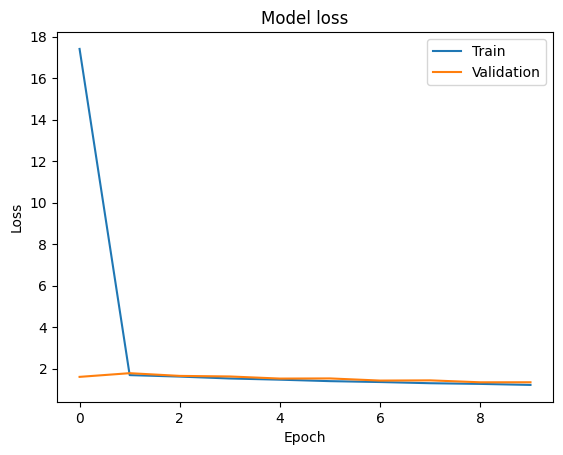

3.0262320898062596
1.5281300469819552


In [ ]:
import matplotlib.pyplot as plt

avg_train_loss=np.divide(results_train_loss,len(GE_Profile_WGS.columns))
avg_train_val_loss=np.divide(results_train_val_loss,len(GE_Profile_WGS.columns))
plt.plot(avg_train_loss)
plt.plot(avg_train_val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

print(np.average(avg_train_loss))
print(np.average(avg_train_val_loss))

####DML

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from econml.inference import LinearModelFinalInference
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy
import pandas
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout
from keras.layers import Input
from keras.layers import Conv1D, GlobalAveragePooling1D, Flatten, UpSampling1D
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np
import tensorflow as tf
from keras.optimizers import RMSprop
import random as python_random

def reset_seeds():
   np.random.seed(987654321)
   python_random.seed(987654321)
   tf.random.set_seed(987654321)
   keras.utils.set_random_seed(987654321)

reset_seeds()

#CancerType="Kidney"
# Head-Neck Kidney LSCC LUAD Pancreas
Epigentetics_File= "Methylation_Meta_Value" #Methylation_Meta_Value #miRNA_Matrix_Pre-processed.csv
GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)

Epigentetics_File= "Methylation_Meta_Value" #Methylation_Meta_Value #miRNA_Matrix_Pre-processed.csv
RNASEQ = pd.read_csv(CancerType+" "+ "RNASeq_Matrix_Pre-processed.csv", index_col=0)
#RNASEQ=RNASEQ.drop(index="C3N-00545-06")
Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")


result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})
Target_Gene=pd.DataFrame({'Feature': []})
count=0
n_epochs=10
results_train_loss=[0]*n_epochs
results_train_val_loss=[0]*n_epochs
for col in range (0,len(GE_Profile_WGS.columns)):

      #TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes=Proteins[Proteins.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes['treatment']=Treatment_State
      TargetGenes=TargetGenes.dropna()
      Treatment_State=TargetGenes['treatment']
      TargetGenes=TargetGenes.drop('treatment',axis=1)

      for tg in TargetGenes.columns:
        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        Target_Gene=pd.DataFrame(TargetGenes[tg])
        Target_Gene['Label']=Treatment_State
        #exported_analysis = pd.read_csv(CancerType+"_Statistics_of_RNA.csv",)
        exported_analysis = pd.read_csv(CancerType+"_Statistics_of_Proteins.csv",)
        if(exported_analysis.loc[exported_analysis['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = ttest_result[1]
        else:
          summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
          GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = result
        if(pvalue>0.05): #Check if the gene has signifcance corrlation
          TargetGenes=TargetGenes.drop(tg,axis=1)

      ci_per_feature=[]
      if(len(TargetGenes.columns)>0):


        Y = Treatment_State
        # encode class values as integers
        encoder = LabelEncoder()
        encoder.fit(Y)
        encoded_Y = encoder.transform(Y)
        # larger model

        model = Sequential()
        inp=Input(shape=(TargetGenes.shape[1],))
        if(TargetGenes.shape[1]>1):
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(inp)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(1, activation='linear')(model)
          model=Dense(1, activation='linear')(model)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(model)
        else:
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(inp)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(model)
        out=Dense(TargetGenes.shape[1], activation='linear')(model)
        model = Model(inp, out)
        model.compile(loss='mse')
        results=model.fit( TargetGenes, TargetGenes,epochs=n_epochs,batch_size=5,verbose=0,validation_split=0.2)
        if(TargetGenes.shape[1]>1):
          latent_space_layer=Model(model.inputs,model.layers[3].output)
        else:
          latent_space_layer=Model(model.inputs,model.layers[2].output)
        x_latent=latent_space_layer.predict(TargetGenes)

        GE_Profile_WGS['TargetGene']=x_latent
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')
        est = DML(
                   model_y=KNeighborsRegressor(n_neighbors=5), #KNeighborsRegressor(n_neighbors=5),
                   model_t=KNeighborsClassifier(n_neighbors=5), #KNeighborsRegressor(n_neighbors=5),
                   model_final=StatsModelsLinearRegression(fit_intercept=False), #StatsModelsLinearRegression,MultiOutputDebiasedLasso
                   discrete_treatment=True,
                   random_state=987654321)
        est.fit( np.array(GE_Profile_WGS['TargetGene']), Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1), W=None,inference="auto")
        est_effect=est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1)
        print("Double ML Causal Estimate is " + str(np.average(est_effect)))
        ci_averge_weight=np.average(est_effect)
        ci_per_feature.append(ci_averge_weight)

        if(len(ci_per_feature)>0):
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_Avg_LS_SMLR': np.average(ci_per_feature)}, ignore_index=True)
        else:
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_Avg_LS_SMLR': str(0)}, ignore_index=True)
      else:
        print("Double ML Causal Estimate is " + GE_Profile_WGS.columns[col])


Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is 0.12264448665111585



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_8']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_8']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is -1.2265030384140458



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(32, 6))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is 0.7830820471167144



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_24']
Received: inputs=Tensor(shape=(32, 6))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_24']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is -1.2108625102767276



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_32']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_32']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is -0.6870503668662696



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_40']
Received: inputs=Tensor(shape=(32, 11))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_40']
Received: inputs=Tensor(shape=(None, 11))


Double ML Causal Estimate is 1.601470092768003



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_48']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_48']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is -0.028582005931086587



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_56']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_56']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is -0.7859271700271426



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_64']
Received: inputs=Tensor(shape=(32, 5))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_64']
Received: inputs=Tensor(shape=(None, 5))


Double ML Causal Estimate is 0.12447748437783077



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_72']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_72']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is 1.279007134923951



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_80']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_80']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is -0.04063667535580052



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_88']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_88']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -0.3065727719231125



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_96']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_96']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -0.1635535892788445



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_104']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_104']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 0.6431845734570807



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_112']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_112']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 1.0611383217409687



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_120']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_120']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is 0.6584129848377543



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_128']
Received: inputs=Tensor(shape=(32, 6))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_128']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is 0.857276837603795



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_136']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_136']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is 2.1300564934626895



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_144']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_144']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -0.21558586894350013



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_152']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_152']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is -1.14396578695282



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_160']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_160']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is -2.2348113652282726



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_168']
Received: inputs=Tensor(shape=(32, 9))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_168']
Received: inputs=Tensor(shape=(None, 9))


Double ML Causal Estimate is -1.0105563787680485



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_176']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_176']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 0.6304152026697183



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_184']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_184']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 1.2400181136996775



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_192']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_192']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 1.59199920304387



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_200']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_200']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 0.8348527704142309



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_208']
Received: inputs=Tensor(shape=(32, 1))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_208']
Received: inputs=Tensor(shape=(None, 1))


Double ML Causal Estimate is 0.03362616311203338



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_214']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_214']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 1.0737224177445408



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_222']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_222']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is 0.006481113963787922



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_230']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_230']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is -0.11751020002428193



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_238']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_238']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 1.5100503462648658



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_246']
Received: inputs=Tensor(shape=(32, 6))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_246']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is 1.246827658475325



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_254']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_254']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is 0.559297162603981



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_262']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_262']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 2.2879378405940245



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_270']
Received: inputs=Tensor(shape=(32, 5))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_270']
Received: inputs=Tensor(shape=(None, 5))


Double ML Causal Estimate is -1.7008519426404174



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_278']
Received: inputs=Tensor(shape=(32, 9))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_278']
Received: inputs=Tensor(shape=(None, 9))


Double ML Causal Estimate is -0.9516331076448191



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_286']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_286']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 0.6330772853850437



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_294']
Received: inputs=Tensor(shape=(32, 5))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_294']
Received: inputs=Tensor(shape=(None, 5))


Double ML Causal Estimate is 1.13391845583797



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_302']
Received: inputs=Tensor(shape=(32, 1))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_302']
Received: inputs=Tensor(shape=(None, 1))


Double ML Causal Estimate is 0.8891545399283673



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_308']
Received: inputs=Tensor(shape=(32, 1))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_308']
Received: inputs=Tensor(shape=(None, 1))


Double ML Causal Estimate is 0.2850818088404475



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_314']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_314']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 0.04114434671262315



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_322']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_322']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 0.4436321403587126



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Double ML Causal Estimate is -1.1671775171791372


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_330']
Received: inputs=Tensor(shape=(32, 10))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_330']
Received: inputs=Tensor(shape=(None, 10))


In [ ]:
result_CI_DML_df


Feature  Estimate_Avg_LS_SMLR
0   cg26495711              0.122644
1   cg26026748             -1.226503
2   cg10460946              0.783082
3   cg17276002             -1.210863
4   cg05032848             -0.687050
5   cg22500132              1.601470
6   cg16676676             -0.028582
7   cg01772014             -0.785927
8   cg06505619              0.124477
9   cg08118034              1.279007
10  cg03364683             -0.040637
11  cg24522654             -0.306573
12  cg10383447             -0.163554
13  cg19588399              0.643185
14  cg10696787              1.061138
15  cg21870038              0.658413
16  cg27166177              0.857277
17  cg08443563              2.130056
18  cg23064082             -0.215586
19  cg15759721             -1.143966
20  cg14162940             -2.234811
21  cg23413697             -1.010556
22  cg15034393              0.630415
23  cg05775862              1.240018
24  cg16397638              1.591999
25  cg03081173              0.834853
26  cg26925980              0.033626
27  cg06024289              1.073722
28  cg02457319              0.006481
29  cg15138339             -0.117510
30  cg21449597              1.510050
31  cg01577083              1.246828
32  cg12279138              0.559297
33  cg09298313              2.287938
34  cg20961591             -1.700852
35  cg27623948             -0.951633
36  cg26690592              0.633077
37  cg03177025              1.133918
38  cg02524983              0.889155
39  cg00224911              0.285082
40  cg24180759              0.041144
41  cg09853702              0.443632
42  cg02386822             -1.167178

In [ ]:
result_CI_DML_df.set_index('Feature',inplace=True)
CI_Scores=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index_col=0)
CI_Scores['Estimate_LS_DML']=result_CI_DML_df['Estimate_Avg_LS_SMLR']
CI_Scores.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index=True)


####Causal Forest DML

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from econml.inference import LinearModelFinalInference
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy
import pandas
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout
from keras.layers import Input
from keras.layers import Conv1D, MaxPooling1D, Flatten, UpSampling1D
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np
import tensorflow as tf
import random as python_random
from econml.dml import CausalForestDML


def reset_seeds():
   np.random.seed(987654321)
   python_random.seed(987654321)
   tf.random.set_seed(987654321)
   keras.utils.set_random_seed(987654321)

reset_seeds()

GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})
Target_Gene=pd.DataFrame({'Feature': []})
count=0
n_epochs=10
results_train_loss=[0]*n_epochs
results_train_val_loss=[0]*n_epochs
for col in range (0,len(GE_Profile_WGS.columns)):

      #TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes=Proteins[Proteins.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes['treatment']=Treatment_State
      TargetGenes=TargetGenes.dropna()
      Treatment_State=TargetGenes['treatment']
      TargetGenes=TargetGenes.drop('treatment',axis=1)

      for tg in TargetGenes.columns:
        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        Target_Gene=pd.DataFrame(TargetGenes[tg])
        Target_Gene['Label']=Treatment_State
        #exported_analysis = pd.read_csv(CancerType+"_Statistics_of_RNA.csv",)
        exported_analysis = pd.read_csv(CancerType+"_Statistics_of_Proteins.csv",)
        if(exported_analysis.loc[exported_analysis['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = ttest_result[1]
        else:
          summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
          GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = result
        if(pvalue>0.05): #Check if the gene has signifcance corrlation
          TargetGenes=TargetGenes.drop(tg,axis=1)

      ci_per_feature=[]
      if(len(TargetGenes.columns)>0):


        Y = Treatment_State
        # encode class values as integers
        encoder = LabelEncoder()
        encoder.fit(Y)
        encoded_Y = encoder.transform(Y)
        # larger model

        model = Sequential()
        inp=Input(shape=(TargetGenes.shape[1],))
        if(TargetGenes.shape[1]>1):
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(inp)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(1, activation='linear')(model)
          model=Dense(1, activation='linear')(model)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(model)
        else:
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(inp)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(model)
        out=Dense(TargetGenes.shape[1], activation='linear')(model)
        model = Model(inp, out)
        model.compile(loss='mse')
        results=model.fit( TargetGenes, TargetGenes,epochs=n_epochs,batch_size=5,verbose=0,validation_split=0.2)
        if(TargetGenes.shape[1]>1):
          latent_space_layer=Model(model.inputs,model.layers[3].output)
        else:
          latent_space_layer=Model(model.inputs,model.layers[2].output)
        x_latent=latent_space_layer.predict(TargetGenes)
        GE_Profile_WGS['TargetGene']=x_latent
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')
        est = CausalForestDML(model_t=KNeighborsClassifier(),model_y=KNeighborsRegressor(),discrete_treatment=True,
                   random_state=987654321)
        est.fit( np.array(GE_Profile_WGS['TargetGene']), Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1), W=None,inference="auto")
          #print(est.summary())
        est_effect=est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1)
        print("Double ML Causal Estimate is " + str(np.average(est_effect)))
        ci_averge_weight=np.average(est_effect)
        ci_per_feature.append(ci_averge_weight)

        if(len(ci_per_feature)>0):
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_LS_CFDML': np.average(ci_per_feature)}, ignore_index=True)
        else:
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_LS_CFDML': str(0)}, ignore_index=True)
      else:
        print("Double ML Causal Estimate is " + GE_Profile_WGS.columns[col])

Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_338']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_338']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is 0.13267044325938337



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_346']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_346']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is -1.2253066627558389



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_354']
Received: inputs=Tensor(shape=(32, 6))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_354']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is 0.8085600835286335



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_362']
Received: inputs=Tensor(shape=(32, 6))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_362']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is -1.217154420196751



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_370']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_370']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is -0.6960018655682254



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_378']
Received: inputs=Tensor(shape=(32, 11))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_378']
Received: inputs=Tensor(shape=(None, 11))


Double ML Causal Estimate is 1.5926512632472305



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_386']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_386']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is -0.027244289005728995



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_394']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_394']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is -0.8185140725759662



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_402']
Received: inputs=Tensor(shape=(32, 5))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_402']
Received: inputs=Tensor(shape=(None, 5))


Double ML Causal Estimate is 0.07077828289579173



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_410']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_410']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is 1.2672318515167404



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_418']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_418']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is -0.027317006667404463



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_426']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_426']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -0.3060227760524237



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_434']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_434']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -0.16424175039114333



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_442']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_442']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 0.642249319273209



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_450']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_450']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 1.1081276386734367



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_458']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_458']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is 0.6719031773083267



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_466']
Received: inputs=Tensor(shape=(32, 6))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_466']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is 0.8575632197512532



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_474']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_474']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is 2.149021403156662



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_482']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_482']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -0.2074475855212881



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_490']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_490']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is -1.2210815477284684



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_498']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_498']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is -2.352992912063054



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_506']
Received: inputs=Tensor(shape=(32, 9))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_506']
Received: inputs=Tensor(shape=(None, 9))


Double ML Causal Estimate is -1.017977505407007



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_514']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_514']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 0.6104655429611381



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_522']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_522']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 1.250688123069208



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_530']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_530']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 1.7305084952693857



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_538']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_538']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 0.8370307058008187



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_546']
Received: inputs=Tensor(shape=(32, 1))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_546']
Received: inputs=Tensor(shape=(None, 1))


Double ML Causal Estimate is 0.028228537355137903



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_552']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_552']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 1.1222144967463874



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_560']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_560']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is 0.008021862637118638



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_568']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_568']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is -0.11135556202359198



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_576']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_576']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 1.5238000391060922



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_584']
Received: inputs=Tensor(shape=(32, 6))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_584']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is 1.2522479661274968



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_592']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_592']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is 0.6109381147357354



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_600']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_600']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 2.2531528998529304



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_608']
Received: inputs=Tensor(shape=(32, 5))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_608']
Received: inputs=Tensor(shape=(None, 5))


Double ML Causal Estimate is -1.7037577373360346



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_616']
Received: inputs=Tensor(shape=(32, 9))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_616']
Received: inputs=Tensor(shape=(None, 9))


Double ML Causal Estimate is -1.0051835764257968



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_624']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_624']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 0.6361264957620179



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_632']
Received: inputs=Tensor(shape=(32, 5))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_632']
Received: inputs=Tensor(shape=(None, 5))


Double ML Causal Estimate is 1.1706664702197516



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_640']
Received: inputs=Tensor(shape=(32, 1))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_640']
Received: inputs=Tensor(shape=(None, 1))


Double ML Causal Estimate is 0.9033862993095491



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_646']
Received: inputs=Tensor(shape=(32, 1))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_646']
Received: inputs=Tensor(shape=(None, 1))


Double ML Causal Estimate is 0.3167055606910286



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_652']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_652']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 0.03577341841710081



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_660']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_660']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 0.4505032486363542



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_668']
Received: inputs=Tensor(shape=(32, 10))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_668']
Received: inputs=Tensor(shape=(None, 10))


Double ML Causal Estimate is -1.1484162619759235


In [ ]:
result_CI_DML_df


Feature  Estimate_LS_CFDML
0   cg26495711           0.132670
1   cg26026748          -1.225307
2   cg10460946           0.808560
3   cg17276002          -1.217154
4   cg05032848          -0.696002
5   cg22500132           1.592651
6   cg16676676          -0.027244
7   cg01772014          -0.818514
8   cg06505619           0.070778
9   cg08118034           1.267232
10  cg03364683          -0.027317
11  cg24522654          -0.306023
12  cg10383447          -0.164242
13  cg19588399           0.642249
14  cg10696787           1.108128
15  cg21870038           0.671903
16  cg27166177           0.857563
17  cg08443563           2.149021
18  cg23064082          -0.207448
19  cg15759721          -1.221082
20  cg14162940          -2.352993
21  cg23413697          -1.017978
22  cg15034393           0.610466
23  cg05775862           1.250688
24  cg16397638           1.730508
25  cg03081173           0.837031
26  cg26925980           0.028229
27  cg06024289           1.122214
28  cg02457319           0.008022
29  cg15138339          -0.111356
30  cg21449597           1.523800
31  cg01577083           1.252248
32  cg12279138           0.610938
33  cg09298313           2.253153
34  cg20961591          -1.703758
35  cg27623948          -1.005184
36  cg26690592           0.636126
37  cg03177025           1.170666
38  cg02524983           0.903386
39  cg00224911           0.316706
40  cg24180759           0.035773
41  cg09853702           0.450503
42  cg02386822          -1.148416

In [ ]:
result_CI_DML_df.set_index('Feature',inplace=True)
CI_Scores=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index_col=0)
CI_Scores['Estimate_LS_CFDML']=result_CI_DML_df['Estimate_LS_CFDML']
CI_Scores.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index=True)


####X Learner

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from econml.inference import LinearModelFinalInference
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy
import pandas
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout
from keras.layers import Input
from keras.layers import Conv1D, MaxPooling1D, Flatten, UpSampling1D
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np
import tensorflow as tf
import random as python_random
from econml.metalearners import XLearner
from sklearn.linear_model import LinearRegression


def reset_seeds():
   np.random.seed(987654321)
   python_random.seed(987654321)
   tf.random.set_seed(987654321)
   keras.utils.set_random_seed(987654321)

reset_seeds()

GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})
Target_Gene=pd.DataFrame({'Feature': []})
count=0
n_epochs=10
results_train_loss=[0]*n_epochs
results_train_val_loss=[0]*n_epochs
for col in range (0,len(GE_Profile_WGS.columns)):

      #TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes=Proteins[Proteins.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes['treatment']=Treatment_State
      TargetGenes=TargetGenes.dropna()
      Treatment_State=TargetGenes['treatment']
      TargetGenes=TargetGenes.drop('treatment',axis=1)

      for tg in TargetGenes.columns:
        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        Target_Gene=pd.DataFrame(TargetGenes[tg])
        Target_Gene['Label']=Treatment_State
        #exported_analysis = pd.read_csv(CancerType+"_Statistics_of_RNA.csv",)
        exported_analysis = pd.read_csv(CancerType+"_Statistics_of_Proteins.csv",)
        if(exported_analysis.loc[exported_analysis['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = ttest_result[1]
        else:
          summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
          GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = result
        if(pvalue>0.05): #Check if the gene has signifcance corrlation
          TargetGenes=TargetGenes.drop(tg,axis=1)

      ci_per_feature=[]
      if(len(TargetGenes.columns)>0):


        Y = Treatment_State
        # encode class values as integers
        encoder = LabelEncoder()
        encoder.fit(Y)
        encoded_Y = encoder.transform(Y)
        # larger model

        model = Sequential()
        inp=Input(shape=(TargetGenes.shape[1],))
        if(TargetGenes.shape[1]>1):
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(inp)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(1, activation='linear')(model)
          model=Dense(1, activation='linear')(model)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(model)
        else:
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(inp)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(model)
        out=Dense(TargetGenes.shape[1], activation='linear')(model)
        model = Model(inp, out)
        model.compile(loss='mse')
        results=model.fit( TargetGenes, TargetGenes,epochs=n_epochs,batch_size=5,verbose=0,validation_split=0.2)
        if(TargetGenes.shape[1]>1):
          latent_space_layer=Model(model.inputs,model.layers[3].output)
        else:
          latent_space_layer=Model(model.inputs,model.layers[2].output)
        x_latent=latent_space_layer.predict(TargetGenes)
        GE_Profile_WGS['TargetGene']=x_latent
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')
        est = XLearner(models=KNeighborsRegressor())
        est.fit( np.array(GE_Profile_WGS['TargetGene']), Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1))
          #print(est.summary())
        est_effect=est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1)
        print("Double ML Causal Estimate is " + str(np.average(est_effect)))
        ci_averge_weight=np.average(est_effect)
        ci_per_feature.append(ci_averge_weight)

        if(len(ci_per_feature)>0):
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_LS_XL': np.average(ci_per_feature)}, ignore_index=True)
        else:
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_LS_XL': str(0)}, ignore_index=True)
      else:
        print("Double ML Causal Estimate is " + GE_Profile_WGS.columns[col])

Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_676']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_676']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is 0.14363956558113292



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_684']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_684']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is -1.1551629635727272



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_692']
Received: inputs=Tensor(shape=(32, 6))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_692']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is 0.7870149091317069



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_700']
Received: inputs=Tensor(shape=(32, 6))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_700']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is -1.2394468268922554



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_708']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_708']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is -0.6641840724399761



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_716']
Received: inputs=Tensor(shape=(32, 11))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_716']
Received: inputs=Tensor(shape=(None, 11))


Double ML Causal Estimate is 1.5893603870014483



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_724']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_724']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is -0.05514166005540172



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_732']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_732']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is -0.8060698656024164



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_740']
Received: inputs=Tensor(shape=(32, 5))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_740']
Received: inputs=Tensor(shape=(None, 5))


Double ML Causal Estimate is 0.22708008242627387



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_748']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_748']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is 1.3079901587850866



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_756']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_756']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is -0.046447948727944686



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_764']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_764']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -0.3355364823822009



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_772']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_772']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -0.16316723319049065



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_780']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_780']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 0.6103643880737615



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_788']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_788']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 1.0352280411568464



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_796']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_796']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is 0.6237476893511437



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_804']
Received: inputs=Tensor(shape=(32, 6))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_804']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is 0.8869864910937391



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_812']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_812']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is 2.0876877231258204



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_820']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_820']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -0.13249862372013438



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_828']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_828']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is -1.0494769377751205



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_836']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_836']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is -2.253135604797798



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_844']
Received: inputs=Tensor(shape=(32, 9))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_844']
Received: inputs=Tensor(shape=(None, 9))


Double ML Causal Estimate is -0.9620035548828575



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_852']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_852']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 0.7161186174415434



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_860']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_860']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 1.1994587835197896



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_868']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_868']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 1.5308739753429266



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_876']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_876']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 0.7313520756029345



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_884']
Received: inputs=Tensor(shape=(32, 1))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_884']
Received: inputs=Tensor(shape=(None, 1))


Double ML Causal Estimate is 0.08420139917676008



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_890']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_890']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 0.9813586216676219



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_898']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_898']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is 0.005399317439283091



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_906']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_906']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is -0.1726430987762542



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_914']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_914']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 1.4133734275429124



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_922']
Received: inputs=Tensor(shape=(32, 6))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_922']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is 1.3223152561236435



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_930']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_930']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is 0.6416831764275649



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_938']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_938']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 1.86595242949822



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_946']
Received: inputs=Tensor(shape=(32, 5))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_946']
Received: inputs=Tensor(shape=(None, 5))


Double ML Causal Estimate is -1.526236277637374



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_954']
Received: inputs=Tensor(shape=(32, 9))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_954']
Received: inputs=Tensor(shape=(None, 9))


Double ML Causal Estimate is -1.0437486639882907



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_962']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_962']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 0.6236248917704037



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_970']
Received: inputs=Tensor(shape=(32, 5))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_970']
Received: inputs=Tensor(shape=(None, 5))


Double ML Causal Estimate is 1.0302238277846758



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_978']
Received: inputs=Tensor(shape=(32, 1))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_978']
Received: inputs=Tensor(shape=(None, 1))


Double ML Causal Estimate is 0.9345816552796219



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_984']
Received: inputs=Tensor(shape=(32, 1))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_984']
Received: inputs=Tensor(shape=(None, 1))


Double ML Causal Estimate is 0.37254716832068985



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_990']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_990']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -0.0189604082695321



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_998']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_998']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 0.37158492693280937



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Double ML Causal Estimate is -1.213569710849271


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1006']
Received: inputs=Tensor(shape=(32, 10))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1006']
Received: inputs=Tensor(shape=(None, 10))


In [ ]:
result_CI_DML_df


Feature  Estimate_LS_XL
0   cg26495711        0.143640
1   cg26026748       -1.155163
2   cg10460946        0.787015
3   cg17276002       -1.239447
4   cg05032848       -0.664184
5   cg22500132        1.589360
6   cg16676676       -0.055142
7   cg01772014       -0.806070
8   cg06505619        0.227080
9   cg08118034        1.307990
10  cg03364683       -0.046448
11  cg24522654       -0.335536
12  cg10383447       -0.163167
13  cg19588399        0.610364
14  cg10696787        1.035228
15  cg21870038        0.623748
16  cg27166177        0.886986
17  cg08443563        2.087688
18  cg23064082       -0.132499
19  cg15759721       -1.049477
20  cg14162940       -2.253136
21  cg23413697       -0.962004
22  cg15034393        0.716119
23  cg05775862        1.199459
24  cg16397638        1.530874
25  cg03081173        0.731352
26  cg26925980        0.084201
27  cg06024289        0.981359
28  cg02457319        0.005399
29  cg15138339       -0.172643
30  cg21449597        1.413373
31  cg01577083        1.322315
32  cg12279138        0.641683
33  cg09298313        1.865952
34  cg20961591       -1.526236
35  cg27623948       -1.043749
36  cg26690592        0.623625
37  cg03177025        1.030224
38  cg02524983        0.934582
39  cg00224911        0.372547
40  cg24180759       -0.018960
41  cg09853702        0.371585
42  cg02386822       -1.213570

In [ ]:
result_CI_DML_df.set_index('Feature',inplace=True)
CI_Scores=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index_col=0)
CI_Scores['Estimate_LS_XL']=result_CI_DML_df['Estimate_LS_XL']
CI_Scores.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index=True)


####T Learner

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from econml.inference import LinearModelFinalInference
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy
import pandas
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout
from keras.layers import Input
from keras.layers import Conv1D, MaxPooling1D, Flatten, UpSampling1D
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np
import tensorflow as tf
import random as python_random
from econml.metalearners import TLearner
from sklearn.linear_model import LinearRegression


def reset_seeds():
   np.random.seed(987654321)
   python_random.seed(987654321)
   tf.random.set_seed(987654321)
   keras.utils.set_random_seed(987654321)

reset_seeds()

GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})
Target_Gene=pd.DataFrame({'Feature': []})
count=0
n_epochs=10
results_train_loss=[0]*n_epochs
results_train_val_loss=[0]*n_epochs
for col in range (0,len(GE_Profile_WGS.columns)):

      #TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes=Proteins[Proteins.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes['treatment']=Treatment_State
      TargetGenes=TargetGenes.dropna()
      Treatment_State=TargetGenes['treatment']
      TargetGenes=TargetGenes.drop('treatment',axis=1)

      for tg in TargetGenes.columns:
        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        Target_Gene=pd.DataFrame(TargetGenes[tg])
        Target_Gene['Label']=Treatment_State
        #exported_analysis = pd.read_csv(CancerType+"_Statistics_of_RNA.csv",)
        exported_analysis = pd.read_csv(CancerType+"_Statistics_of_Proteins.csv",)
        if(exported_analysis.loc[exported_analysis['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = ttest_result[1]
        else:
          summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
          GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = result
        if(pvalue>0.05): #Check if the gene has signifcance corrlation
          TargetGenes=TargetGenes.drop(tg,axis=1)

      ci_per_feature=[]
      if(len(TargetGenes.columns)>0):


        Y = Treatment_State
        # encode class values as integers
        encoder = LabelEncoder()
        encoder.fit(Y)
        encoded_Y = encoder.transform(Y)
        # larger model

        model = Sequential()
        inp=Input(shape=(TargetGenes.shape[1],))
        if(TargetGenes.shape[1]>1):
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(inp)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(1, activation='linear')(model)
          model=Dense(1, activation='linear')(model)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(model)
        else:
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(inp)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(model)
        out=Dense(TargetGenes.shape[1], activation='linear')(model)
        model = Model(inp, out)
        model.compile(loss='mse')
        results=model.fit( TargetGenes, TargetGenes,epochs=n_epochs,batch_size=5,verbose=0,validation_split=0.2)
        if(TargetGenes.shape[1]>1):
          latent_space_layer=Model(model.inputs,model.layers[3].output)
        else:
          latent_space_layer=Model(model.inputs,model.layers[2].output)
        x_latent=latent_space_layer.predict(TargetGenes)
        GE_Profile_WGS['TargetGene']=x_latent
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        est = TLearner(models=KNeighborsRegressor())
        est.fit( np.array(GE_Profile_WGS['TargetGene']), Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1))
          #print(est.summary())
        est_effect=est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1)
        print("Double ML Causal Estimate is " + str(np.average(est_effect)))
        ci_averge_weight=np.average(est_effect)
        ci_per_feature.append(ci_averge_weight)

        if(len(ci_per_feature)>0):
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_LS_TL': np.average(ci_per_feature)}, ignore_index=True)
        else:
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_LS_TL': str(0)}, ignore_index=True)
      else:
        print("Double ML Causal Estimate is " + GE_Profile_WGS.columns[col])

Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1014']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1014']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is 0.1463180885629406



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1022']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1022']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is -1.1472063490506992



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1030']
Received: inputs=Tensor(shape=(32, 6))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1030']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is 0.7841053379064832



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1038']
Received: inputs=Tensor(shape=(32, 6))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1038']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is -1.2296385453067014



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1046']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1046']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is -0.6570047972145017



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1054']
Received: inputs=Tensor(shape=(32, 11))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1054']
Received: inputs=Tensor(shape=(None, 11))


Double ML Causal Estimate is 1.5883557417872236



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1062']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1062']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is -0.055782648359097575



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1070']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1070']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is -0.8090140017831708



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1078']
Received: inputs=Tensor(shape=(32, 5))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1078']
Received: inputs=Tensor(shape=(None, 5))


Double ML Causal Estimate is 0.2362071399436483



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1086']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1086']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is 1.2922875525794049



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1094']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1094']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is -0.047615558593195745



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1102']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1102']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -0.3292134843418094



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1110']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1110']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -0.15452996461168347



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1118']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1118']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 0.6194974548688065



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1126']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1126']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 1.0354152790827458



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1134']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1134']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is 0.6264267842113638



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1142']
Received: inputs=Tensor(shape=(32, 6))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1142']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is 0.8965672194042019



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1150']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1150']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is 2.0597755365656405



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1158']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1158']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -0.13580280346743887



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1166']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1166']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is -1.0770808389108608



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1174']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1174']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is -2.2751384803078363



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1182']
Received: inputs=Tensor(shape=(32, 9))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1182']
Received: inputs=Tensor(shape=(None, 9))


Double ML Causal Estimate is -0.9693935411186192



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1190']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1190']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 0.7105956260978593



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1198']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1198']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 1.2047632743151826



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1206']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1206']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 1.5661747709166403



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1214']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1214']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 0.7615855711631935



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1222']
Received: inputs=Tensor(shape=(32, 1))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1222']
Received: inputs=Tensor(shape=(None, 1))


Double ML Causal Estimate is 0.08175645317653371



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1228']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1228']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 0.9286965304912802



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1236']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1236']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is 0.0037678146339411834



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1244']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1244']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is -0.17475567613676316



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1252']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1252']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 1.4054137910835902



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1260']
Received: inputs=Tensor(shape=(32, 6))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1260']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is 1.3243319355867094



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1268']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1268']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is 0.6529045238648672



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1276']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1276']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 1.8472390902483595



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1284']
Received: inputs=Tensor(shape=(32, 5))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1284']
Received: inputs=Tensor(shape=(None, 5))


Double ML Causal Estimate is -1.4856400127340545



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1292']
Received: inputs=Tensor(shape=(32, 9))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1292']
Received: inputs=Tensor(shape=(None, 9))


Double ML Causal Estimate is -1.0096327554372102



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1300']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1300']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 0.6158306319370616



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1308']
Received: inputs=Tensor(shape=(32, 5))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1308']
Received: inputs=Tensor(shape=(None, 5))


Double ML Causal Estimate is 1.0488004250275025



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1316']
Received: inputs=Tensor(shape=(32, 1))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1316']
Received: inputs=Tensor(shape=(None, 1))


Double ML Causal Estimate is 0.931973908459976



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1322']
Received: inputs=Tensor(shape=(32, 1))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1322']
Received: inputs=Tensor(shape=(None, 1))


Double ML Causal Estimate is 0.35931809419276994



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1328']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1328']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -0.025791903206423005



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1336']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1336']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 0.37058145841635637



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Double ML Causal Estimate is -1.2230394809465213


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1344']
Received: inputs=Tensor(shape=(32, 10))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1344']
Received: inputs=Tensor(shape=(None, 10))


In [ ]:
result_CI_DML_df


In [ ]:
result_CI_DML_df.set_index('Feature',inplace=True)
CI_Scores=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index_col=0)
CI_Scores['Estimate_LS_TL']=result_CI_DML_df['Estimate_LS_TL']
CI_Scores.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index=True)


####S Learner

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from econml.inference import LinearModelFinalInference
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy
import pandas
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout
from keras.layers import Input
from keras.layers import Conv1D, MaxPooling1D, Flatten, UpSampling1D
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np
import tensorflow as tf
import random as python_random
from econml.metalearners import SLearner
from sklearn.linear_model import LinearRegression


def reset_seeds():
   np.random.seed(987654321)
   python_random.seed(987654321)
   tf.random.set_seed(987654321)
   keras.utils.set_random_seed(987654321)

reset_seeds()

#CancerType="Kidney"
# Head-Neck Kidney LSCC LUAD Pancreas
Epigentetics_File= "Methylation_Meta_Value" #Methylation_Meta_Value #miRNA_Matrix_Pre-processed.csv
GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)
RNASEQ = pd.read_csv(CancerType+" "+ "RNASeq_Matrix_Pre-processed.csv", index_col=0)
Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")
Proteins = pd.read_csv(CancerType+"_"+ "Proteomics_Imputed.csv", index_col=0).transpose()
#Proteins = pd.read_csv(CancerType+" "+ "Proteomics.csv", index_col=0).transpose()

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})
Target_Gene=pd.DataFrame({'Feature': []})
count=0
n_epochs=10
results_train_loss=[0]*n_epochs
results_train_val_loss=[0]*n_epochs
for col in range (0,len(GE_Profile_WGS.columns)):

      #TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes=Proteins[Proteins.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes['treatment']=Treatment_State
      TargetGenes=TargetGenes.dropna()
      Treatment_State=TargetGenes['treatment']
      TargetGenes=TargetGenes.drop('treatment',axis=1)

      for tg in TargetGenes.columns:
        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        Target_Gene=pd.DataFrame(TargetGenes[tg])
        Target_Gene['Label']=Treatment_State
        #exported_analysis = pd.read_csv(CancerType+"_Statistics_of_RNA.csv",)
        exported_analysis = pd.read_csv(CancerType+"_Statistics_of_Proteins.csv",)
        if(exported_analysis.loc[exported_analysis['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = ttest_result[1]
        else:
          summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
          GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = result
        if(pvalue>0.05): #Check if the gene has signifcance corrlation
          TargetGenes=TargetGenes.drop(tg,axis=1)

      ci_per_feature=[]
      if(len(TargetGenes.columns)>0):


        Y = Treatment_State
        # encode class values as integers
        encoder = LabelEncoder()
        encoder.fit(Y)
        encoded_Y = encoder.transform(Y)
        # larger model

        model = Sequential()
        inp=Input(shape=(TargetGenes.shape[1],))
        if(TargetGenes.shape[1]>1):
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(inp)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(1, activation='linear')(model)
          model=Dense(1, activation='linear')(model)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(model)
        else:
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(inp)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(model)
        out=Dense(TargetGenes.shape[1], activation='linear')(model)
        model = Model(inp, out)
        model.compile(loss='mse')
        results=model.fit( TargetGenes, TargetGenes,epochs=n_epochs,batch_size=5,verbose=0,validation_split=0.2)
        if(TargetGenes.shape[1]>1):
          latent_space_layer=Model(model.inputs,model.layers[3].output)
        else:
          latent_space_layer=Model(model.inputs,model.layers[2].output)
        x_latent=latent_space_layer.predict(TargetGenes)
        GE_Profile_WGS['TargetGene']=x_latent
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        est = SLearner(overall_model=KNeighborsRegressor())
        est.fit( np.array(GE_Profile_WGS['TargetGene']), Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1))
          #print(est.summary())
        est_effect=est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1)
        print("Double ML Causal Estimate is " + str(np.average(est_effect)))
        ci_averge_weight=np.average(est_effect)
        ci_per_feature.append(ci_averge_weight)

        if(len(ci_per_feature)>0):
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_LS_SL': np.average(ci_per_feature)}, ignore_index=True)
        else:
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_LS_SL': str(0)}, ignore_index=True)
      else:
        print("Double ML Causal Estimate is " + GE_Profile_WGS.columns[col])

Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1352']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1352']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is 0.14426379354212784



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1360']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1360']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is -1.1347225031414845



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1368']
Received: inputs=Tensor(shape=(32, 6))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1368']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is 0.784465203396768



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1376']
Received: inputs=Tensor(shape=(32, 6))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1376']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is -1.2296385453067014



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1384']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1384']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is -0.6548860794894512



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1392']
Received: inputs=Tensor(shape=(32, 11))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1392']
Received: inputs=Tensor(shape=(None, 11))


Double ML Causal Estimate is 1.5707609420715098



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1400']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1400']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is -0.05560064202164139



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1408']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1408']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is -0.8071513931334601



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1416']
Received: inputs=Tensor(shape=(32, 5))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1416']
Received: inputs=Tensor(shape=(None, 5))


Double ML Causal Estimate is 0.23577307870809258



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1424']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1424']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is 1.2873256497438892



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1432']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1432']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is -0.048680744642214904



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1440']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1440']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -0.3277971871764342



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1448']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1448']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -0.15506790219988234



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1456']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1456']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 0.6194974548688065



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1464']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1464']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 1.0394991469949317



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1472']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1472']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is 0.6261642766981151



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1480']
Received: inputs=Tensor(shape=(32, 6))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1480']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is 0.8965672194042019



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1488']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1488']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is 2.0597755365656405



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1496']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1496']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -0.13580280346743887



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1504']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1504']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is -1.0124700585931707



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1512']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1512']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is -2.2751384803078363



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1520']
Received: inputs=Tensor(shape=(32, 9))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1520']
Received: inputs=Tensor(shape=(None, 9))


Double ML Causal Estimate is -0.963126294198316



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1528']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1528']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 0.7096797362313341



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1536']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1536']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 1.2035939446416313



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1544']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1544']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 1.5661747709166403



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1552']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1552']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 0.7568731576204301



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1560']
Received: inputs=Tensor(shape=(32, 1))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1560']
Received: inputs=Tensor(shape=(None, 1))


Double ML Causal Estimate is 0.08084403002978037



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1566']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1566']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 0.9286965304912802



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1574']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1574']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is 0.003698300887627641



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1582']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1582']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is -0.17475567613676316



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1590']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1590']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 1.4004909971198223



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1598']
Received: inputs=Tensor(shape=(32, 6))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1598']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is 1.3221900840336718



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1606']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1606']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is 0.6502213375434779



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1614']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1614']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 1.8472390902483595



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1622']
Received: inputs=Tensor(shape=(32, 5))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1622']
Received: inputs=Tensor(shape=(None, 5))


Double ML Causal Estimate is -1.4856400127340545



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1630']
Received: inputs=Tensor(shape=(32, 9))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1630']
Received: inputs=Tensor(shape=(None, 9))


Double ML Causal Estimate is -1.0096327554372102



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1638']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1638']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 0.6140347538463896



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1646']
Received: inputs=Tensor(shape=(32, 5))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1646']
Received: inputs=Tensor(shape=(None, 5))


Double ML Causal Estimate is 1.0533811597725866



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1654']
Received: inputs=Tensor(shape=(32, 1))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1654']
Received: inputs=Tensor(shape=(None, 1))


Double ML Causal Estimate is 0.9307253476890459



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1660']
Received: inputs=Tensor(shape=(32, 1))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1660']
Received: inputs=Tensor(shape=(None, 1))


Double ML Causal Estimate is 0.35931809419276994



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1666']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1666']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -0.026991713105300286



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1674']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1674']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 0.3664724079080384



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Double ML Causal Estimate is -1.2221564133932514


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1682']
Received: inputs=Tensor(shape=(32, 10))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1682']
Received: inputs=Tensor(shape=(None, 10))


In [ ]:
result_CI_DML_df


Feature  Estimate_LS_SL
0        cg07176692       -0.014962
1        cg08305942       -0.016932
2        cg11171825        0.063509
3     ch.15.934240F       -0.000901
4        cg02849507        0.573258
..              ...             ...
285  ch.17.1646506R       -0.307879
286      cg06457408       -0.444363
287      cg04688368       -0.106576
288      cg04005677       -0.225711
289  ch.19.1271107R        1.257611

[290 rows x 2 columns]

In [ ]:
result_CI_DML_df.set_index('Feature',inplace=True)
CI_Scores=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index_col=0)
CI_Scores['Estimate_LS_SL']=result_CI_DML_df['Estimate_LS_SL']
CI_Scores.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index=True)


####DomainAdaptationLearner

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from econml.inference import LinearModelFinalInference
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy
import pandas
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout
from keras.layers import Input
from keras.layers import Conv1D, MaxPooling1D, Flatten, UpSampling1D
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np
import tensorflow as tf
import random as python_random
from econml.metalearners import DomainAdaptationLearner
from sklearn.linear_model import LinearRegression


def reset_seeds():
   np.random.seed(987654321)
   python_random.seed(987654321)
   tf.random.set_seed(987654321)
   keras.utils.set_random_seed(987654321)

reset_seeds()

GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})
Target_Gene=pd.DataFrame({'Feature': []})
count=0
for col in range (0,len(GE_Profile_WGS.columns)):

      TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]

      for tg in TargetGenes.columns:
        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        Target_Gene=pd.DataFrame(TargetGenes[tg])
        Target_Gene['Label']=Treatment_State
        exported_analysis = pd.read_csv(CancerType+"_Statistics_of_RNA.csv",)
        if(exported_analysis.loc[exported_analysis['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = ttest_result[1]
        else:
          summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
          GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = result
        if(pvalue>0.05): #Check if the gene has signifcance corrlation
          TargetGenes=TargetGenes.drop(tg,axis=1)

      ci_per_feature=[]
      if(len(TargetGenes.columns)>0):

        X = TargetGenes.values
        sample_size = X.shape[0] # number of samples in train set
        genes  = X.shape[1] # number of features in train set
        input_dimension = 1               # each feature is represented by 1 number

        X_reshaped = X.reshape(sample_size,genes,input_dimension)
        #print(X_reshaped.shape)
        Y = Treatment_State
        # encode class values as integers
        encoder = LabelEncoder()
        encoder.fit(Y)
        encoded_Y = encoder.transform(Y)
        # larger model

        def DNN():

          model = Sequential()
          inp=Input(shape=X_reshaped.shape[1:3])
          model=Dense(500, activation='relu')(inp)
          model=Dense(500, activation='relu')(model)
          model=Dense(500, activation='relu')(model)
          model=Dense(100, activation='relu')(model)
          model=Flatten()(model)
          model=Dense(1, activation='relu',name='features')(model)
          out=Dense(1, activation='sigmoid')(model)
          model = Model(inp, out)
          model.compile(loss='binary_crossentropy', optimizer='Adamax', metrics=['accuracy'])

          return model
        #estimator = KerasClassifier(model=DNN, epochs=100, batch_size=5, verbose=0)
        #k_folds = RepeatedStratifiedKFold(n_splits =5, n_repeats=3,random_state=987654321)
        #results,x_latent = cross_val_score(estimator, X_reshaped, encoded_Y, cv=k_folds)
        model=DNN()
        results=model.fit( X_reshaped, encoded_Y,epochs=10,batch_size=5,verbose=0)
        #print("Mean accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
        extract=Model(model.inputs,model.layers[-2].output)
        x_latent=extract.predict(X_reshaped)

        GE_Profile_WGS['TargetGene']=x_latent
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')
        est = DomainAdaptationLearner(models=LinearRegression(),
                                      propensity_model=KNeighborsClassifier(n_neighbors=5),
                                      final_models=StatsModelsLinearRegression(fit_intercept=False))
        est.fit( np.array(GE_Profile_WGS['TargetGene']), Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1))
          #print(est.summary())
        est_effect=est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1)
        print("Double ML Causal Estimate is " + str(np.average(est_effect)))
        ci_averge_weight=np.average(est_effect)
        ci_per_feature.append(ci_averge_weight)

        if(len(ci_per_feature)>0):
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_LS_Adaptation': np.average(ci_per_feature)}, ignore_index=True)
        else:
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_LS_Adaptation': str(0)}, ignore_index=True)
      else:
        print("Double ML Causal Estimate is " + GE_Profile_WGS.columns[col])

Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Double ML Causal Estimate is -22.94318332256313
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Double ML Causal Estimate is 0.6438813345818686
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Double ML

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Double ML Causal Estimate is -0.8136416298837864
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Double ML Causal Estimate is -0.012652885350196466
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Double ML Causal Estimate is 0.0


Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Double ML Causal Estimate is 0.0016898500893111046
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Double ML Causal Estimate is 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Double ML Causal Estimate is -4.795000978935146


In [ ]:
result_CI_DML_df


Feature  Estimate_LS_Adaptation
0   cg08223924                0.000000
1   cg11864327               -0.051522
2   cg11886405                0.000000
3   cg13897627                0.000000
4   cg24576995                0.000000
5   cg11582484                0.000000
6   cg03421657                0.359882
7   cg08337166                0.000000
8   cg06566239                0.033349
9   cg11820931               -0.004677
10  cg26202762                0.543173
11  cg17157798                0.000000
12  cg20979737                0.000000
13  cg16151261               -0.035858
14  cg01807825                0.004747
15  cg04094178               -0.017226
16  cg00629625                0.000000
17  cg01970336                0.000000
18  cg27203983                0.517485
19  cg24069602               -0.010426
20  cg00576086                0.114909
21  cg03267139                0.000000
22  cg05081953                0.000000
23  cg10648542                0.000000
24  cg13555050                0.000000
25  cg09853702                0.000000
26  cg01573635                0.000000
27  cg27537125                0.000000
28  cg09873544                0.000000
29  cg05579652                0.000000
30  cg09596131                0.000000
31  cg27219221                0.000000
32  cg10020892                0.000000
33  cg05068848                0.019716
34  cg19319037                0.000000
35  cg02301740               -0.025499
36  cg27583655                0.000000
37  cg07691684                0.000000
38  cg05516390                0.000000
39  cg07163845                0.000000
40  cg18025409                0.000000
41  cg23156348                0.000000
42  cg22641201                0.000000

In [ ]:
result_CI_DML_df.set_index('Feature',inplace=True)
CI_Scores=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index_col=0)
CI_Scores['Estimate_LS_Adaptation']=result_CI_DML_df['Estimate_LS_Adaptation']
CI_Scores.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index=True)


####Double Robust Learner

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from econml.inference import LinearModelFinalInference
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy
import pandas
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout
from keras.layers import Input
from keras.layers import Conv1D, MaxPooling1D, Flatten, UpSampling1D
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np
import tensorflow as tf
import random as python_random
from econml.dr import DRLearner
from sklearn.linear_model import LinearRegression


def reset_seeds():
   np.random.seed(987654321)
   python_random.seed(987654321)
   tf.random.set_seed(987654321)
   keras.utils.set_random_seed(987654321)

reset_seeds()

GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})
Target_Gene=pd.DataFrame({'Feature': []})
count=0
n_epochs=10
results_train_loss=[0]*n_epochs
results_train_val_loss=[0]*n_epochs
for col in range (0,len(GE_Profile_WGS.columns)):

      #TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes=Proteins[Proteins.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes['treatment']=Treatment_State
      TargetGenes=TargetGenes.dropna()
      Treatment_State=TargetGenes['treatment']
      TargetGenes=TargetGenes.drop('treatment',axis=1)

      for tg in TargetGenes.columns:
        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        Target_Gene=pd.DataFrame(TargetGenes[tg])
        Target_Gene['Label']=Treatment_State
        #exported_analysis = pd.read_csv(CancerType+"_Statistics_of_RNA.csv",)
        exported_analysis = pd.read_csv(CancerType+"_Statistics_of_Proteins.csv",)
        if(exported_analysis.loc[exported_analysis['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = ttest_result[1]
        else:
          summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
          GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = result
        if(pvalue>0.05): #Check if the gene has signifcance corrlation
          TargetGenes=TargetGenes.drop(tg,axis=1)

      ci_per_feature=[]
      if(len(TargetGenes.columns)>0):


        Y = Treatment_State
        # encode class values as integers
        encoder = LabelEncoder()
        encoder.fit(Y)
        encoded_Y = encoder.transform(Y)
        # larger model

        model = Sequential()
        inp=Input(shape=(TargetGenes.shape[1],))
        if(TargetGenes.shape[1]>1):
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(inp)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(1, activation='linear')(model)
          model=Dense(1, activation='linear')(model)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(model)
        else:
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(inp)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(model)
        out=Dense(TargetGenes.shape[1], activation='linear')(model)
        model = Model(inp, out)
        model.compile(loss='mse')
        results=model.fit( TargetGenes, TargetGenes,epochs=n_epochs,batch_size=5,verbose=0,validation_split=0.2)
        if(TargetGenes.shape[1]>1):
          latent_space_layer=Model(model.inputs,model.layers[3].output)
        else:
          latent_space_layer=Model(model.inputs,model.layers[2].output)
        x_latent=latent_space_layer.predict(TargetGenes)
        GE_Profile_WGS['TargetGene']=x_latent
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        est = DRLearner(model_propensity=KNeighborsClassifier(), model_regression=KNeighborsRegressor(), model_final=StatsModelsLinearRegression(fit_intercept=False))
        est.fit( np.array(GE_Profile_WGS['TargetGene']), Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1))
          #print(est.summary())
        est_effect=est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1)
        print("Double ML Causal Estimate is " + str(np.average(est_effect)))
        ci_averge_weight=np.average(est_effect)
        ci_per_feature.append(ci_averge_weight)

        if(len(ci_per_feature)>0):
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_LS_DRL': np.average(ci_per_feature)}, ignore_index=True)
        else:
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_LS_DRL': str(0)}, ignore_index=True)
      else:
        print("Double ML Causal Estimate is " + GE_Profile_WGS.columns[col])

Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1690']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1690']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is -1125.4908260122695



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1698']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1698']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is -341.20119362084176



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1706']
Received: inputs=Tensor(shape=(32, 6))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1706']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is 0.6184596961447653



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1714']
Received: inputs=Tensor(shape=(32, 6))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1714']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is 5919.937889655147



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1722']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1722']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is 5314.405176722466



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1730']
Received: inputs=Tensor(shape=(32, 11))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1730']
Received: inputs=Tensor(shape=(None, 11))


Double ML Causal Estimate is 45226.475729724916



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1738']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1738']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 2708.1168150797566



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1746']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1746']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is -2507.6505393864954



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1754']
Received: inputs=Tensor(shape=(32, 5))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1754']
Received: inputs=Tensor(shape=(None, 5))


Double ML Causal Estimate is -328.5663055087707



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1762']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1762']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is 11359.375259554918



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1770']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1770']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is -961.1083061117513



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1778']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1778']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -1742.2953919286103



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1786']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1786']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 3073.1074476396943



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1794']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1794']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 10691.356214117293



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1802']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1802']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 1342.7477052837394



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1810']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1810']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is -463.14463423395966



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1818']
Received: inputs=Tensor(shape=(32, 6))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1818']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is 56.14870823372782



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1826']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1826']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is 964.2378183527613



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1834']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1834']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -208.6898101129272



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1842']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1842']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is 3710.7321681734747



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1850']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1850']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is -30518.566596784705



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1858']
Received: inputs=Tensor(shape=(32, 9))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1858']
Received: inputs=Tensor(shape=(None, 9))


Double ML Causal Estimate is -4561.912732098835



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1866']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1866']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is -12841.215168782503



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1874']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1874']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 6900.30080616065



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1882']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1882']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 945.0434613896178



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1890']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1890']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -1681.503820182002



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1898']
Received: inputs=Tensor(shape=(32, 1))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1898']
Received: inputs=Tensor(shape=(None, 1))


Double ML Causal Estimate is 726.242226394738



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1904']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1904']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -5664.488070975515



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1912']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1912']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is 31.64112380803515



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1920']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1920']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is -1700.4208979743082



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1928']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1928']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 14355.344284940687



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1936']
Received: inputs=Tensor(shape=(32, 6))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1936']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is -8570.517149875648



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1944']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1944']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is 12360.685134184601



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1952']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1952']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is -8131.320939588418



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1960']
Received: inputs=Tensor(shape=(32, 5))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1960']
Received: inputs=Tensor(shape=(None, 5))


Double ML Causal Estimate is 15097.696781340086



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1968']
Received: inputs=Tensor(shape=(32, 9))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1968']
Received: inputs=Tensor(shape=(None, 9))


Double ML Causal Estimate is -4296.812689394452



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1976']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1976']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 821.2809862836677



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1984']
Received: inputs=Tensor(shape=(32, 5))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1984']
Received: inputs=Tensor(shape=(None, 5))


Double ML Causal Estimate is -6987.587732738238



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1992']
Received: inputs=Tensor(shape=(32, 1))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1992']
Received: inputs=Tensor(shape=(None, 1))


Double ML Causal Estimate is 166.9437283211758



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1998']
Received: inputs=Tensor(shape=(32, 1))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1998']
Received: inputs=Tensor(shape=(None, 1))


Double ML Causal Estimate is 854.8998830594767



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2004']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2004']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -208.5542425402699



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2012']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2012']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -333.07618837222145



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Double ML Causal Estimate is 6006.541658430539


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2020']
Received: inputs=Tensor(shape=(32, 10))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2020']
Received: inputs=Tensor(shape=(None, 10))


In [ ]:
result_CI_DML_df


In [ ]:
result_CI_DML_df.set_index('Feature',inplace=True)
CI_Scores=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index_col=0)
CI_Scores['Estimate_LS_DRL']=result_CI_DML_df['Estimate_LS_DRL']
CI_Scores.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index=True)


####Forest Double Robust Learner

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from econml.inference import LinearModelFinalInference
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy
import pandas
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout
from keras.layers import Input
from keras.layers import Conv1D, MaxPooling1D, Flatten, UpSampling1D
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np
import tensorflow as tf
import random as python_random
from econml.dr import ForestDRLearner
from sklearn.linear_model import LinearRegression


def reset_seeds():
   np.random.seed(987654321)
   python_random.seed(987654321)
   tf.random.set_seed(987654321)
   keras.utils.set_random_seed(987654321)

reset_seeds()

GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})
Target_Gene=pd.DataFrame({'Feature': []})
count=0
n_epochs=10
results_train_loss=[0]*n_epochs
results_train_val_loss=[0]*n_epochs
for col in range (0,len(GE_Profile_WGS.columns)):

      #TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes=Proteins[Proteins.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]
      TargetGenes['treatment']=Treatment_State
      TargetGenes=TargetGenes.dropna()
      Treatment_State=TargetGenes['treatment']
      TargetGenes=TargetGenes.drop('treatment',axis=1)

      for tg in TargetGenes.columns:
        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        Target_Gene=pd.DataFrame(TargetGenes[tg])
        Target_Gene['Label']=Treatment_State
        #exported_analysis = pd.read_csv(CancerType+"_Statistics_of_RNA.csv",)
        exported_analysis = pd.read_csv(CancerType+"_Statistics_of_Proteins.csv",)
        if(exported_analysis.loc[exported_analysis['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = ttest_result[1]
        else:
          summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
          GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = result
        if(pvalue>0.05): #Check if the gene has signifcance corrlation
          TargetGenes=TargetGenes.drop(tg,axis=1)

      ci_per_feature=[]
      if(len(TargetGenes.columns)>0):


        Y = Treatment_State
        # encode class values as integers
        encoder = LabelEncoder()
        encoder.fit(Y)
        encoded_Y = encoder.transform(Y)
        # larger model

        model = Sequential()
        inp=Input(shape=(TargetGenes.shape[1],))
        if(TargetGenes.shape[1]>1):
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(inp)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(1, activation='linear')(model)
          model=Dense(1, activation='linear')(model)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(model)
        else:
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(inp)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(round((TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1])/2), activation='linear')(model)
          model=Dense(round(TargetGenes.shape[1]*(2/3)+TargetGenes.shape[1]), activation='linear')(model)
        out=Dense(TargetGenes.shape[1], activation='linear')(model)
        model = Model(inp, out)
        model.compile(loss='mse')
        results=model.fit( TargetGenes, TargetGenes,epochs=n_epochs,batch_size=5,verbose=0,validation_split=0.2)
        if(TargetGenes.shape[1]>1):
          latent_space_layer=Model(model.inputs,model.layers[3].output)
        else:
          latent_space_layer=Model(model.inputs,model.layers[2].output)
        x_latent=latent_space_layer.predict(TargetGenes)
        GE_Profile_WGS['TargetGene']=x_latent
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        est = ForestDRLearner(model_propensity=KNeighborsClassifier(), model_regression=KNeighborsRegressor())
        est.fit( np.array(GE_Profile_WGS['TargetGene']), Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1))
          #print(est.summary())
        est_effect=est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1)
        print("Double ML Causal Estimate is " + str(np.average(est_effect)))
        ci_averge_weight=np.average(est_effect)
        ci_per_feature.append(ci_averge_weight)

        if(len(ci_per_feature)>0):
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_LS_FDRL': np.average(ci_per_feature)}, ignore_index=True)
        else:
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_LS_FDRL': str(0)}, ignore_index=True)
      else:
        print("Double ML Causal Estimate is " + GE_Profile_WGS.columns[col])

Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2028']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2028']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is -1050.6685294921353



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2036']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2036']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 3822.045482766845



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2044']
Received: inputs=Tensor(shape=(32, 6))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2044']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is 1976.2122441208792



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2052']
Received: inputs=Tensor(shape=(32, 6))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2052']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is -4018.8953324925824



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2060']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2060']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is -333.34658020400013



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2068']
Received: inputs=Tensor(shape=(32, 11))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2068']
Received: inputs=Tensor(shape=(None, 11))


Double ML Causal Estimate is 8855.955674502047



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2076']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2076']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 2118.6240477851934



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2084']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2084']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is -8363.700926394538



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2092']
Received: inputs=Tensor(shape=(32, 5))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2092']
Received: inputs=Tensor(shape=(None, 5))


Double ML Causal Estimate is 1078.8211273069496



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2100']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2100']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is 10210.69382700082



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2108']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2108']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is -804.5179119263538



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2116']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2116']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 3433.5792589047196



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2124']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2124']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 7518.715061471287



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2132']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2132']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 4738.968131327774



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2140']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2140']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 1.0775416926515449



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2148']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2148']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is -2883.5306644581856



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2156']
Received: inputs=Tensor(shape=(32, 6))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2156']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is -381.9503199054902



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2164']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2164']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is 12725.247563838922



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2172']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2172']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is 1870.2555602369512



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2180']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2180']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is -5595.016394096167



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2188']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2188']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is -26262.307577425458



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2196']
Received: inputs=Tensor(shape=(32, 9))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2196']
Received: inputs=Tensor(shape=(None, 9))


Double ML Causal Estimate is 3629.7622659746103



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2204']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2204']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 2057.187251276637



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2212']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2212']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 7360.449929249392



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2220']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2220']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is -2566.1740358030715



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2228']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2228']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -42566.74626894024



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2236']
Received: inputs=Tensor(shape=(32, 1))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2236']
Received: inputs=Tensor(shape=(None, 1))


Double ML Causal Estimate is -1781.6206848793597



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2242']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2242']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -17142.437234566558



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2250']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2250']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is 116.17172523586983



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2258']
Received: inputs=Tensor(shape=(32, 2))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2258']
Received: inputs=Tensor(shape=(None, 2))


Double ML Causal Estimate is 2728.0574216483565



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2266']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2266']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 10054.33370503585



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2274']
Received: inputs=Tensor(shape=(32, 6))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2274']
Received: inputs=Tensor(shape=(None, 6))


Double ML Causal Estimate is -4196.775245376038



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2282']
Received: inputs=Tensor(shape=(32, 7))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2282']
Received: inputs=Tensor(shape=(None, 7))


Double ML Causal Estimate is -4660.1164124154075



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2290']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2290']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 30485.37373385732



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2298']
Received: inputs=Tensor(shape=(32, 5))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2298']
Received: inputs=Tensor(shape=(None, 5))


Double ML Causal Estimate is -14532.521139132428



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2306']
Received: inputs=Tensor(shape=(32, 9))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2306']
Received: inputs=Tensor(shape=(None, 9))


Double ML Causal Estimate is 290.8932941938343



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2314']
Received: inputs=Tensor(shape=(32, 4))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2314']
Received: inputs=Tensor(shape=(None, 4))


Double ML Causal Estimate is 4358.875744426974



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2322']
Received: inputs=Tensor(shape=(32, 5))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2322']
Received: inputs=Tensor(shape=(None, 5))


Double ML Causal Estimate is -29143.383142343508



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2330']
Received: inputs=Tensor(shape=(32, 1))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2330']
Received: inputs=Tensor(shape=(None, 1))


Double ML Causal Estimate is 8192.24298673368



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2336']
Received: inputs=Tensor(shape=(32, 1))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2336']
Received: inputs=Tensor(shape=(None, 1))


Double ML Causal Estimate is -250.39738436717658



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2342']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2342']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -4020.207682864763



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2350']
Received: inputs=Tensor(shape=(32, 3))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2350']
Received: inputs=Tensor(shape=(None, 3))


Double ML Causal Estimate is -4161.401470830595



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2358']
Received: inputs=Tensor(shape=(32, 10))
The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2358']
Received: inputs=Tensor(shape=(None, 10))


Double ML Causal Estimate is -2043.9421865803542


In [ ]:
result_CI_DML_df


Estimate_LS_TL
Feature                   
cg16031528        0.822630
cg13555050       -1.129704
cg20872252       -0.595829
cg11053466       -1.922724
cg08834128       -3.162859
...                    ...
cg05373863        0.367450
cg22289360       -3.126044
cg07004075       -0.550056
cg04000234        0.069535
cg06135480       -0.779401

[123 rows x 1 columns]

In [ ]:
result_CI_DML_df.set_index('Feature',inplace=True)
CI_Scores=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index_col=0)
CI_Scores['Estimate_LS_FDRL']=result_CI_DML_df['Estimate_LS_FDRL']
CI_Scores.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index=True)


KeyError: "None of ['Feature'] are in the columns"

####DML Ortho Forest

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from econml.inference import LinearModelFinalInference
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy
import pandas
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout
from keras.layers import Input
from keras.layers import Conv1D, MaxPooling1D, Flatten, UpSampling1D
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np
import tensorflow as tf
import random as python_random
from econml.orf import DMLOrthoForest
from sklearn.linear_model import LinearRegression


def reset_seeds():
   np.random.seed(987654321)
   python_random.seed(987654321)
   tf.random.set_seed(987654321)
   keras.utils.set_random_seed(987654321)

reset_seeds()

GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})
Target_Gene=pd.DataFrame({'Feature': []})
count=0
for col in range (0,len(GE_Profile_WGS.columns)):

      TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]

      for tg in TargetGenes.columns:
        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        Target_Gene=pd.DataFrame(TargetGenes[tg])
        Target_Gene['Label']=Treatment_State
        exported_analysis = pd.read_csv(CancerType+"_Statistics_of_RNA.csv",)
        if(exported_analysis.loc[exported_analysis['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = ttest_result[1]
        else:
          summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
          GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = result
        if(pvalue>0.05): #Check if the gene has signifcance corrlation
          TargetGenes=TargetGenes.drop(tg,axis=1)

      ci_per_feature=[]
      if(len(TargetGenes.columns)>0):

        X = TargetGenes.values
        sample_size = X.shape[0] # number of samples in train set
        genes  = X.shape[1] # number of features in train set
        input_dimension = 1               # each feature is represented by 1 number

        X_reshaped = X.reshape(sample_size,genes,input_dimension)
        #print(X_reshaped.shape)
        Y = Treatment_State
        # encode class values as integers
        encoder = LabelEncoder()
        encoder.fit(Y)
        encoded_Y = encoder.transform(Y)
        # larger model

        def DNN():

          model = Sequential()
          inp=Input(shape=X_reshaped.shape[1:3])
          model=Dense(500, activation='relu')(inp)
          model=Dense(500, activation='relu')(model)
          model=Dense(500, activation='relu')(model)
          model=Dense(100, activation='relu')(model)
          model=Flatten()(model)
          model=Dense(1, activation='relu',name='features')(model)
          out=Dense(1, activation='sigmoid')(model)
          model = Model(inp, out)
          model.compile(loss='binary_crossentropy', optimizer='Adamax', metrics=['accuracy'])

          return model
        #estimator = KerasClassifier(model=DNN, epochs=100, batch_size=5, verbose=0)
        #k_folds = RepeatedStratifiedKFold(n_splits =5, n_repeats=3,random_state=987654321)
        #results,x_latent = cross_val_score(estimator, X_reshaped, encoded_Y, cv=k_folds)
        model=DNN()
        results=model.fit( X_reshaped, encoded_Y,epochs=10,batch_size=5,verbose=0)
        #print("Mean accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
        extract=Model(model.inputs,model.layers[-2].output)
        x_latent=extract.predict(X_reshaped)

        GE_Profile_WGS['TargetGene']=x_latent
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')
        est = DMLOrthoForest(n_trees=100,random_state=987654321,discrete_treatment=True)
        est.fit( np.array(GE_Profile_WGS['TargetGene']), Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1))
          #print(est.summary())
        est_effect=est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1)
        print("Double ML Causal Estimate is " + str(np.average(est_effect)))
        ci_averge_weight=np.average(est_effect)
        ci_per_feature.append(ci_averge_weight)

        if(len(ci_per_feature)>0):
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_LS_DMLOF': np.average(ci_per_feature)}, ignore_index=True)
        else:
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_LS_DMLOF': str(0)}, ignore_index=True)
      else:
        print("Double ML Causal Estimate is " + GE_Profile_WGS.columns[col])

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  97 out of 100 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Para

Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.2min finished


Double ML Causal Estimate is 0.08820411459564924
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.6min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.1min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.1min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.1min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   47.9s finished


Double ML Causal Estimate is 2.0575672620341376
Double ML Causal Estimate is cg16971991
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.1min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   49.0s finished


Double ML Causal Estimate is 0.027277128837203353
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   48.6s finished


Double ML Causal Estimate is -0.23876227097107153
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   53.7s finished


Double ML Causal Estimate is 1.245030506008959
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.1min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.2min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   48.6s finished


Double ML Causal Estimate is 0.26570332694941345
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  97 out of 100 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   45.2s finished


Double ML Causal Estimate is 0.025308770234287615
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   38.4s finished


Double ML Causal Estimate is 0.20948500579940138
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.1min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.1min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   48.4s finished


Double ML Causal Estimate is 0.22265785495793142
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  97 out of 100 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   45.3s finished


Double ML Causal Estimate is 0.03141978394607392
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   37.6s finished


Double ML Causal Estimate is 5.912902847200966
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.1min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.1min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.2min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.2min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.1min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.1min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.2min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.1min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.2min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.2min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.2min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.1min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   24.1s
[Parallel(n_job

Double ML Causal Estimate is 0.026268309248362962
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.1min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   51.1s finished


Double ML Causal Estimate is 0.040765560804269456
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.2min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.2min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.1min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.1min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.2min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.2min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   30.2s


Double ML Causal Estimate is 0.0


[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.2min finished


In [ ]:
result_CI_DML_df


Feature  Estimate_LS_DMLOF
0   cg08223924           0.000000
1   cg11864327           0.088204
2   cg11886405           0.000000
3   cg13897627           0.000000
4   cg24576995           0.000000
5   cg11582484           0.000000
6   cg03421657           2.057567
7   cg08337166           0.000000
8   cg06566239           0.027277
9   cg11820931          -0.238762
10  cg26202762           1.245031
11  cg17157798           0.000000
12  cg20979737           0.000000
13  cg16151261           0.265703
14  cg01807825           0.025309
15  cg04094178           0.209485
16  cg00629625           0.000000
17  cg01970336           0.000000
18  cg27203983           0.222658
19  cg24069602           0.031420
20  cg00576086           5.912903
21  cg03267139           0.000000
22  cg05081953           0.000000
23  cg10648542           0.000000
24  cg13555050           0.000000
25  cg09853702           0.000000
26  cg01573635           0.000000
27  cg27537125           0.000000
28  cg09873544           0.000000
29  cg05579652           0.000000
30  cg09596131           0.000000
31  cg27219221           0.000000
32  cg10020892           0.000000
33  cg05068848           0.026268
34  cg19319037           0.000000
35  cg02301740           0.040766
36  cg27583655           0.000000
37  cg07691684           0.000000
38  cg05516390           0.000000
39  cg07163845           0.000000
40  cg18025409           0.000000
41  cg23156348           0.000000
42  cg22641201           0.000000

In [ ]:
result_CI_DML_df.set_index('Feature',inplace=True)
CI_Scores=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index_col=0)
CI_Scores['Estimate_LS_DMLOF']=result_CI_DML_df['Estimate_LS_DMLOF']
CI_Scores.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index=True)


####DR Ortho Forest

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from econml.inference import LinearModelFinalInference
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy
import pandas
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout
from keras.layers import Input
from keras.layers import Conv1D, MaxPooling1D, Flatten, UpSampling1D
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np
import tensorflow as tf
import random as python_random
from econml.orf import DROrthoForest
from sklearn.linear_model import LinearRegression


def reset_seeds():
   np.random.seed(987654321)
   python_random.seed(987654321)
   tf.random.set_seed(987654321)
   keras.utils.set_random_seed(987654321)

reset_seeds()

GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")

result_CI_Per_Gene_dml_df=pd.DataFrame({'Feature': []})
result_CI_DML_df = pd.DataFrame({'Feature': []})
Target_Gene=pd.DataFrame({'Feature': []})
count=0
for col in range (0,len(GE_Profile_WGS.columns)):

      TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]

      for tg in TargetGenes.columns:
        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        Target_Gene=pd.DataFrame(TargetGenes[tg])
        Target_Gene['Label']=Treatment_State
        exported_analysis = pd.read_csv(CancerType+"_Statistics_of_RNA.csv",)
        if(exported_analysis.loc[exported_analysis['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = ttest_result[1]
        else:
          summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
          GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = result
        if(pvalue>0.05): #Check if the gene has signifcance corrlation
          TargetGenes=TargetGenes.drop(tg,axis=1)

      ci_per_feature=[]
      if(len(TargetGenes.columns)>0):

        X = TargetGenes.values
        sample_size = X.shape[0] # number of samples in train set
        genes  = X.shape[1] # number of features in train set
        input_dimension = 1               # each feature is represented by 1 number

        X_reshaped = X.reshape(sample_size,genes,input_dimension)
        #print(X_reshaped.shape)
        Y = Treatment_State
        # encode class values as integers
        encoder = LabelEncoder()
        encoder.fit(Y)
        encoded_Y = encoder.transform(Y)
        # larger model

        def DNN():

          model = Sequential()
          inp=Input(shape=X_reshaped.shape[1:3])
          model=Dense(500, activation='relu')(inp)
          model=Dense(500, activation='relu')(model)
          model=Dense(500, activation='relu')(model)
          model=Dense(100, activation='relu')(model)
          model=Flatten()(model)
          model=Dense(1, activation='relu',name='features')(model)
          out=Dense(1, activation='sigmoid')(model)
          model = Model(inp, out)
          model.compile(loss='binary_crossentropy', optimizer='Adamax', metrics=['accuracy'])

          return model
        #estimator = KerasClassifier(model=DNN, epochs=100, batch_size=5, verbose=0)
        #k_folds = RepeatedStratifiedKFold(n_splits =5, n_repeats=3,random_state=987654321)
        #results,x_latent = cross_val_score(estimator, X_reshaped, encoded_Y, cv=k_folds)
        model=DNN()
        results=model.fit( X_reshaped, encoded_Y,epochs=10,batch_size=5,verbose=0)
        #print("Mean accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
        extract=Model(model.inputs,model.layers[-2].output)
        x_latent=extract.predict(X_reshaped)

        GE_Profile_WGS['TargetGene']=x_latent
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')
        est = DROrthoForest(n_trees=100,random_state=987654321)
        est.fit( np.array(GE_Profile_WGS['TargetGene']), Treatment_State, X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1))
          #print(est.summary())
        est_effect=est.effect(X=np.array(GE_Profile_WGS[GE_Profile_WGS.columns.to_list()[col]]).reshape(-1, 1),T0=0,T1=1)
        print("Double ML Causal Estimate is " + str(np.average(est_effect)))
        ci_averge_weight=np.average(est_effect)
        ci_per_feature.append(ci_averge_weight)

        if(len(ci_per_feature)>0):
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_LS_DROF': np.average(ci_per_feature)}, ignore_index=True)
        else:
          result_CI_DML_df = result_CI_DML_df._append({'Feature': GE_Profile_WGS.columns.to_list()[col], 'Estimate_LS_DROF': str(0)}, ignore_index=True)
      else:
        print("Double ML Causal Estimate is " + GE_Profile_WGS.columns[col])

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.7min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   40.6s finished


Double ML Causal Estimate is 0.04898167166663644
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.3min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.3min finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   55.4s finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   55.1s finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   29.3s finished


Double ML Causal Estimate is 2.0532382758815784
Double ML Causal Estimate is cg16971991
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   49.3s finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   26.4s finished


Double ML Causal Estimate is 0.028273455959935027
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   26.1s finished


Double ML Causal Estimate is 0.14082460138390368
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   31.1s finished


Double ML Causal Estimate is 2.261242715653189
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   53.0s finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   57.8s finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   26.1s finished


Double ML Causal Estimate is 0.47947445426235635
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   26.1s finished


Double ML Causal Estimate is 0.017725216034881298
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   27.7s finished


Double ML Causal Estimate is 0.09131489073027314
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   52.4s finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   56.6s finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   27.3s finished


Double ML Causal Estimate is 0.4372697528701029
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   28.9s finished


Double ML Causal Estimate is 0.02246111073704727
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   31.6s finished


Double ML Causal Estimate is 6.412709310151679
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   52.2s finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   49.5s finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   55.0s finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   58.2s finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   53.0s finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   53.2s finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   58.6s finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   55.2s finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   55.6s finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   53.8s finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   55.2s finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   53.9s finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   28.7s finished


Double ML Causal Estimate is 0.01722955657545373
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   50.8s finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   24.6s finished


Double ML Causal Estimate is 0.03300955323875316
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   53.5s finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   55.6s finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   55.6s finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   52.5s finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   52.5s finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   54.5s finished


Double ML Causal Estimate is 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   27.3s


Double ML Causal Estimate is 0.0


[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   55.3s finished


In [ ]:
result_CI_DML_df


Feature  Estimate_LS_DROF
0   cg08223924          0.000000
1   cg11864327          0.048982
2   cg11886405          0.000000
3   cg13897627          0.000000
4   cg24576995          0.000000
5   cg11582484          0.000000
6   cg03421657          2.053238
7   cg08337166          0.000000
8   cg06566239          0.028273
9   cg11820931          0.140825
10  cg26202762          2.261243
11  cg17157798          0.000000
12  cg20979737          0.000000
13  cg16151261          0.479474
14  cg01807825          0.017725
15  cg04094178          0.091315
16  cg00629625          0.000000
17  cg01970336          0.000000
18  cg27203983          0.437270
19  cg24069602          0.022461
20  cg00576086          6.412709
21  cg03267139          0.000000
22  cg05081953          0.000000
23  cg10648542          0.000000
24  cg13555050          0.000000
25  cg09853702          0.000000
26  cg01573635          0.000000
27  cg27537125          0.000000
28  cg09873544          0.000000
29  cg05579652          0.000000
30  cg09596131          0.000000
31  cg27219221          0.000000
32  cg10020892          0.000000
33  cg05068848          0.017230
34  cg19319037          0.000000
35  cg02301740          0.033010
36  cg27583655          0.000000
37  cg07691684          0.000000
38  cg05516390          0.000000
39  cg07163845          0.000000
40  cg18025409          0.000000
41  cg23156348          0.000000
42  cg22641201          0.000000

In [ ]:
result_CI_DML_df.set_index('Feature',inplace=True)
CI_Scores=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index_col=0)
CI_Scores['Estimate_LS_DROF']=result_CI_DML_df['Estimate_LS_DROF']
CI_Scores.to_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index=True)


## Load Results

In [ ]:
CancerType="LUAD"
Epigentetics_File= "Methylation_Meta_Value" #Methylation_Meta_Value #miRNA_Matrix_Pre-processed.csv
#GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_Estimate_DR_XL_0.75.csv",index_col=0)
GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['treatment']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['treatment']
GE_Profile_WGS=GE_Profile_WGS.drop('treatment',axis=1)

In [ ]:
GE_Profile_WGS

cg26495711  cg26026748  cg10460946  cg17276002  \
C3L-00001-02                -0.214760   -4.097758   -4.912525   -4.721678   
C3L-00001-06                 4.794192   -2.241470   -1.455763   -1.284149   
C3L-00009-01                 0.346874   -2.423779   -3.942264   -3.272740   
C3L-00009-06                 3.193090   -0.966635   -3.276306   -1.970286   
C3L-00080-01                -0.795244   -3.094632   -5.058524   -4.283872   
...                               ...         ...         ...         ...   
C3N-02587-03                 4.181019   -0.386007   -1.871089   -0.347763   
C3N-02588-01;C3N-02588-02    2.423403   -5.143159   -2.866499   -3.646796   
C3N-02588-03                 3.083499   -0.990526   -2.235248   -1.149777   
C3N-02729-01;C3N-02729-02    2.012857   -4.202247   -4.897061   -4.110939   
C3N-02729-03                 3.722975   -0.075592   -2.211626   -0.739889   

                           cg05032848  cg22500132  cg16676676  cg01772014  \
C3L-00001-02                -3.801343   -2.564581    0.113544   -2.436119   
C3L-00001-06                -1.504314   -0.405323    6.048776   -1.581354   
C3L-00009-01                -3.472322   -1.675230    1.248578   -2.118381   
C3L-00009-06                -2.050406   -2.231018    3.577551   -2.146834   
C3L-00080-01                -3.542479   -3.471500    0.179956   -2.687429   
...                               ...         ...         ...         ...   
C3N-02587-03                -1.795016   -0.412109    4.514975   -0.578323   
C3N-02588-01;C3N-02588-02   -2.790747   -1.159832    3.314836   -1.862457   
C3N-02588-03                -2.039962   -0.807436    4.713687   -0.842523   
C3N-02729-01;C3N-02729-02   -3.655671   -3.676629    0.278626   -2.928068   
C3N-02729-03                -1.940450   -0.580151    5.868205   -0.706461   

                           cg06505619  cg08118034  ...  cg09298313  \
C3L-00001-02                -0.580120   -0.154347  ...   -2.430709   
C3L-00001-06                 3.292969    2.182183  ...   -1.924294   
C3L-00009-01                 0.640717    0.575664  ...   -1.805323   
C3L-00009-06                 0.910428    0.753640  ...   -2.136557   
C3L-00080-01                -0.266483    0.419007  ...   -1.930727   
...                               ...         ...  ...         ...   
C3N-02587-03                 2.820484    1.830013  ...   -0.384172   
C3N-02588-01;C3N-02588-02   -0.726685    1.988904  ...   -2.118839   
C3N-02588-03                 2.321148    1.786592  ...   -1.117299   
C3N-02729-01;C3N-02729-02    2.269312    0.631967  ...   -2.755871   
C3N-02729-03                 4.047471    2.141265  ...   -0.459114   

                           cg20961591  cg27623948  cg26690592  cg03177025  \
C3L-00001-02                -5.234061    0.190087   -3.455037   -2.861657   
C3L-00001-06                -2.994436    2.821720   -1.870174   -0.569184   
C3L-00009-01                -4.896842    0.353505   -2.606510   -2.790753   
C3L-00009-06                -2.942316    0.899725   -1.901508   -2.043130   
C3L-00080-01                -4.859833   -0.022769   -2.888751   -2.930217   
...                               ...         ...         ...         ...   
C3N-02587-03                -3.643596    1.820525   -1.727774   -0.462318   
C3N-02588-01;C3N-02588-02   -5.149853    1.665988   -1.778160   -2.725558   
C3N-02588-03                -3.983483    1.687959   -1.697821   -1.025039   
C3N-02729-01;C3N-02729-02   -6.036607    0.468984   -3.446694   -2.584241   
C3N-02729-03                -4.128663    2.143867   -1.908913   -0.919515   

                           cg02524983  cg00224911  cg24180759  cg09853702  \
C3L-00001-02                -3.481853   -4.560362   -1.074407   -2.219073   
C3L-00001-06                 0.457563   -3.151518    2.310827    0.611224   
C3L-00009-01                -1.945279   -4.158474    0.581900   -1.374148   
C3L-00009-06                -0.076859   -4.651898    1.021578    0.120056   
C3L-00080-01              

##Load the causality scores

In [ ]:
result_CI=pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index_col=0)
result_CI

Estimate_DR_SMLR  Estimate_DR_CFDML  Estimate_DR_XL  \
Feature                                                           
cg16031528          5.818832           0.000000        2.839138   
cg13555050          2.118890           3.717787        3.049247   
cg20872252          2.518828           0.887267        2.024085   
cg11053466          4.797613           4.546046        4.503328   
cg08834128         10.572052           5.884341        5.686730   
...                      ...                ...             ...   
cg05373863          2.209145           1.596177        2.224300   
cg22289360          3.079040           2.814059        3.135006   
cg07004075          3.400247           3.142030        3.287972   
cg04000234          0.808636           0.447919        1.212454   
cg06135480          1.541284           1.543610        1.607742   

            Estimate_DR_TL  Estimate_DR_SL  Estimate_DR_DRL  Estimate_DR_FDRL  \
Feature                                                                         
cg16031528        3.657101        1.104611         0.123399          0.291304   
cg13555050        2.737924        2.171787         0.825433          1.125727   
cg20872252        2.563378        1.974588         0.773789      -4798.353608   
cg11053466        4.754570        3.806171         0.284043          1.899932   
cg08834128        5.571121        3.956996         0.716499          1.490542   
...                    ...             ...              ...               ...   
cg05373863        2.350333        2.321378    -36422.944434     -50491.900914   
cg22289360        3.422169        3.422169      3708.566593     -10114.212967   
cg07004075        3.419361        3.211949      6791.251757       7819.480840   
cg04000234        0.977814        0.958706     32519.446499      26039.506549   
cg06135480        2.169956        1.836054        99.427879      10263.107837   

            Estimate_LS_DML  Estimate_LS_CFDML  Estimate_LS_XL  \
Feature                                                          
cg16031528         0.000000           0.000000        0.434452   
cg13555050        -0.871900          -1.705797       -1.346111   
cg20872252         0.186307          -0.185330       -0.390165   
cg11053466        -2.128750          -2.372713       -1.786738   
cg08834128        -3.463658          -3.204795       -3.280466   
...                     ...                ...             ...   
cg05373863         0.280721           0.269623        0.335564   
cg22289360        -2.666727          -2.195390       -2.705549   
cg07004075        -0.544741          -0.568959       -0.518135   
cg04000234         0.031249           0.031853        0.086221   
cg06135480        -0.794355          -0.768219       -0.602967   

            Estimate_LS_SL  Estimate_LS_DRL  Estimate_LS_FDRL  \
Feature                                                         
cg16031528       -0.408441        -0.046327         -0.114974   
cg13555050        0.546115         0.189009         67.573873   
cg20872252        0.963017     -1899.305691      -2918.939334   
cg11053466       -1.873936        -0.087799         -0.789641   
cg08834128       -0.505022     14888.945964          0.096169   
...                    ...              ...               ...   
cg05373863       -0.248157    -15018.475238     -11035.883219   
cg22289360       -0.940253     -4875.803330       -724.686901   
cg07004075       -0.631569    -30047.983859      -6541.033332   
cg04000234       -0.785809     -6925.741581     -15254.073716   
cg06135480        1.391091      6922.208905       9108.449955   

            Estimate_Avg_FI_SMLR  Estimate_LS_TL  Estimate_Avg_FI_SL  
Feature                                                               
cg16031528              0.000000        0.822630            0.028570  
cg13555050             -0.041604       -1.129704            0.059366  
cg20872252              0.153933       -0.595829            0.107509  
cg11053466              0.

In [ ]:
result_CI = result_CI.replace(np.nan, 0)

In [ ]:
#CI_DEGs=GE_Profile_WGS[result_CI[result_CI['Estimate_Average_DML_DebaisedLasso']>=0.15].index]
#CI_DEGs=GE_Profile_WGS[result_CI[result_CI['Estimate_Avg_FI_SMLR']>=0.05].index]

CI_em_percentile_threshold = np.percentile(result_CI['Estimate_Avg_FI_SL'], q=[75])
CI_DEGs=GE_Profile_WGS[result_CI[result_CI['Estimate_Avg_FI_SL']>CI_em_percentile_threshold[0]].index]
CI_DEGs


cg25986240  cg08200419  cg17799287  cg07596645  \
C3L-00081-01                -1.833109   -2.522306   -2.094189   -0.519319   
C3L-00081-06                 0.914838    0.059802    0.074704    1.718739   
C3L-00415-03                -0.036347   -1.301052   -2.882891    0.531328   
C3L-00415-06                 0.948411   -0.126750   -0.133789    1.688154   
C3L-00445-01                -0.337661   -1.141685   -1.918938    0.002094   
...                               ...         ...         ...         ...   
C3N-04124-01;C3N-04124-02   -0.442123   -1.000747   -2.069514    0.229288   
C3N-04124-03                 0.953641    0.094076   -0.178237    1.675623   
C3N-04127-03                 0.852932    0.193539    0.015788    1.687591   
C3N-04155-01                -0.268226   -1.665116   -2.690076   -0.209172   
C3N-04162-03                -0.798736   -1.555935   -2.769837   -0.088427   

                           cg15034393  cg14836636  cg01748627  cg17094249  \
C3L-00081-01                -4.369074   -4.385641   -3.284055   -2.393165   
C3L-00081-06                -0.603484   -2.519791   -2.388457    0.691851   
C3L-00415-03                -3.006845   -5.258822   -3.451452   -2.266381   
C3L-00415-06                -0.788842   -4.016240   -2.527175    0.596234   
C3L-00445-01                -3.241302   -5.039455   -4.183140   -2.135326   
...                               ...         ...         ...         ...   
C3N-04124-01;C3N-04124-02   -3.085265   -5.135249   -3.363830   -2.644441   
C3N-04124-03                -0.551255   -2.901118   -2.863425    0.645423   
C3N-04127-03                -0.917202   -3.316892   -2.154587    0.008831   
C3N-04155-01                -4.013654   -4.993965   -3.500673   -2.178438   
C3N-04162-03                -4.086709   -5.451539   -3.801153   -3.092255   

                           cg26925980  cg19249874  ...  cg05168229  \
C3L-00081-01                -1.894277   -0.811301  ...   -2.928656   
C3L-00081-06                 0.507921    2.922196  ...   -1.218042   
C3L-00415-03                -0.705962    0.512932  ...   -2.260249   
C3L-00415-06                 0.166101    3.358439  ...   -1.604066   
C3L-00445-01                -1.682410    0.858596  ...   -2.289337   
...                               ...         ...  ...         ...   
C3N-04124-01;C3N-04124-02   -1.599377    1.197921  ...   -2.311913   
C3N-04124-03                 0.369774    3.155322  ...   -1.307812   
C3N-04127-03                 0.156798    2.766499  ...   -1.154670   
C3N-04155-01                -1.166911    2.078821  ...   -2.005810   
C3N-04162-03                -1.461519    1.126318  ...   -2.290939   

                           cg14066757  cg13451651  cg21752469  cg12589098  \
C3L-00081-01                -2.382051    1.221505   -2.692789    2.084217   
C3L-00081-06                -0.190730    3.082834   -0.675825    2.858752   
C3L-00415-03                -1.424481    0.975477   -3.410787    2.198839   
C3L-00415-06                -0.490726    2.454546   -1.032613    2.617412   
C3L-00445-01                -1.522432    1.564880   -2.770492    1.984917   
...                               ...         ...         ...         ...   
C3N-04124-01;C3N-04124-02   -2.160144    1.503588   -3.186886    1.877239   
C3N-04124-03                -0.369729    2.360311   -1.010493    2.261401   
C3N-04127-03                -0.138790    2.300596   -0.992111    2.690412   
C3N-04155-01                -1.298083    1.991301   -2.793929    2.066448   
C3N-04162-03                -1.263325    1.238181   -3.758008    1.977553   

                           cg13249591  cg21182694  cg22289360  cg04000234  \
C3L-00081-01                -3.637856   -3.150656   -3.078285   -0.074387   
C3L-00081-06                -2.673194   -2.653591   -2.112725    1.931446   
C3L-00415-03                -3.133807   -3.947646   -3.123320   -0.863757   
C3L-00415-06                -2.716469   -2.992729   -2.457110    1.040796   
C3L-00445-01              

In [ ]:
CI_DEGs.to_csv(CancerType+ " " + Epigentetics_File+"_Estimate_Avg_FI_SL_0.75.csv")

#Check the Normal Distribution of RNA

In [ ]:
CancerType="LSCC"
# Head-Neck Kidney LSCC LUAD Pancreas
Epigentetics_File= "Methylation_Meta_Value" ##miRNA_Matrix_Pre-processed.csv
RNASEQ = pd.read_csv(CancerType+" "+ "RNASeq_Matrix_Pre-processed.csv", index_col=0)
#RNASEQ=RNASEQ.drop(index="C3N-00545-06")
Resulted_Scores= pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Total.csv", index_col=0)
#Resulted_Scores = pd.read_csv(CancerType+"_"+Epigentetics_File+"_CI_Scores_Per_Gene.csv", index_col=0)
RNA = pd.read_csv(CancerType+"_"+"Statistics_of_RNA.csv")

In [ ]:
from dowhy import CausalModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV,ElasticNetCV,MultiTaskElasticNetCV,ElasticNet,MultiTaskElasticNet,MultiTaskLassoCV,LassoCV,LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from econml.sklearn_extensions.linear_model import MultiOutputDebiasedLasso,StatsModelsLinearRegression
from econml.inference import LinearModelFinalInference
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy
import pandas
import keras
from scipy.stats import shapiro
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout
from keras.layers import Input
from keras.layers import Conv1D, MaxPooling1D, Flatten, UpSampling1D
#from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np
import tensorflow as tf
from keras.optimizers import RMSprop
import random as python_random

def reset_seeds():
   np.random.seed(987654321)
   python_random.seed(987654321)
   tf.random.set_seed(987654321)
   keras.utils.set_random_seed(987654321)

reset_seeds()

GE_Profile_WGS = pd.read_csv(CancerType+ " " + Epigentetics_File+"_AS_0.8.csv",index_col=0)
ClinicalData = pd.read_csv(CancerType+" "+"Proteomics Clinical.csv", index_col=0)
ClinicalData.set_index("Sample Submitter ID",inplace=True)
GE_Profile_WGS['State']=ClinicalData['Label']
GE_Profile_WGS=GE_Profile_WGS.dropna()
Treatment_State=GE_Profile_WGS['State']
#GE_Profile_WGS=GE_Profile_WGS.drop('State',axis=1)

Integrated_Genes = pd.read_csv("CanMethdb_"+CancerType+".csv")


result_CI_DML_df = pd.DataFrame({'Feature': []})
Target_Gene=pd.DataFrame({'Feature': []})
count=0
n_epochs=10
results_train_loss=[0]*n_epochs
results_train_val_loss=[0]*n_epochs

res_ttest_df = pd.DataFrame({'Feature': [], 'Normal Distribution':[],'LogFC': [],'FC':[]})
result_SW_df = pd.DataFrame({'Feature': [], 'P-Value':[], 'Result':[]})
pvalue_count=0
for col in range (0,len(GE_Profile_WGS.columns)):

      TargetGenes=RNASEQ[RNASEQ.columns.intersection(Integrated_Genes[Integrated_Genes['t_Keys']==GE_Profile_WGS.columns.to_list()[col]]['t_Symbol'])]

      for tg in TargetGenes.columns:
        GE_Profile_WGS['TargetGene']=TargetGenes[tg]
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        Target_Gene=pd.DataFrame(TargetGenes[tg])
        Target_Gene['Label']=Treatment_State
        #Target_Gene=Target_Gene.dropna()
        exported_analysis = pd.read_csv(CancerType+"_Statistics_of_RNA.csv",)
        if(exported_analysis.loc[exported_analysis['Feature'] == tg, 'Result'].iloc[0]=='not normally distributed'):
          ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = ttest_result[1]

        else:
          summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
          GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = result


        if(pvalue>0.05): #Check if the gene has signifcance p-value
          TargetGenes=TargetGenes.drop(tg,axis=1)
        else:
          Target_Gene_grouped_mean=Target_Gene.groupby(by='Label').mean()
          Target_Gene_grouped_sorted=Target_Gene_grouped_mean.sort_values(by=['Label'],ascending=False)
          Target_Gene_grouped_sorted_log2FC=Target_Gene_grouped_sorted.diff().loc[0]
          Target_Gene_grouped_sorted_FC=(pow(2,Target_Gene_grouped_sorted_log2FC[tg]))
          res_ttest_df = res_ttest_df._append({'Feature': tg, 'Normal Distribution': exported_analysis.loc[exported_analysis['Feature'] == tg, 'Result'].iloc[0],'LogFC':Target_Gene_grouped_sorted_log2FC[tg],'FC':Target_Gene_grouped_sorted_FC}, ignore_index=True)


      if(len(TargetGenes.columns)>0):
        #lda = LinearDiscriminantAnalysis()
        #TGDR=lda.fit_transform(TargetGenes,Treatment_State)

        #Y = Treatment_State
        # encode class values as integers
        #encoder = LabelEncoder()
        #encoder.fit(Y)
        #encoded_Y = encoder.transform(Y)
        # larger model
        model = Sequential()
        inp=Input(shape=(TargetGenes.shape[1],))
        model=Dense(128, activation='linear')(inp)
        model=Dense(16, activation='linear')(model)
        model=Dense(4, activation='linear')(model)
        model=Dense(1, activation='linear')(model)
        model=Dense(1, activation='linear')(model)
        model=Dense(4, activation='linear')(model)
        model=Dense(16, activation='linear')(model)
        model=Dense(128, activation='linear')(model)
        out=Dense(TargetGenes.shape[1], activation='linear')(model)
        model = Model(inp, out)
        model.compile(loss='mse')
        results=model.fit( TargetGenes, TargetGenes,epochs=n_epochs,batch_size=5,verbose=0,validation_split=0.2)
        latent_space_layer=Model(model.inputs,model.layers[4].output)
        x_latent=latent_space_layer.predict(TargetGenes)
        GE_Profile_WGS['TargetGene']=x_latent
        GE_Profile_WGS['TargetGene']=GE_Profile_WGS['TargetGene'].astype('float')

        #Expresseddata=Impacted_Omics
        f = shapiro(x_latent)
        if f[1] < 0.05: # of p-value is smaller than 0.05 reject "H0: data is normally distributed"
            result_SW_df = result_SW_df._append({'Feature': col, 'P-Value': f[1], 'Result': "not normally distributed"}, ignore_index=True)
            ttest_result = stats.mannwhitneyu(GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
            pvalue = ttest_result[1]

        else:
          result_SW_df = result_SW_df._append({'Feature': col, 'P-Value': f[1], 'Result': "normally distributed"}, ignore_index=True)
          summary, result=stats.ttest_ind( GE_Profile_WGS['TargetGene'][Target_Gene['Label']==1],
          GE_Profile_WGS['TargetGene'][Target_Gene['Label']==0])
          pvalue = result
        if(pvalue<0.05):
          pvalue_count=pvalue_count+1
        print(result_SW_df)

print("Not normally distributed genes", len(result_SW_df[result_SW_df['Result'] == 'not normally distributed']))
print("Normally distributed genes", len(result_SW_df[result_SW_df['Result'] == 'normally distributed']))
print("Significant genes", pvalue_count)

ModuleNotFoundError: No module named 'dowhy'

In [ ]:
res_ttest_df

Feature       Normal Distribution     LogFC        FC
0     PTBP1      normally distributed -0.515568  0.699518
1     WDR18      normally distributed -0.361945  0.778115
2    RNF126  not normally distributed -0.284122  0.821241
3      MISP  not normally distributed -2.478444  0.179438
4    KISS1R  not normally distributed -1.016792  0.494214
..      ...                       ...       ...       ...
192   CHEK1      normally distributed -1.319959  0.400546
193    FEZ1      normally distributed -1.306607  0.404271
194    TFAM      normally distributed -0.386471  0.764998
195   ZWINT      normally distributed -1.069792  0.476388
196    CDK1      normally distributed -1.307739  0.403953

[197 rows x 4 columns]

In [ ]:
(res_ttest_df['FC']>1.5).sum()

10

In [ ]:
(res_ttest_df['LogFC']<0).sum()

178

In [ ]:
res_ttest_df['Normal Distribution'].value_counts()

Normal Distribution
normally distributed        123
not normally distributed     74
Name: count, dtype: int64

In [ ]:
Resulted_Scores.set_index("Target_Gene",inplace=True)
Resulted_Scores

Estimate_Average_DML_DebaisedLasso  Estimate_Average_DML_SMLR  \
Target_Gene                                                                  
PTBP1                                 -0.774621                  -0.772039   
WDR18                                 -0.817833                  -0.509915   
RNF126                                -1.238853                  -1.231543   
MISP                                  -7.654937                  -7.573252   
KISS1R                                -3.061639                  -3.057203   
...                                         ...                        ...   
FEZ1                                   1.175669                   0.730543   
TMEM218                                0.012010                  -0.071547   
TFAM                                   0.142452                   0.455128   
ZWINT                                 -0.068159                   0.690985   
CDK1                                   0.206541                   0.858639   

             Estimate_Avg_Corr_SMLR  Estimate_Avg_Corr_DebaisedLasso  \
Target_Gene                                                            
PTBP1                     -0.432176                        -0.433621   
WDR18                     -0.159419                        -0.255687   
RNF126                    -0.298595                        -0.300367   
MISP                      -4.509352                        -4.557990   
KISS1R                    -0.962039                        -0.963435   
...                             ...                              ...   
FEZ1                       0.394679                         0.635160   
TMEM218                    0.394679                         0.635160   
TFAM                       0.148416                         0.046453   
ZWINT                      0.402705                        -0.039723   
CDK1                       0.550942                         0.132526   

             Estimate_Avg_FoldChange_SMLR  \
Target_Gene                                 
PTBP1                           -0.540055   
WDR18                           -0.396772   
RNF126                          -1.011394   
MISP                            -1.358928   
KISS1R                          -1.510913   
...                                   ...   
FEZ1                             0.295337   
TMEM218                          0.295337   
TFAM                             0.348172   
ZWINT                            0.329177   
CDK1                             0.346850   

             Estimate_Avg_FoldChange_DebaisedLasso  Estimate_Avg_DAW_SMLR  \
Target_Gene                                                                 
PTBP1                                    -0.541861              -6.339781   
WDR18                                    -0.636368              -0.462028   
RNF126                                   -1.017397              -2.561576   
MISP                                     -1.373585              -7.582713   
KISS1R                                   -1.513105              -0.878171   
...                                            ...                    ...   
FEZ1                                      0.475288               1.367067   
TMEM218                                   0.475288              -0.067182   
TFAM                                      0.108976               1.181908   
ZWINT                                    -0.032470               0.056561   
CDK1                                      0.083433               3.411988   

             Estimate_Avg_DAW_DebaisedLasso  Estimate_Avg_FI_SMLR  \
Target_Gene                                                         
PTBP1                             -6.360985             -0.111618   
WDR18                             -0.741029             -0.031330   
RNF126                            -2.576780             -0.053524   
MISP                              -7.664500             -2.053463   
KISS1R                            -0.879445             -0.

In [ ]:
Resulted_Scores

Target_Gene  Estimate_Average_DML_DebaisedLasso  \
Feature                                                      
cg08223924       PTBP1                           -0.774621   
cg08223924       WDR18                           -0.817833   
cg08223924      RNF126                           -1.238853   
cg08223924        MISP                           -7.654937   
cg08223924      KISS1R                           -3.061639   
...                ...                                 ...   
cg23156348        FEZ1                            1.175669   
cg23156348     TMEM218                            0.012010   
cg22641201        TFAM                            0.142452   
cg22641201       ZWINT                           -0.068159   
cg22641201        CDK1                            0.206541   

            Estimate_Average_DML_SMLR  Estimate_Avg_Corr_SMLR  \
Feature                                                         
cg08223924                  -0.772039               -0.432176   
cg08223924                  -0.509915               -0.159419   
cg08223924                  -1.231543               -0.298595   
cg08223924                  -7.573252               -4.509352   
cg08223924                  -3.057203               -0.962039   
...                               ...                     ...   
cg23156348                   0.730543                0.394679   
cg23156348                  -0.071547                0.394679   
cg22641201                   0.455128                0.148416   
cg22641201                   0.690985                0.402705   
cg22641201                   0.858639                0.550942   

            Estimate_Avg_Corr_DebaisedLasso  Estimate_Avg_FoldChange_SMLR  \
Feature                                                                     
cg08223924                        -0.433621                     -0.540055   
cg08223924                        -0.255687                     -0.396772   
cg08223924                        -0.300367                     -1.011394   
cg08223924                        -4.557990                     -1.358928   
cg08223924                        -0.963435                     -1.510913   
...                                     ...                           ...   
cg23156348                         0.635160                      0.295337   
cg23156348                         0.635160                      0.295337   
cg22641201                         0.046453                      0.348172   
cg22641201                        -0.039723                      0.329177   
cg22641201                         0.132526                      0.346850   

            Estimate_Avg_FoldChange_DebaisedLasso  Estimate_Avg_DAW_SMLR  \
Feature                                                                    
cg08223924                              -0.541861              -6.339781   
cg08223924                              -0.636368              -0.462028   
cg08223924                              -1.017397              -2.561576   
cg08223924                              -1.373585              -7.582713   
cg08223924                              -1.513105              -0.878171   
...                                           ...                    ...   
cg23156348                               0.475288               1.367067   
cg23156348                               0.475288              -0.067182   
cg22641201                               0.108976               1.181908   
cg22641201                              -0.032470               0.056561   
cg22641201                               0.083433               3.411988   

            Estimate_Avg_DAW_DebaisedLasso  Estimate_Avg_FI_SMLR  \
Feature                                                            
cg08223924                       -6.360985             -0.111618   
cg08223924                       -0.741029             -0.031330   
cg08223924                       -2.576780             -0.053524   
cg08223924                 

In [ ]:
RNA.set_index("Feature",inplace=True)
RNA

Unnamed: 0       P-Value                    Result
Feature                                                       
TSPAN6               0  4.289659e-02  not normally distributed
TNMD                 1  1.802157e-04  not normally distributed
DPM1                 2  7.151268e-01      normally distributed
SCYL3                3  6.322211e-01      normally distributed
C1orf112             4  2.343975e-02  not normally distributed
...                ...           ...                       ...
AL451106.1       19941  1.000000e+00      normally distributed
AC008763.4       19942  6.084452e-12  not normally distributed
AC006486.3       19943  1.000000e+00      normally distributed
AL391628.1       19944  6.003446e-03  not normally distributed
AP006621.6       19945  9.210159e-04  not normally distributed

[19946 rows x 3 columns]

In [ ]:
Resulted_Scores['Result']=RNA[RNA.index.isin(Resulted_Scores['Target_Gene'])]['Result']

In [ ]:
RNA[RNA.index.isin(Resulted_Scores['Target_Gene'])]['Result']

Feature
STPG1      not normally distributed
CD38       not normally distributed
RPAP3          normally distributed
UBE3C          normally distributed
ZNF200         normally distributed
                     ...           
HSBP1L1    not normally distributed
FAM200B        normally distributed
PPIAL4D    not normally distributed
POLG2          normally distributed
CEP95          normally distributed
Name: Result, Length: 269, dtype: object

In [ ]:
Resulted_Scores

Target_Gene  Estimate_Average_DML_DebaisedLasso  \
Feature                                                      
cg08223924       PTBP1                           -0.774621   
cg08223924       WDR18                           -0.817833   
cg08223924      RNF126                           -1.238853   
cg08223924        MISP                           -7.654937   
cg08223924      KISS1R                           -3.061639   
...                ...                                 ...   
cg23156348        FEZ1                            1.175669   
cg23156348     TMEM218                            0.012010   
cg22641201        TFAM                            0.142452   
cg22641201       ZWINT                           -0.068159   
cg22641201        CDK1                            0.206541   

            Estimate_Average_DML_SMLR  Estimate_Avg_Corr_SMLR  \
Feature                                                         
cg08223924                  -0.772039               -0.432176   
cg08223924                  -0.509915               -0.159419   
cg08223924                  -1.231543               -0.298595   
cg08223924                  -7.573252               -4.509352   
cg08223924                  -3.057203               -0.962039   
...                               ...                     ...   
cg23156348                   0.730543                0.394679   
cg23156348                  -0.071547                0.394679   
cg22641201                   0.455128                0.148416   
cg22641201                   0.690985                0.402705   
cg22641201                   0.858639                0.550942   

            Estimate_Avg_Corr_DebaisedLasso  Estimate_Avg_FoldChange_SMLR  \
Feature                                                                     
cg08223924                        -0.433621                     -0.540055   
cg08223924                        -0.255687                     -0.396772   
cg08223924                        -0.300367                     -1.011394   
cg08223924                        -4.557990                     -1.358928   
cg08223924                        -0.963435                     -1.510913   
...                                     ...                           ...   
cg23156348                         0.635160                      0.295337   
cg23156348                         0.635160                      0.295337   
cg22641201                         0.046453                      0.348172   
cg22641201                        -0.039723                      0.329177   
cg22641201                         0.132526                      0.346850   

            Estimate_Avg_FoldChange_DebaisedLasso  Estimate_Avg_DAW_SMLR  \
Feature                                                                    
cg08223924                              -0.541861              -6.339781   
cg08223924                              -0.636368              -0.462028   
cg08223924                              -1.017397              -2.561576   
cg08223924                              -1.373585              -7.582713   
cg08223924                              -1.513105              -0.878171   
...                                           ...                    ...   
cg23156348                               0.475288               1.367067   
cg23156348                               0.475288              -0.067182   
cg22641201                               0.108976               1.181908   
cg22641201                              -0.032470               0.056561   
cg22641201                               0.083433               3.411988   

            Estimate_Avg_DAW_DebaisedLasso  Estimate_Avg_FI_SMLR  \
Feature                                                            
cg08223924                       -6.360985             -0.111618   
cg08223924                       -0.741029             -0.031330   
cg08223924                       -2.576780             -0.053524   
cg08223924                 